# Assignment

In [48]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from pdb import set_trace
import math

In [2]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

In [3]:
import matplotlib.pyplot as plt

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [4]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [ ]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

#     set_trace()
    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


In [ ]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



## Defining a simple NN 

In [57]:
class NeuralNetwork: 
    
    def __init__(self, init_type= 'He', layer_type = 'ReLU', optimization_alg = 'Adam', number_of_layers = 1, number_of_neurons_per_layer = [200], adam_beta = 0.9, RMSprop_beta = 0.9, output_size = 1, input_size = 58):
        
        self.Ws = []
        self.bs = []
        self.layer_type = layer_type
        self.optimization_alg = optimization_alg
        
        
        
        if init_type == 'Xavier':
            W1 = np.random.randn(number_of_neurons_per_layer[0], input_size) * np.sqrt(1 / (input_size))  # first layer 
            self.Ws.append(W1)
            for i in range(1, number_of_layers):
            
                W = np.random.randn(number_of_neurons_per_layer[i], number_of_neurons_per_layer[i-1]) * np.sqrt(1 / (number_of_neurons_per_layer[i-1]))
                self.Ws.append(W)
                
            W_out = np.random.randn(output_size, number_of_neurons_per_layer[-1]) * np.sqrt(1 / (number_of_neurons_per_layer[-1]))
            self.Ws.append(W_out)
        elif init_type == 'He':
            W1 = np.random.randn(number_of_neurons_per_layer[0], input_size) * np.sqrt(2 / (input_size))  # first layer 
            self.Ws.append(W1)
            for i in range(1, number_of_layers):
                W = np.random.randn(number_of_neurons_per_layer[i], number_of_neurons_per_layer[i-1]) * np.sqrt(2 / (number_of_neurons_per_layer[i-1]))
                self.Ws.append(W)
                
            W_out = np.random.randn(output_size, number_of_neurons_per_layer[-1]) * np.sqrt(2 / (number_of_neurons_per_layer[-1]))
            self.Ws.append(W_out)
            
            
        else: 
            print('Not Implemented :=(')
            

        for i in range(number_of_layers): 
            b = np.zeros((number_of_neurons_per_layer[i],))
            self.bs.append(b)
        b_out = np.zeros((output_size,))
        self.bs.append(b_out)
#         set_trace()
        
        if (optimization_alg == 'Adam'): 
            self.Adams_per_layer = [] 
            for i in range(len(self.Ws)): 
                adam_weights = Adam(Params = self.Ws[i], beta1 = adam_beta)
                adam_biases = Adam(Params = self.bs[i], beta1=  adam_beta)
                self.Adams_per_layer.append((adam_weights, adam_biases))
        
        elif (optimization_alg == 'RMSProp'): 
            self.RMSprop_per_layer = [] 
            for i in range(len(self.Ws)): 
                RMSprop_weights = RMSProp(Params = self.Ws[i], RMS_beta = RMSprop_beta)
                RMSprop_biases = RMSProp(Params = self.bs[i], RMS_beta =  RMSprop_beta)
                self.RMSprop_per_layer.append((RMSprop_weights, RMSprop_biases))
        
        
    def forward(self, x0): 
        
        layer_out = x0
        for i in range(len(self.Ws) - 1):
            layer_out_pre_activation = np.dot(self.Ws[i], layer_out) + self.bs[i]   # calculate Wx + b
            layer_out = 1/(1+np.exp(-layer_out_pre_activation))                     # apply sigmoid funciton 
            
        return layer_out_pre_activation  # because the last layer should have no sigmoid! 
    
    def _forward_batch(self, x0s): 
        outputs = [] 
        intermediate_outputs_list = [] 
        
        for x0 in x0s:
            output, intermediate_outputs = self._forward(x0)
            
            outputs.append(output)
            intermediate_outputs_list.append(intermediate_outputs)
        
        return outputs, intermediate_outputs_list
            
            
    
    
    def _forward(self, x0): 
        
        intermediate_outputs = [] 
        layer_out = x0
        intermediate_outputs.append(layer_out)
        
        if self.layer_type == 'ReLU': 
            for i in range(len(self.Ws) - 1):
                layer_out_pre_activation = np.dot(self.Ws[i], layer_out) + self.bs[i]   # calculate Wx + b
                layer_out = layer_out_pre_activation.copy()
                layer_out[layer_out< 0] = 0    # for ReLU: make all positions <0 equal to 0
                intermediate_outputs.append(layer_out)
                
            layer_out = np.dot(self.Ws[-1], layer_out) + self.bs[-1]
            intermediate_outputs.append(layer_out)
            
            return layer_out, intermediate_outputs
                
                
            
        else: 
            print('entering sigmoid part of forward')

            for i in range(len(self.Ws) - 1):
                layer_out_pre_activation = np.dot(self.Ws[i], layer_out) + self.bs[i]   # calculate Wx + b
                layer_out = 1/(1+np.exp(-layer_out_pre_activation))                     # apply sigmoid funciton
                intermediate_outputs.append(layer_out)

            layer_out = np.dot(self.Ws[-1], layer_out) + self.bs[-1]
            intermediate_outputs.append(layer_out)
            
            return layer_out, intermediate_outputs
    
    
    def backward(self, x0s, outputs, desired_outputs, intermediate_outputs_list): 
        
        
        dWs = [np.zeros(shape = self.Ws[i].shape) for i in range(len(self.Ws))]
        dbiases = [np.zeros(shape = self.bs[i].shape) for i in range(len(self.bs))]  
        
        
        
        for j in range(len(x0s)): 
            
            output = outputs[j]
            desired_output = desired_outputs[j]
            intermediate_outputs = intermediate_outputs_list[j]
            x0 = x0s[j]
            
            
            error_signal = desired_output - output

            if self.layer_type == 'ReLU': 
                
                for i in reversed(range(len(self.Ws))):
                    if i == len(self.Ws) - 1:
                        delta = error_signal                  # error signal -> L,  delta x input at layer-> Derivative at that layer    :=>    dW = derivative * lr 
                        
                    else: 
                        intermediate_outputs_copy = intermediate_outputs[i+1].copy()
                        intermediate_outputs_copy[intermediate_outputs_copy < 0] = 0 
                        intermediate_outputs_copy[intermediate_outputs_copy > 0 ] = 1
                        
                        delta = intermediate_outputs_copy * error_signal
                    
#                     set_trace()
                    
                    dWs[i] = dWs[i] +  np.outer(delta, intermediate_outputs[i])
                    dbiases[i] = dbiases[i] + delta
                    
                    error_signal = np.dot(self.Ws[i].T, delta)     
            
            else: 
                print('backward entering sigmoid part!')
            
                for i in reversed(range(len(self.Ws))):

                    if i == len(self.Ws) - 1:
    #                     print('last layer!')
                        delta = error_signal
                    else:
                        delta = intermediate_outputs[i+1]*(1-intermediate_outputs[i+1]) * error_signal

                    dWs[i] = dWs[i] +  np.outer(delta, intermediate_outputs[i])
                    dbiases[i] = dbiases[i] + delta

                    error_signal = np.dot(self.Ws[i].T, delta)
                
        return dWs, dbiases
    
    def update(self, dWs, dbiases, batch_size, lr): 
        
        for i in range(len(self.Ws)): 
            self.Ws[i] = self.Ws[i] + (dWs[i] * lr) / batch_size #- (self.Ws[i] * 0.01* lr) / batch_size
            self.bs[i] = self.bs[i] + (dbiases[i] * lr) / batch_size
            
            
        
    def train(self, x_train, y_train, lr, epochs, batch_size, print_frequency = 10,  shuffle_indexes = True):
        
        number_of_batches = int(math.floor(len(x_train)/batch_size))  
        
#         if (optimization_alg == 'Adam'): 
#             self.Adams_per_layer = [] 
#             for i in range(len(self.Ws)): 
#                 adam_weights = Adam(Params = self.Ws[i], beta1 = adam_beta)
#                 adam_biases = Adam(Params = self.bs[i], beta1=  adam_beta)
#                 self.Adams_per_layer.append((adam_weights, adam_biases))
        
#         print('---Before training---')
#         for j in range(len(self.Ws)):
#             print(f'Sum of Ws for layer {j}: {np.sum(np.abs(self.Ws[j]))} and sum of bs: {np.sum(np.abs(self.bs[j]))}')
        
        for i in range(epochs): 
            
            if shuffle_indexes: 
                shuffled_idxs = np.random.permutation(x_train.shape[0])
            else: 
                shuffled_idxs = np.array([i for i in range(len(x_train))])
                
                
            for batch in range(0, number_of_batches): 
                
                idxs_current_batch = shuffled_idxs[batch * batch_size : (batch + 1) * batch_size]

                X_batch = x_train[idxs_current_batch]
                y_batch = y_train[idxs_current_batch]


                outputs, intermediate_outputs_list =  self._forward_batch(x0s= X_batch )
                dWs, dbiases = self.backward(x0s = X_batch, outputs = outputs, desired_outputs = y_batch,intermediate_outputs_list = intermediate_outputs_list)
                
                if self.optimization_alg == 'Adam': 
                    dWs_adam = [] 
                    dbiases_adam = [] 
                    for k in range(len(self.Ws)): 
                        dWs_adam.append(self.Adams_per_layer[k][0].Compute(dWs[k]))
                        dbiases_adam.append(self.Adams_per_layer[k][1].Compute(dbiases[k]))
                        
                    dWs = dWs_adam
                    dbiases = dbiases_adam
                
                elif self.optimization_alg == 'RMSProp': 
                    dWs_RMSprop = [] 
                    dbiases_RMSprop = [] 
                    for k in range(len(self.Ws)): 
                        dWs_RMSprop.append(self.RMSprop_per_layer[k][0].Compute(dWs[k]))
                        dbiases_RMSprop.append(self.RMSprop_per_layer[k][1].Compute(dbiases[k]))
                        
                    dWs = dWs_RMSprop
                    dbiases = dbiases_RMSprop
                        

                self.update(dWs, dbiases, batch_size, lr)
                
#             if (i % print_frequency == 0): 
#                 print(f'Epoch: {i}')
#                 for j in range(len(self.Ws)): 
#                     print(f'sum of abs dWs for layer {j}: {np.sum(np.abs(dWs[j]))} and sum of dbs: {np.sum(np.abs(dbiases[j]))}')
#                     print(f'sum of Ws for layer {j}: {np.sum(np.abs(self.Ws[j]))} and sum of bs: {np.sum(np.abs(self.bs[j]))}')


#                 y_pred, _ = self._forward_batch(x0s = x_train)
#                 print(f'MSE on the training set: { np.square((np.array(y_pred) - np.array(y_train))).sum() / np.array(y_pred).shape[0] }')
#                 print(f'MAE on the training set: { np.abs((np.array(y_pred) - np.array(y_train))).sum() / np.array(y_pred).shape[0] }')
  

In [20]:
## Let's define Adam

class Adam:

    def __init__(self, Params, beta1):
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
#         set_trace()
        print(f'Init adam was called with parameter shape: {Params.shape}')
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]
            
            self.mt=np.zeros([self.N1])
            self.vt=np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
        
            self.mt=np.zeros([self.N1,self.N2])
            self.vt=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF ADAM
        self.beta1=beta1
        self.beta2=0.999
        
        self.epsilon=10**(-8)
        
        # COUNTER OF THE TRAINING PROCESS
        self.counter=0
        
        
    def Compute(self,Grads):
        
        # Compute the Adam updates by following the scheme above (beginning of the notebook)
        
        self.counter=self.counter+1
        
        self.mt=self.beta1*self.mt+(1-self.beta1)*Grads
        
        self.vt=self.beta2*self.vt+(1-self.beta2)*Grads**2
        
        mt_n=self.mt/(1-self.beta1**self.counter)
        vt_n=self.vt/(1-self.beta2**self.counter)
        
        New_grads=mt_n/(np.sqrt(vt_n)+self.epsilon)
        
        return New_grads

In [42]:
## Let's define RMSProp

class RMSProp:

    def __init__(self, Params, RMS_beta = 0.9):
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]
            
#             self.mt=np.zeros([self.N1])
#             self.vt=np.zeros([self.N1])
            
            self.gs = np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
        
            self.gs=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF ADAM
        self.beta= RMS_beta
        
        self.epsilon=10**(-8)
        
        
        
    def Compute(self,Grads):
        
        # Compute the RMS updates by following the scheme above (beginning of the notebook)
        
        
        self.gs=self.beta*self.gs + (1-self.beta)* (Grads**2)
        
        
        New_grads= Grads / (np.sqrt(self.gs) + self.epsilon)
        
        return New_grads

In [ ]:
X_train = np.array([[i] for i in range(100)])

# y_train = np.cos(X_train)

y_train = np.square(X_train)

In [ ]:
our_nn._forward(X_train[15])

In [ ]:
our_nn = NeuralNetwork(number_of_layers= 1, number_of_neurons_per_layer= [100], input_size= 1 )
our_nn.train(X_train, y_train, lr = 1e-1, epochs = 5000, batch_size= 20, optimization_alg = 'Adam', adam_beta = 0.9, shuffle_indexes= True)

## Testing against a default implementation

In [ ]:
y_train.reshape(-1)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
# X, y = make_regression(n_samples=200, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


regr = MLPRegressor(random_state=1, max_iter=5000).fit(X_train, y_train.reshape(-1))
# regr.predict(X_test[:2])

# regr.score(X_test, y_test)

In [ ]:
np.mean(np.abs(regr.predict(X_train) - y_train))

In [ ]:
regr = MLPRegressor(random_state=1, max_iter=5000)

## SARSA with value approximation

In [6]:
## DEFINE THE EPSILON-GREEDY POLICY
def EpsilonGreedy_Policy(Qvalues, allowed_a, epsilon):
    """
    Plays the epsilon greedy policy, but only over the allowed_actions
    """
    
    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon

    if rand_a==True:

        a=np.random.randint(0,N_a)
        
        # find the indexes of the allowed_actions 
        indexes_allowed_actions = np.where(allowed_a > 0)[0]
        # choose an action at random, but only from them! 
        a = np.random.choice(indexes_allowed_actions)

    else:
        Qvalues_copy = Qvalues.copy()
        # ensure that the non-allowed actions aren't played by making them smaller than the max
#         set_trace()
        Qvalues_copy[allowed_a == 0] = np.min(Qvalues) - 5
        
        a=np.argmax(Qvalues_copy)
            
    return a

In [ ]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [ ]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    print(f'Episode number: {n}')            ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING.  - Glad to hear.
    
    while Done==0:                           ## START THE EPISODE
        
        
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

                
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            
            break
        
        
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            ## ONLY TO PUT SUMETHING
            PIPPO=1
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
        
    
    

In [ ]:
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [73]:
def Qlearning(N_episodes = 100000, number_of_layers = 1,number_of_neurons_per_layer = [200],size_board = 4, epsilon_0 = 0.2, beta = 0.00005, gamma = 0.85, eta = 0.0035, 
            custom_reward = False, threatened_king_reward = 0.05, opponent_king_blocked_moves_reward = 0.2, optimization_alg = 'Adam', optimizer_beta = 0.9):
    
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

    env=Chess_Env(size_board)
    
    R_save = np.zeros([N_episodes, 1])
    N_moves_save = np.zeros([N_episodes, 1])
    
    
    S,X,allowed_a=env.Initialise_game()  
    number_possible_actions=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
    input_size=np.shape(X)[0]  + number_possible_actions  ## INPUT SIZE: the feature vector + a 1-hot encoding of the 32 actions

    # line 1 of Q learning (initialize Qhat)
    print(f'Before defining the network')
    Q_nn = NeuralNetwork(input_size= input_size, number_of_layers= number_of_layers, number_of_neurons_per_layer= number_of_neurons_per_layer, optimization_alg = optimization_alg, adam_beta = optimizer_beta, RMSprop_beta= beta, 
                         output_size= 1, init_type= 'He')
    print(f'After defining it')
    
    for n in range(N_episodes):

        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

        S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
        if (n % 200 == 0):
            print(f'Episode number: {n}')            ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING.  - Glad to hear.

        while Done==0:                           ## START THE EPISODE

            
            
            ######
            # calculate Qhat for all possible actions
            q_hat_predictions = [] 
            for k in range(number_possible_actions):
                action_vector = [0 for j in range(number_possible_actions)]
                action_vector[k] = 1
                
                nn_input = np.append(X, action_vector)
                q_hat_action, _  = Q_nn._forward(nn_input)
                
                q_hat_predictions.append(q_hat_action)
                
            
            q_hat_predictions = np.array(q_hat_predictions)
            
            
            # Choose A from S using policy derived from Q 
            selected_action = EpsilonGreedy_Policy(Qvalues = q_hat_predictions, allowed_a = allowed_a, epsilon = epsilon_f)
            
            action_vector = [0 for j in range(number_possible_actions)]
            action_vector[selected_action] = 1
            X_train = [np.append(X, action_vector)]
            X_train = np.array(X_train)
            
            # Take the selected action 
            S_next,X_next,allowed_a_next,R,Done=env.OneStep(selected_action)
            
            
            if not Done:
                # calculate max_a Qhat(S', a)
                q_hat_predictions = [] 
                for k in range(number_possible_actions):
                    action_vector = [0 for j in range(number_possible_actions)]
                    action_vector[k] = 1

                    nn_input = np.append(X_next, action_vector)
#                     print(f'Shape of nn_input at line 67: {nn_input.shape}')
#                     print(f'Are we done: {Done}')
                    q_hat_action, _  = Q_nn._forward(nn_input)

                    q_hat_predictions.append(q_hat_action)  

#                 print('---- REACHED LINE 70 ---- ')
                q_hat_predictions = np.array(q_hat_predictions)

                Q_star_next = q_hat_predictions[EpsilonGreedy_Policy(q_hat_predictions, allowed_a= allowed_a_next, epsilon = 0)]  # find the max Q of state S'
            
            if Done == 1: 
                label = R 
            else:
                if not custom_reward:
                    label = R + gamma * Q_star_next
                else: 
                    label = R + env.check * threatened_king_reward + (opponent_king_blocked_moves_reward / (1 + np.sum(env.dfk2_constrain).astype(int))) + gamma * Q_star_next
            
            # update the parameters of the network
            y_train = np.array([label])
            Q_nn.train(x_train = X_train, y_train = y_train, lr = eta, epochs = 1, batch_size = 1, print_frequency = 100,  shuffle_indexes = False)
#             (self, x_train, y_train, lr, epochs, batch_size, print_frequency = 10, optimization_alg = 'GD', adam_beta = 0.9, shuffle_indexes = True):
 

            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done==1:
                R_save[n] = R
                N_moves_save[n] = i
    
                break

            # IF THE EPISODE IS NOT OVER...
            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
    return R_save, N_moves_save, Q_nn



In [ ]:
print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO

In [46]:
R_save_adam, N_moves_save_adam, Q_nn_adam = Qlearning()

Before defining the network
Init adam was called with parameter shape: (200, 90)
Init adam was called with parameter shape: (200,)
Init adam was called with parameter shape: (1, 200)
Init adam was called with parameter shape: (1,)
After defining it
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
Episode number: 36
Episode number: 37
Episode number: 38
Episode number: 39
E

Episode number: 425
Episode number: 426
Episode number: 427
Episode number: 428
Episode number: 429
Episode number: 430
Episode number: 431
Episode number: 432
Episode number: 433
Episode number: 434
Episode number: 435
Episode number: 436
Episode number: 437
Episode number: 438
Episode number: 439
Episode number: 440
Episode number: 441
Episode number: 442
Episode number: 443
Episode number: 444
Episode number: 445
Episode number: 446
Episode number: 447
Episode number: 448
Episode number: 449
Episode number: 450
Episode number: 451
Episode number: 452
Episode number: 453
Episode number: 454
Episode number: 455
Episode number: 456
Episode number: 457
Episode number: 458
Episode number: 459
Episode number: 460
Episode number: 461
Episode number: 462
Episode number: 463
Episode number: 464
Episode number: 465
Episode number: 466
Episode number: 467
Episode number: 468
Episode number: 469
Episode number: 470
Episode number: 471
Episode number: 472
Episode number: 473
Episode number: 474


Episode number: 840
Episode number: 841
Episode number: 842
Episode number: 843
Episode number: 844
Episode number: 845
Episode number: 846
Episode number: 847
Episode number: 848
Episode number: 849
Episode number: 850
Episode number: 851
Episode number: 852
Episode number: 853
Episode number: 854
Episode number: 855
Episode number: 856
Episode number: 857
Episode number: 858
Episode number: 859
Episode number: 860
Episode number: 861
Episode number: 862
Episode number: 863
Episode number: 864
Episode number: 865
Episode number: 866
Episode number: 867
Episode number: 868
Episode number: 869
Episode number: 870
Episode number: 871
Episode number: 872
Episode number: 873
Episode number: 874
Episode number: 875
Episode number: 876
Episode number: 877
Episode number: 878
Episode number: 879
Episode number: 880
Episode number: 881
Episode number: 882
Episode number: 883
Episode number: 884
Episode number: 885
Episode number: 886
Episode number: 887
Episode number: 888
Episode number: 889


Episode number: 1240
Episode number: 1241
Episode number: 1242
Episode number: 1243
Episode number: 1244
Episode number: 1245
Episode number: 1246
Episode number: 1247
Episode number: 1248
Episode number: 1249
Episode number: 1250
Episode number: 1251
Episode number: 1252
Episode number: 1253
Episode number: 1254
Episode number: 1255
Episode number: 1256
Episode number: 1257
Episode number: 1258
Episode number: 1259
Episode number: 1260
Episode number: 1261
Episode number: 1262
Episode number: 1263
Episode number: 1264
Episode number: 1265
Episode number: 1266
Episode number: 1267
Episode number: 1268
Episode number: 1269
Episode number: 1270
Episode number: 1271
Episode number: 1272
Episode number: 1273
Episode number: 1274
Episode number: 1275
Episode number: 1276
Episode number: 1277
Episode number: 1278
Episode number: 1279
Episode number: 1280
Episode number: 1281
Episode number: 1282
Episode number: 1283
Episode number: 1284
Episode number: 1285
Episode number: 1286
Episode numbe

Episode number: 1647
Episode number: 1648
Episode number: 1649
Episode number: 1650
Episode number: 1651
Episode number: 1652
Episode number: 1653
Episode number: 1654
Episode number: 1655
Episode number: 1656
Episode number: 1657
Episode number: 1658
Episode number: 1659
Episode number: 1660
Episode number: 1661
Episode number: 1662
Episode number: 1663
Episode number: 1664
Episode number: 1665
Episode number: 1666
Episode number: 1667
Episode number: 1668
Episode number: 1669
Episode number: 1670
Episode number: 1671
Episode number: 1672
Episode number: 1673
Episode number: 1674
Episode number: 1675
Episode number: 1676
Episode number: 1677
Episode number: 1678
Episode number: 1679
Episode number: 1680
Episode number: 1681
Episode number: 1682
Episode number: 1683
Episode number: 1684
Episode number: 1685
Episode number: 1686
Episode number: 1687
Episode number: 1688
Episode number: 1689
Episode number: 1690
Episode number: 1691
Episode number: 1692
Episode number: 1693
Episode numbe

Episode number: 2052
Episode number: 2053
Episode number: 2054
Episode number: 2055
Episode number: 2056
Episode number: 2057
Episode number: 2058
Episode number: 2059
Episode number: 2060
Episode number: 2061
Episode number: 2062
Episode number: 2063
Episode number: 2064
Episode number: 2065
Episode number: 2066
Episode number: 2067
Episode number: 2068
Episode number: 2069
Episode number: 2070
Episode number: 2071
Episode number: 2072
Episode number: 2073
Episode number: 2074
Episode number: 2075
Episode number: 2076
Episode number: 2077
Episode number: 2078
Episode number: 2079
Episode number: 2080
Episode number: 2081
Episode number: 2082
Episode number: 2083
Episode number: 2084
Episode number: 2085
Episode number: 2086
Episode number: 2087
Episode number: 2088
Episode number: 2089
Episode number: 2090
Episode number: 2091
Episode number: 2092
Episode number: 2093
Episode number: 2094
Episode number: 2095
Episode number: 2096
Episode number: 2097
Episode number: 2098
Episode numbe

Episode number: 2453
Episode number: 2454
Episode number: 2455
Episode number: 2456
Episode number: 2457
Episode number: 2458
Episode number: 2459
Episode number: 2460
Episode number: 2461
Episode number: 2462
Episode number: 2463
Episode number: 2464
Episode number: 2465
Episode number: 2466
Episode number: 2467
Episode number: 2468
Episode number: 2469
Episode number: 2470
Episode number: 2471
Episode number: 2472
Episode number: 2473
Episode number: 2474
Episode number: 2475
Episode number: 2476
Episode number: 2477
Episode number: 2478
Episode number: 2479
Episode number: 2480
Episode number: 2481
Episode number: 2482
Episode number: 2483
Episode number: 2484
Episode number: 2485
Episode number: 2486
Episode number: 2487
Episode number: 2488
Episode number: 2489
Episode number: 2490
Episode number: 2491
Episode number: 2492
Episode number: 2493
Episode number: 2494
Episode number: 2495
Episode number: 2496
Episode number: 2497
Episode number: 2498
Episode number: 2499
Episode numbe

Episode number: 2853
Episode number: 2854
Episode number: 2855
Episode number: 2856
Episode number: 2857
Episode number: 2858
Episode number: 2859
Episode number: 2860
Episode number: 2861
Episode number: 2862
Episode number: 2863
Episode number: 2864
Episode number: 2865
Episode number: 2866
Episode number: 2867
Episode number: 2868
Episode number: 2869
Episode number: 2870
Episode number: 2871
Episode number: 2872
Episode number: 2873
Episode number: 2874
Episode number: 2875
Episode number: 2876
Episode number: 2877
Episode number: 2878
Episode number: 2879
Episode number: 2880
Episode number: 2881
Episode number: 2882
Episode number: 2883
Episode number: 2884
Episode number: 2885
Episode number: 2886
Episode number: 2887
Episode number: 2888
Episode number: 2889
Episode number: 2890
Episode number: 2891
Episode number: 2892
Episode number: 2893
Episode number: 2894
Episode number: 2895
Episode number: 2896
Episode number: 2897
Episode number: 2898
Episode number: 2899
Episode numbe

Episode number: 3245
Episode number: 3246
Episode number: 3247
Episode number: 3248
Episode number: 3249
Episode number: 3250
Episode number: 3251
Episode number: 3252
Episode number: 3253
Episode number: 3254
Episode number: 3255
Episode number: 3256
Episode number: 3257
Episode number: 3258
Episode number: 3259
Episode number: 3260
Episode number: 3261
Episode number: 3262
Episode number: 3263
Episode number: 3264
Episode number: 3265
Episode number: 3266
Episode number: 3267
Episode number: 3268
Episode number: 3269
Episode number: 3270
Episode number: 3271
Episode number: 3272
Episode number: 3273
Episode number: 3274
Episode number: 3275
Episode number: 3276
Episode number: 3277
Episode number: 3278
Episode number: 3279
Episode number: 3280
Episode number: 3281
Episode number: 3282
Episode number: 3283
Episode number: 3284
Episode number: 3285
Episode number: 3286
Episode number: 3287
Episode number: 3288
Episode number: 3289
Episode number: 3290
Episode number: 3291
Episode numbe

Episode number: 3641
Episode number: 3642
Episode number: 3643
Episode number: 3644
Episode number: 3645
Episode number: 3646
Episode number: 3647
Episode number: 3648
Episode number: 3649
Episode number: 3650
Episode number: 3651
Episode number: 3652
Episode number: 3653
Episode number: 3654
Episode number: 3655
Episode number: 3656
Episode number: 3657
Episode number: 3658
Episode number: 3659
Episode number: 3660
Episode number: 3661
Episode number: 3662
Episode number: 3663
Episode number: 3664
Episode number: 3665
Episode number: 3666
Episode number: 3667
Episode number: 3668
Episode number: 3669
Episode number: 3670
Episode number: 3671
Episode number: 3672
Episode number: 3673
Episode number: 3674
Episode number: 3675
Episode number: 3676
Episode number: 3677
Episode number: 3678
Episode number: 3679
Episode number: 3680
Episode number: 3681
Episode number: 3682
Episode number: 3683
Episode number: 3684
Episode number: 3685
Episode number: 3686
Episode number: 3687
Episode numbe

Episode number: 4033
Episode number: 4034
Episode number: 4035
Episode number: 4036
Episode number: 4037
Episode number: 4038
Episode number: 4039
Episode number: 4040
Episode number: 4041
Episode number: 4042
Episode number: 4043
Episode number: 4044
Episode number: 4045
Episode number: 4046
Episode number: 4047
Episode number: 4048
Episode number: 4049
Episode number: 4050
Episode number: 4051
Episode number: 4052
Episode number: 4053
Episode number: 4054
Episode number: 4055
Episode number: 4056
Episode number: 4057
Episode number: 4058
Episode number: 4059
Episode number: 4060
Episode number: 4061
Episode number: 4062
Episode number: 4063
Episode number: 4064
Episode number: 4065
Episode number: 4066
Episode number: 4067
Episode number: 4068
Episode number: 4069
Episode number: 4070
Episode number: 4071
Episode number: 4072
Episode number: 4073
Episode number: 4074
Episode number: 4075
Episode number: 4076
Episode number: 4077
Episode number: 4078
Episode number: 4079
Episode numbe

Episode number: 4440
Episode number: 4441
Episode number: 4442
Episode number: 4443
Episode number: 4444
Episode number: 4445
Episode number: 4446
Episode number: 4447
Episode number: 4448
Episode number: 4449
Episode number: 4450
Episode number: 4451
Episode number: 4452
Episode number: 4453
Episode number: 4454
Episode number: 4455
Episode number: 4456
Episode number: 4457
Episode number: 4458
Episode number: 4459
Episode number: 4460
Episode number: 4461
Episode number: 4462
Episode number: 4463
Episode number: 4464
Episode number: 4465
Episode number: 4466
Episode number: 4467
Episode number: 4468
Episode number: 4469
Episode number: 4470
Episode number: 4471
Episode number: 4472
Episode number: 4473
Episode number: 4474
Episode number: 4475
Episode number: 4476
Episode number: 4477
Episode number: 4478
Episode number: 4479
Episode number: 4480
Episode number: 4481
Episode number: 4482
Episode number: 4483
Episode number: 4484
Episode number: 4485
Episode number: 4486
Episode numbe

Episode number: 4840
Episode number: 4841
Episode number: 4842
Episode number: 4843
Episode number: 4844
Episode number: 4845
Episode number: 4846
Episode number: 4847
Episode number: 4848
Episode number: 4849
Episode number: 4850
Episode number: 4851
Episode number: 4852
Episode number: 4853
Episode number: 4854
Episode number: 4855
Episode number: 4856
Episode number: 4857
Episode number: 4858
Episode number: 4859
Episode number: 4860
Episode number: 4861
Episode number: 4862
Episode number: 4863
Episode number: 4864
Episode number: 4865
Episode number: 4866
Episode number: 4867
Episode number: 4868
Episode number: 4869
Episode number: 4870
Episode number: 4871
Episode number: 4872
Episode number: 4873
Episode number: 4874
Episode number: 4875
Episode number: 4876
Episode number: 4877
Episode number: 4878
Episode number: 4879
Episode number: 4880
Episode number: 4881
Episode number: 4882
Episode number: 4883
Episode number: 4884
Episode number: 4885
Episode number: 4886
Episode numbe

Episode number: 5232
Episode number: 5233
Episode number: 5234
Episode number: 5235
Episode number: 5236
Episode number: 5237
Episode number: 5238
Episode number: 5239
Episode number: 5240
Episode number: 5241
Episode number: 5242
Episode number: 5243
Episode number: 5244
Episode number: 5245
Episode number: 5246
Episode number: 5247
Episode number: 5248
Episode number: 5249
Episode number: 5250
Episode number: 5251
Episode number: 5252
Episode number: 5253
Episode number: 5254
Episode number: 5255
Episode number: 5256
Episode number: 5257
Episode number: 5258
Episode number: 5259
Episode number: 5260
Episode number: 5261
Episode number: 5262
Episode number: 5263
Episode number: 5264
Episode number: 5265
Episode number: 5266
Episode number: 5267
Episode number: 5268
Episode number: 5269
Episode number: 5270
Episode number: 5271
Episode number: 5272
Episode number: 5273
Episode number: 5274
Episode number: 5275
Episode number: 5276
Episode number: 5277
Episode number: 5278
Episode numbe

Episode number: 5629
Episode number: 5630
Episode number: 5631
Episode number: 5632
Episode number: 5633
Episode number: 5634
Episode number: 5635
Episode number: 5636
Episode number: 5637
Episode number: 5638
Episode number: 5639
Episode number: 5640
Episode number: 5641
Episode number: 5642
Episode number: 5643
Episode number: 5644
Episode number: 5645
Episode number: 5646
Episode number: 5647
Episode number: 5648
Episode number: 5649
Episode number: 5650
Episode number: 5651
Episode number: 5652
Episode number: 5653
Episode number: 5654
Episode number: 5655
Episode number: 5656
Episode number: 5657
Episode number: 5658
Episode number: 5659
Episode number: 5660
Episode number: 5661
Episode number: 5662
Episode number: 5663
Episode number: 5664
Episode number: 5665
Episode number: 5666
Episode number: 5667
Episode number: 5668
Episode number: 5669
Episode number: 5670
Episode number: 5671
Episode number: 5672
Episode number: 5673
Episode number: 5674
Episode number: 5675
Episode numbe

Episode number: 6025
Episode number: 6026
Episode number: 6027
Episode number: 6028
Episode number: 6029
Episode number: 6030
Episode number: 6031
Episode number: 6032
Episode number: 6033
Episode number: 6034
Episode number: 6035
Episode number: 6036
Episode number: 6037
Episode number: 6038
Episode number: 6039
Episode number: 6040
Episode number: 6041
Episode number: 6042
Episode number: 6043
Episode number: 6044
Episode number: 6045
Episode number: 6046
Episode number: 6047
Episode number: 6048
Episode number: 6049
Episode number: 6050
Episode number: 6051
Episode number: 6052
Episode number: 6053
Episode number: 6054
Episode number: 6055
Episode number: 6056
Episode number: 6057
Episode number: 6058
Episode number: 6059
Episode number: 6060
Episode number: 6061
Episode number: 6062
Episode number: 6063
Episode number: 6064
Episode number: 6065
Episode number: 6066
Episode number: 6067
Episode number: 6068
Episode number: 6069
Episode number: 6070
Episode number: 6071
Episode numbe

Episode number: 6419
Episode number: 6420
Episode number: 6421
Episode number: 6422
Episode number: 6423
Episode number: 6424
Episode number: 6425
Episode number: 6426
Episode number: 6427
Episode number: 6428
Episode number: 6429
Episode number: 6430
Episode number: 6431
Episode number: 6432
Episode number: 6433
Episode number: 6434
Episode number: 6435
Episode number: 6436
Episode number: 6437
Episode number: 6438
Episode number: 6439
Episode number: 6440
Episode number: 6441
Episode number: 6442
Episode number: 6443
Episode number: 6444
Episode number: 6445
Episode number: 6446
Episode number: 6447
Episode number: 6448
Episode number: 6449
Episode number: 6450
Episode number: 6451
Episode number: 6452
Episode number: 6453
Episode number: 6454
Episode number: 6455
Episode number: 6456
Episode number: 6457
Episode number: 6458
Episode number: 6459
Episode number: 6460
Episode number: 6461
Episode number: 6462
Episode number: 6463
Episode number: 6464
Episode number: 6465
Episode numbe

Episode number: 6811
Episode number: 6812
Episode number: 6813
Episode number: 6814
Episode number: 6815
Episode number: 6816
Episode number: 6817
Episode number: 6818
Episode number: 6819
Episode number: 6820
Episode number: 6821
Episode number: 6822
Episode number: 6823
Episode number: 6824
Episode number: 6825
Episode number: 6826
Episode number: 6827
Episode number: 6828
Episode number: 6829
Episode number: 6830
Episode number: 6831
Episode number: 6832
Episode number: 6833
Episode number: 6834
Episode number: 6835
Episode number: 6836
Episode number: 6837
Episode number: 6838
Episode number: 6839
Episode number: 6840
Episode number: 6841
Episode number: 6842
Episode number: 6843
Episode number: 6844
Episode number: 6845
Episode number: 6846
Episode number: 6847
Episode number: 6848
Episode number: 6849
Episode number: 6850
Episode number: 6851
Episode number: 6852
Episode number: 6853
Episode number: 6854
Episode number: 6855
Episode number: 6856
Episode number: 6857
Episode numbe

Episode number: 7203
Episode number: 7204
Episode number: 7205
Episode number: 7206
Episode number: 7207
Episode number: 7208
Episode number: 7209
Episode number: 7210
Episode number: 7211
Episode number: 7212
Episode number: 7213
Episode number: 7214
Episode number: 7215
Episode number: 7216
Episode number: 7217
Episode number: 7218
Episode number: 7219
Episode number: 7220
Episode number: 7221
Episode number: 7222
Episode number: 7223
Episode number: 7224
Episode number: 7225
Episode number: 7226
Episode number: 7227
Episode number: 7228
Episode number: 7229
Episode number: 7230
Episode number: 7231
Episode number: 7232
Episode number: 7233
Episode number: 7234
Episode number: 7235
Episode number: 7236
Episode number: 7237
Episode number: 7238
Episode number: 7239
Episode number: 7240
Episode number: 7241
Episode number: 7242
Episode number: 7243
Episode number: 7244
Episode number: 7245
Episode number: 7246
Episode number: 7247
Episode number: 7248
Episode number: 7249
Episode numbe

Episode number: 7596
Episode number: 7597
Episode number: 7598
Episode number: 7599
Episode number: 7600
Episode number: 7601
Episode number: 7602
Episode number: 7603
Episode number: 7604
Episode number: 7605
Episode number: 7606
Episode number: 7607
Episode number: 7608
Episode number: 7609
Episode number: 7610
Episode number: 7611
Episode number: 7612
Episode number: 7613
Episode number: 7614
Episode number: 7615
Episode number: 7616
Episode number: 7617
Episode number: 7618
Episode number: 7619
Episode number: 7620
Episode number: 7621
Episode number: 7622
Episode number: 7623
Episode number: 7624
Episode number: 7625
Episode number: 7626
Episode number: 7627
Episode number: 7628
Episode number: 7629
Episode number: 7630
Episode number: 7631
Episode number: 7632
Episode number: 7633
Episode number: 7634
Episode number: 7635
Episode number: 7636
Episode number: 7637
Episode number: 7638
Episode number: 7639
Episode number: 7640
Episode number: 7641
Episode number: 7642
Episode numbe

Episode number: 7989
Episode number: 7990
Episode number: 7991
Episode number: 7992
Episode number: 7993
Episode number: 7994
Episode number: 7995
Episode number: 7996
Episode number: 7997
Episode number: 7998
Episode number: 7999
Episode number: 8000
Episode number: 8001
Episode number: 8002
Episode number: 8003
Episode number: 8004
Episode number: 8005
Episode number: 8006
Episode number: 8007
Episode number: 8008
Episode number: 8009
Episode number: 8010
Episode number: 8011
Episode number: 8012
Episode number: 8013
Episode number: 8014
Episode number: 8015
Episode number: 8016
Episode number: 8017
Episode number: 8018
Episode number: 8019
Episode number: 8020
Episode number: 8021
Episode number: 8022
Episode number: 8023
Episode number: 8024
Episode number: 8025
Episode number: 8026
Episode number: 8027
Episode number: 8028
Episode number: 8029
Episode number: 8030
Episode number: 8031
Episode number: 8032
Episode number: 8033
Episode number: 8034
Episode number: 8035
Episode numbe

Episode number: 8384
Episode number: 8385
Episode number: 8386
Episode number: 8387
Episode number: 8388
Episode number: 8389
Episode number: 8390
Episode number: 8391
Episode number: 8392
Episode number: 8393
Episode number: 8394
Episode number: 8395
Episode number: 8396
Episode number: 8397
Episode number: 8398
Episode number: 8399
Episode number: 8400
Episode number: 8401
Episode number: 8402
Episode number: 8403
Episode number: 8404
Episode number: 8405
Episode number: 8406
Episode number: 8407
Episode number: 8408
Episode number: 8409
Episode number: 8410
Episode number: 8411
Episode number: 8412
Episode number: 8413
Episode number: 8414
Episode number: 8415
Episode number: 8416
Episode number: 8417
Episode number: 8418
Episode number: 8419
Episode number: 8420
Episode number: 8421
Episode number: 8422
Episode number: 8423
Episode number: 8424
Episode number: 8425
Episode number: 8426
Episode number: 8427
Episode number: 8428
Episode number: 8429
Episode number: 8430
Episode numbe

Episode number: 8784
Episode number: 8785
Episode number: 8786
Episode number: 8787
Episode number: 8788
Episode number: 8789
Episode number: 8790
Episode number: 8791
Episode number: 8792
Episode number: 8793
Episode number: 8794
Episode number: 8795
Episode number: 8796
Episode number: 8797
Episode number: 8798
Episode number: 8799
Episode number: 8800
Episode number: 8801
Episode number: 8802
Episode number: 8803
Episode number: 8804
Episode number: 8805
Episode number: 8806
Episode number: 8807
Episode number: 8808
Episode number: 8809
Episode number: 8810
Episode number: 8811
Episode number: 8812
Episode number: 8813
Episode number: 8814
Episode number: 8815
Episode number: 8816
Episode number: 8817
Episode number: 8818
Episode number: 8819
Episode number: 8820
Episode number: 8821
Episode number: 8822
Episode number: 8823
Episode number: 8824
Episode number: 8825
Episode number: 8826
Episode number: 8827
Episode number: 8828
Episode number: 8829
Episode number: 8830
Episode numbe

Episode number: 9183
Episode number: 9184
Episode number: 9185
Episode number: 9186
Episode number: 9187
Episode number: 9188
Episode number: 9189
Episode number: 9190
Episode number: 9191
Episode number: 9192
Episode number: 9193
Episode number: 9194
Episode number: 9195
Episode number: 9196
Episode number: 9197
Episode number: 9198
Episode number: 9199
Episode number: 9200
Episode number: 9201
Episode number: 9202
Episode number: 9203
Episode number: 9204
Episode number: 9205
Episode number: 9206
Episode number: 9207
Episode number: 9208
Episode number: 9209
Episode number: 9210
Episode number: 9211
Episode number: 9212
Episode number: 9213
Episode number: 9214
Episode number: 9215
Episode number: 9216
Episode number: 9217
Episode number: 9218
Episode number: 9219
Episode number: 9220
Episode number: 9221
Episode number: 9222
Episode number: 9223
Episode number: 9224
Episode number: 9225
Episode number: 9226
Episode number: 9227
Episode number: 9228
Episode number: 9229
Episode numbe

Episode number: 9581
Episode number: 9582
Episode number: 9583
Episode number: 9584
Episode number: 9585
Episode number: 9586
Episode number: 9587
Episode number: 9588
Episode number: 9589
Episode number: 9590
Episode number: 9591
Episode number: 9592
Episode number: 9593
Episode number: 9594
Episode number: 9595
Episode number: 9596
Episode number: 9597
Episode number: 9598
Episode number: 9599
Episode number: 9600
Episode number: 9601
Episode number: 9602
Episode number: 9603
Episode number: 9604
Episode number: 9605
Episode number: 9606
Episode number: 9607
Episode number: 9608
Episode number: 9609
Episode number: 9610
Episode number: 9611
Episode number: 9612
Episode number: 9613
Episode number: 9614
Episode number: 9615
Episode number: 9616
Episode number: 9617
Episode number: 9618
Episode number: 9619
Episode number: 9620
Episode number: 9621
Episode number: 9622
Episode number: 9623
Episode number: 9624
Episode number: 9625
Episode number: 9626
Episode number: 9627
Episode numbe

Episode number: 9979
Episode number: 9980
Episode number: 9981
Episode number: 9982
Episode number: 9983
Episode number: 9984
Episode number: 9985
Episode number: 9986
Episode number: 9987
Episode number: 9988
Episode number: 9989
Episode number: 9990
Episode number: 9991
Episode number: 9992
Episode number: 9993
Episode number: 9994
Episode number: 9995
Episode number: 9996
Episode number: 9997
Episode number: 9998
Episode number: 9999
Episode number: 10000
Episode number: 10001
Episode number: 10002
Episode number: 10003
Episode number: 10004
Episode number: 10005
Episode number: 10006
Episode number: 10007
Episode number: 10008
Episode number: 10009
Episode number: 10010
Episode number: 10011
Episode number: 10012
Episode number: 10013
Episode number: 10014
Episode number: 10015
Episode number: 10016
Episode number: 10017
Episode number: 10018
Episode number: 10019
Episode number: 10020
Episode number: 10021
Episode number: 10022
Episode number: 10023
Episode number: 10024
Episode n

Episode number: 10364
Episode number: 10365
Episode number: 10366
Episode number: 10367
Episode number: 10368
Episode number: 10369
Episode number: 10370
Episode number: 10371
Episode number: 10372
Episode number: 10373
Episode number: 10374
Episode number: 10375
Episode number: 10376
Episode number: 10377
Episode number: 10378
Episode number: 10379
Episode number: 10380
Episode number: 10381
Episode number: 10382
Episode number: 10383
Episode number: 10384
Episode number: 10385
Episode number: 10386
Episode number: 10387
Episode number: 10388
Episode number: 10389
Episode number: 10390
Episode number: 10391
Episode number: 10392
Episode number: 10393
Episode number: 10394
Episode number: 10395
Episode number: 10396
Episode number: 10397
Episode number: 10398
Episode number: 10399
Episode number: 10400
Episode number: 10401
Episode number: 10402
Episode number: 10403
Episode number: 10404
Episode number: 10405
Episode number: 10406
Episode number: 10407
Episode number: 10408
Episode nu

Episode number: 10738
Episode number: 10739
Episode number: 10740
Episode number: 10741
Episode number: 10742
Episode number: 10743
Episode number: 10744
Episode number: 10745
Episode number: 10746
Episode number: 10747
Episode number: 10748
Episode number: 10749
Episode number: 10750
Episode number: 10751
Episode number: 10752
Episode number: 10753
Episode number: 10754
Episode number: 10755
Episode number: 10756
Episode number: 10757
Episode number: 10758
Episode number: 10759
Episode number: 10760
Episode number: 10761
Episode number: 10762
Episode number: 10763
Episode number: 10764
Episode number: 10765
Episode number: 10766
Episode number: 10767
Episode number: 10768
Episode number: 10769
Episode number: 10770
Episode number: 10771
Episode number: 10772
Episode number: 10773
Episode number: 10774
Episode number: 10775
Episode number: 10776
Episode number: 10777
Episode number: 10778
Episode number: 10779
Episode number: 10780
Episode number: 10781
Episode number: 10782
Episode nu

Episode number: 11122
Episode number: 11123
Episode number: 11124
Episode number: 11125
Episode number: 11126
Episode number: 11127
Episode number: 11128
Episode number: 11129
Episode number: 11130
Episode number: 11131
Episode number: 11132
Episode number: 11133
Episode number: 11134
Episode number: 11135
Episode number: 11136
Episode number: 11137
Episode number: 11138
Episode number: 11139
Episode number: 11140
Episode number: 11141
Episode number: 11142
Episode number: 11143
Episode number: 11144
Episode number: 11145
Episode number: 11146
Episode number: 11147
Episode number: 11148
Episode number: 11149
Episode number: 11150
Episode number: 11151
Episode number: 11152
Episode number: 11153
Episode number: 11154
Episode number: 11155
Episode number: 11156
Episode number: 11157
Episode number: 11158
Episode number: 11159
Episode number: 11160
Episode number: 11161
Episode number: 11162
Episode number: 11163
Episode number: 11164
Episode number: 11165
Episode number: 11166
Episode nu

Episode number: 11503
Episode number: 11504
Episode number: 11505
Episode number: 11506
Episode number: 11507
Episode number: 11508
Episode number: 11509
Episode number: 11510
Episode number: 11511
Episode number: 11512
Episode number: 11513
Episode number: 11514
Episode number: 11515
Episode number: 11516
Episode number: 11517
Episode number: 11518
Episode number: 11519
Episode number: 11520
Episode number: 11521
Episode number: 11522
Episode number: 11523
Episode number: 11524
Episode number: 11525
Episode number: 11526
Episode number: 11527
Episode number: 11528
Episode number: 11529
Episode number: 11530
Episode number: 11531
Episode number: 11532
Episode number: 11533
Episode number: 11534
Episode number: 11535
Episode number: 11536
Episode number: 11537
Episode number: 11538
Episode number: 11539
Episode number: 11540
Episode number: 11541
Episode number: 11542
Episode number: 11543
Episode number: 11544
Episode number: 11545
Episode number: 11546
Episode number: 11547
Episode nu

Episode number: 11878
Episode number: 11879
Episode number: 11880
Episode number: 11881
Episode number: 11882
Episode number: 11883
Episode number: 11884
Episode number: 11885
Episode number: 11886
Episode number: 11887
Episode number: 11888
Episode number: 11889
Episode number: 11890
Episode number: 11891
Episode number: 11892
Episode number: 11893
Episode number: 11894
Episode number: 11895
Episode number: 11896
Episode number: 11897
Episode number: 11898
Episode number: 11899
Episode number: 11900
Episode number: 11901
Episode number: 11902
Episode number: 11903
Episode number: 11904
Episode number: 11905
Episode number: 11906
Episode number: 11907
Episode number: 11908
Episode number: 11909
Episode number: 11910
Episode number: 11911
Episode number: 11912
Episode number: 11913
Episode number: 11914
Episode number: 11915
Episode number: 11916
Episode number: 11917
Episode number: 11918
Episode number: 11919
Episode number: 11920
Episode number: 11921
Episode number: 11922
Episode nu

Episode number: 12261
Episode number: 12262
Episode number: 12263
Episode number: 12264
Episode number: 12265
Episode number: 12266
Episode number: 12267
Episode number: 12268
Episode number: 12269
Episode number: 12270
Episode number: 12271
Episode number: 12272
Episode number: 12273
Episode number: 12274
Episode number: 12275
Episode number: 12276
Episode number: 12277
Episode number: 12278
Episode number: 12279
Episode number: 12280
Episode number: 12281
Episode number: 12282
Episode number: 12283
Episode number: 12284
Episode number: 12285
Episode number: 12286
Episode number: 12287
Episode number: 12288
Episode number: 12289
Episode number: 12290
Episode number: 12291
Episode number: 12292
Episode number: 12293
Episode number: 12294
Episode number: 12295
Episode number: 12296
Episode number: 12297
Episode number: 12298
Episode number: 12299
Episode number: 12300
Episode number: 12301
Episode number: 12302
Episode number: 12303
Episode number: 12304
Episode number: 12305
Episode nu

Episode number: 12643
Episode number: 12644
Episode number: 12645
Episode number: 12646
Episode number: 12647
Episode number: 12648
Episode number: 12649
Episode number: 12650
Episode number: 12651
Episode number: 12652
Episode number: 12653
Episode number: 12654
Episode number: 12655
Episode number: 12656
Episode number: 12657
Episode number: 12658
Episode number: 12659
Episode number: 12660
Episode number: 12661
Episode number: 12662
Episode number: 12663
Episode number: 12664
Episode number: 12665
Episode number: 12666
Episode number: 12667
Episode number: 12668
Episode number: 12669
Episode number: 12670
Episode number: 12671
Episode number: 12672
Episode number: 12673
Episode number: 12674
Episode number: 12675
Episode number: 12676
Episode number: 12677
Episode number: 12678
Episode number: 12679
Episode number: 12680
Episode number: 12681
Episode number: 12682
Episode number: 12683
Episode number: 12684
Episode number: 12685
Episode number: 12686
Episode number: 12687
Episode nu

Episode number: 13021
Episode number: 13022
Episode number: 13023
Episode number: 13024
Episode number: 13025
Episode number: 13026
Episode number: 13027
Episode number: 13028
Episode number: 13029
Episode number: 13030
Episode number: 13031
Episode number: 13032
Episode number: 13033
Episode number: 13034
Episode number: 13035
Episode number: 13036
Episode number: 13037
Episode number: 13038
Episode number: 13039
Episode number: 13040
Episode number: 13041
Episode number: 13042
Episode number: 13043
Episode number: 13044
Episode number: 13045
Episode number: 13046
Episode number: 13047
Episode number: 13048
Episode number: 13049
Episode number: 13050
Episode number: 13051
Episode number: 13052
Episode number: 13053
Episode number: 13054
Episode number: 13055
Episode number: 13056
Episode number: 13057
Episode number: 13058
Episode number: 13059
Episode number: 13060
Episode number: 13061
Episode number: 13062
Episode number: 13063
Episode number: 13064
Episode number: 13065
Episode nu

Episode number: 13399
Episode number: 13400
Episode number: 13401
Episode number: 13402
Episode number: 13403
Episode number: 13404
Episode number: 13405
Episode number: 13406
Episode number: 13407
Episode number: 13408
Episode number: 13409
Episode number: 13410
Episode number: 13411
Episode number: 13412
Episode number: 13413
Episode number: 13414
Episode number: 13415
Episode number: 13416
Episode number: 13417
Episode number: 13418
Episode number: 13419
Episode number: 13420
Episode number: 13421
Episode number: 13422
Episode number: 13423
Episode number: 13424
Episode number: 13425
Episode number: 13426
Episode number: 13427
Episode number: 13428
Episode number: 13429
Episode number: 13430
Episode number: 13431
Episode number: 13432
Episode number: 13433
Episode number: 13434
Episode number: 13435
Episode number: 13436
Episode number: 13437
Episode number: 13438
Episode number: 13439
Episode number: 13440
Episode number: 13441
Episode number: 13442
Episode number: 13443
Episode nu

Episode number: 13781
Episode number: 13782
Episode number: 13783
Episode number: 13784
Episode number: 13785
Episode number: 13786
Episode number: 13787
Episode number: 13788
Episode number: 13789
Episode number: 13790
Episode number: 13791
Episode number: 13792
Episode number: 13793
Episode number: 13794
Episode number: 13795
Episode number: 13796
Episode number: 13797
Episode number: 13798
Episode number: 13799
Episode number: 13800
Episode number: 13801
Episode number: 13802
Episode number: 13803
Episode number: 13804
Episode number: 13805
Episode number: 13806
Episode number: 13807
Episode number: 13808
Episode number: 13809
Episode number: 13810
Episode number: 13811
Episode number: 13812
Episode number: 13813
Episode number: 13814
Episode number: 13815
Episode number: 13816
Episode number: 13817
Episode number: 13818
Episode number: 13819
Episode number: 13820
Episode number: 13821
Episode number: 13822
Episode number: 13823
Episode number: 13824
Episode number: 13825
Episode nu

Episode number: 14161
Episode number: 14162
Episode number: 14163
Episode number: 14164
Episode number: 14165
Episode number: 14166
Episode number: 14167
Episode number: 14168
Episode number: 14169
Episode number: 14170
Episode number: 14171
Episode number: 14172
Episode number: 14173
Episode number: 14174
Episode number: 14175
Episode number: 14176
Episode number: 14177
Episode number: 14178
Episode number: 14179
Episode number: 14180
Episode number: 14181
Episode number: 14182
Episode number: 14183
Episode number: 14184
Episode number: 14185
Episode number: 14186
Episode number: 14187
Episode number: 14188
Episode number: 14189
Episode number: 14190
Episode number: 14191
Episode number: 14192
Episode number: 14193
Episode number: 14194
Episode number: 14195
Episode number: 14196
Episode number: 14197
Episode number: 14198
Episode number: 14199
Episode number: 14200
Episode number: 14201
Episode number: 14202
Episode number: 14203
Episode number: 14204
Episode number: 14205
Episode nu

Episode number: 14547
Episode number: 14548
Episode number: 14549
Episode number: 14550
Episode number: 14551
Episode number: 14552
Episode number: 14553
Episode number: 14554
Episode number: 14555
Episode number: 14556
Episode number: 14557
Episode number: 14558
Episode number: 14559
Episode number: 14560
Episode number: 14561
Episode number: 14562
Episode number: 14563
Episode number: 14564
Episode number: 14565
Episode number: 14566
Episode number: 14567
Episode number: 14568
Episode number: 14569
Episode number: 14570
Episode number: 14571
Episode number: 14572
Episode number: 14573
Episode number: 14574
Episode number: 14575
Episode number: 14576
Episode number: 14577
Episode number: 14578
Episode number: 14579
Episode number: 14580
Episode number: 14581
Episode number: 14582
Episode number: 14583
Episode number: 14584
Episode number: 14585
Episode number: 14586
Episode number: 14587
Episode number: 14588
Episode number: 14589
Episode number: 14590
Episode number: 14591
Episode nu

Episode number: 14932
Episode number: 14933
Episode number: 14934
Episode number: 14935
Episode number: 14936
Episode number: 14937
Episode number: 14938
Episode number: 14939
Episode number: 14940
Episode number: 14941
Episode number: 14942
Episode number: 14943
Episode number: 14944
Episode number: 14945
Episode number: 14946
Episode number: 14947
Episode number: 14948
Episode number: 14949
Episode number: 14950
Episode number: 14951
Episode number: 14952
Episode number: 14953
Episode number: 14954
Episode number: 14955
Episode number: 14956
Episode number: 14957
Episode number: 14958
Episode number: 14959
Episode number: 14960
Episode number: 14961
Episode number: 14962
Episode number: 14963
Episode number: 14964
Episode number: 14965
Episode number: 14966
Episode number: 14967
Episode number: 14968
Episode number: 14969
Episode number: 14970
Episode number: 14971
Episode number: 14972
Episode number: 14973
Episode number: 14974
Episode number: 14975
Episode number: 14976
Episode nu

Episode number: 15313
Episode number: 15314
Episode number: 15315
Episode number: 15316
Episode number: 15317
Episode number: 15318
Episode number: 15319
Episode number: 15320
Episode number: 15321
Episode number: 15322
Episode number: 15323
Episode number: 15324
Episode number: 15325
Episode number: 15326
Episode number: 15327
Episode number: 15328
Episode number: 15329
Episode number: 15330
Episode number: 15331
Episode number: 15332
Episode number: 15333
Episode number: 15334
Episode number: 15335
Episode number: 15336
Episode number: 15337
Episode number: 15338
Episode number: 15339
Episode number: 15340
Episode number: 15341
Episode number: 15342
Episode number: 15343
Episode number: 15344
Episode number: 15345
Episode number: 15346
Episode number: 15347
Episode number: 15348
Episode number: 15349
Episode number: 15350
Episode number: 15351
Episode number: 15352
Episode number: 15353
Episode number: 15354
Episode number: 15355
Episode number: 15356
Episode number: 15357
Episode nu

Episode number: 15686
Episode number: 15687
Episode number: 15688
Episode number: 15689
Episode number: 15690
Episode number: 15691
Episode number: 15692
Episode number: 15693
Episode number: 15694
Episode number: 15695
Episode number: 15696
Episode number: 15697
Episode number: 15698
Episode number: 15699
Episode number: 15700
Episode number: 15701
Episode number: 15702
Episode number: 15703
Episode number: 15704
Episode number: 15705
Episode number: 15706
Episode number: 15707
Episode number: 15708
Episode number: 15709
Episode number: 15710
Episode number: 15711
Episode number: 15712
Episode number: 15713
Episode number: 15714
Episode number: 15715
Episode number: 15716
Episode number: 15717
Episode number: 15718
Episode number: 15719
Episode number: 15720
Episode number: 15721
Episode number: 15722
Episode number: 15723
Episode number: 15724
Episode number: 15725
Episode number: 15726
Episode number: 15727
Episode number: 15728
Episode number: 15729
Episode number: 15730
Episode nu

Episode number: 16059
Episode number: 16060
Episode number: 16061
Episode number: 16062
Episode number: 16063
Episode number: 16064
Episode number: 16065
Episode number: 16066
Episode number: 16067
Episode number: 16068
Episode number: 16069
Episode number: 16070
Episode number: 16071
Episode number: 16072
Episode number: 16073
Episode number: 16074
Episode number: 16075
Episode number: 16076
Episode number: 16077
Episode number: 16078
Episode number: 16079
Episode number: 16080
Episode number: 16081
Episode number: 16082
Episode number: 16083
Episode number: 16084
Episode number: 16085
Episode number: 16086
Episode number: 16087
Episode number: 16088
Episode number: 16089
Episode number: 16090
Episode number: 16091
Episode number: 16092
Episode number: 16093
Episode number: 16094
Episode number: 16095
Episode number: 16096
Episode number: 16097
Episode number: 16098
Episode number: 16099
Episode number: 16100
Episode number: 16101
Episode number: 16102
Episode number: 16103
Episode nu

Episode number: 16436
Episode number: 16437
Episode number: 16438
Episode number: 16439
Episode number: 16440
Episode number: 16441
Episode number: 16442
Episode number: 16443
Episode number: 16444
Episode number: 16445
Episode number: 16446
Episode number: 16447
Episode number: 16448
Episode number: 16449
Episode number: 16450
Episode number: 16451
Episode number: 16452
Episode number: 16453
Episode number: 16454
Episode number: 16455
Episode number: 16456
Episode number: 16457
Episode number: 16458
Episode number: 16459
Episode number: 16460
Episode number: 16461
Episode number: 16462
Episode number: 16463
Episode number: 16464
Episode number: 16465
Episode number: 16466
Episode number: 16467
Episode number: 16468
Episode number: 16469
Episode number: 16470
Episode number: 16471
Episode number: 16472
Episode number: 16473
Episode number: 16474
Episode number: 16475
Episode number: 16476
Episode number: 16477
Episode number: 16478
Episode number: 16479
Episode number: 16480
Episode nu

Episode number: 16814
Episode number: 16815
Episode number: 16816
Episode number: 16817
Episode number: 16818
Episode number: 16819
Episode number: 16820
Episode number: 16821
Episode number: 16822
Episode number: 16823
Episode number: 16824
Episode number: 16825
Episode number: 16826
Episode number: 16827
Episode number: 16828
Episode number: 16829
Episode number: 16830
Episode number: 16831
Episode number: 16832
Episode number: 16833
Episode number: 16834
Episode number: 16835
Episode number: 16836
Episode number: 16837
Episode number: 16838
Episode number: 16839
Episode number: 16840
Episode number: 16841
Episode number: 16842
Episode number: 16843
Episode number: 16844
Episode number: 16845
Episode number: 16846
Episode number: 16847
Episode number: 16848
Episode number: 16849
Episode number: 16850
Episode number: 16851
Episode number: 16852
Episode number: 16853
Episode number: 16854
Episode number: 16855
Episode number: 16856
Episode number: 16857
Episode number: 16858
Episode nu

Episode number: 17195
Episode number: 17196
Episode number: 17197
Episode number: 17198
Episode number: 17199
Episode number: 17200
Episode number: 17201
Episode number: 17202
Episode number: 17203
Episode number: 17204
Episode number: 17205
Episode number: 17206
Episode number: 17207
Episode number: 17208
Episode number: 17209
Episode number: 17210
Episode number: 17211
Episode number: 17212
Episode number: 17213
Episode number: 17214
Episode number: 17215
Episode number: 17216
Episode number: 17217
Episode number: 17218
Episode number: 17219
Episode number: 17220
Episode number: 17221
Episode number: 17222
Episode number: 17223
Episode number: 17224
Episode number: 17225
Episode number: 17226
Episode number: 17227
Episode number: 17228
Episode number: 17229
Episode number: 17230
Episode number: 17231
Episode number: 17232
Episode number: 17233
Episode number: 17234
Episode number: 17235
Episode number: 17236
Episode number: 17237
Episode number: 17238
Episode number: 17239
Episode nu

Episode number: 17579
Episode number: 17580
Episode number: 17581
Episode number: 17582
Episode number: 17583
Episode number: 17584
Episode number: 17585
Episode number: 17586
Episode number: 17587
Episode number: 17588
Episode number: 17589
Episode number: 17590
Episode number: 17591
Episode number: 17592
Episode number: 17593
Episode number: 17594
Episode number: 17595
Episode number: 17596
Episode number: 17597
Episode number: 17598
Episode number: 17599
Episode number: 17600
Episode number: 17601
Episode number: 17602
Episode number: 17603
Episode number: 17604
Episode number: 17605
Episode number: 17606
Episode number: 17607
Episode number: 17608
Episode number: 17609
Episode number: 17610
Episode number: 17611
Episode number: 17612
Episode number: 17613
Episode number: 17614
Episode number: 17615
Episode number: 17616
Episode number: 17617
Episode number: 17618
Episode number: 17619
Episode number: 17620
Episode number: 17621
Episode number: 17622
Episode number: 17623
Episode nu

Episode number: 17952
Episode number: 17953
Episode number: 17954
Episode number: 17955
Episode number: 17956
Episode number: 17957
Episode number: 17958
Episode number: 17959
Episode number: 17960
Episode number: 17961
Episode number: 17962
Episode number: 17963
Episode number: 17964
Episode number: 17965
Episode number: 17966
Episode number: 17967
Episode number: 17968
Episode number: 17969
Episode number: 17970
Episode number: 17971
Episode number: 17972
Episode number: 17973
Episode number: 17974
Episode number: 17975
Episode number: 17976
Episode number: 17977
Episode number: 17978
Episode number: 17979
Episode number: 17980
Episode number: 17981
Episode number: 17982
Episode number: 17983
Episode number: 17984
Episode number: 17985
Episode number: 17986
Episode number: 17987
Episode number: 17988
Episode number: 17989
Episode number: 17990
Episode number: 17991
Episode number: 17992
Episode number: 17993
Episode number: 17994
Episode number: 17995
Episode number: 17996
Episode nu

Episode number: 18338
Episode number: 18339
Episode number: 18340
Episode number: 18341
Episode number: 18342
Episode number: 18343
Episode number: 18344
Episode number: 18345
Episode number: 18346
Episode number: 18347
Episode number: 18348
Episode number: 18349
Episode number: 18350
Episode number: 18351
Episode number: 18352
Episode number: 18353
Episode number: 18354
Episode number: 18355
Episode number: 18356
Episode number: 18357
Episode number: 18358
Episode number: 18359
Episode number: 18360
Episode number: 18361
Episode number: 18362
Episode number: 18363
Episode number: 18364
Episode number: 18365
Episode number: 18366
Episode number: 18367
Episode number: 18368
Episode number: 18369
Episode number: 18370
Episode number: 18371
Episode number: 18372
Episode number: 18373
Episode number: 18374
Episode number: 18375
Episode number: 18376
Episode number: 18377
Episode number: 18378
Episode number: 18379
Episode number: 18380
Episode number: 18381
Episode number: 18382
Episode nu

Episode number: 18718
Episode number: 18719
Episode number: 18720
Episode number: 18721
Episode number: 18722
Episode number: 18723
Episode number: 18724
Episode number: 18725
Episode number: 18726
Episode number: 18727
Episode number: 18728
Episode number: 18729
Episode number: 18730
Episode number: 18731
Episode number: 18732
Episode number: 18733
Episode number: 18734
Episode number: 18735
Episode number: 18736
Episode number: 18737
Episode number: 18738
Episode number: 18739
Episode number: 18740
Episode number: 18741
Episode number: 18742
Episode number: 18743
Episode number: 18744
Episode number: 18745
Episode number: 18746
Episode number: 18747
Episode number: 18748
Episode number: 18749
Episode number: 18750
Episode number: 18751
Episode number: 18752
Episode number: 18753
Episode number: 18754
Episode number: 18755
Episode number: 18756
Episode number: 18757
Episode number: 18758
Episode number: 18759
Episode number: 18760
Episode number: 18761
Episode number: 18762
Episode nu

Episode number: 19102
Episode number: 19103
Episode number: 19104
Episode number: 19105
Episode number: 19106
Episode number: 19107
Episode number: 19108
Episode number: 19109
Episode number: 19110
Episode number: 19111
Episode number: 19112
Episode number: 19113
Episode number: 19114
Episode number: 19115
Episode number: 19116
Episode number: 19117
Episode number: 19118
Episode number: 19119
Episode number: 19120
Episode number: 19121
Episode number: 19122
Episode number: 19123
Episode number: 19124
Episode number: 19125
Episode number: 19126
Episode number: 19127
Episode number: 19128
Episode number: 19129
Episode number: 19130
Episode number: 19131
Episode number: 19132
Episode number: 19133
Episode number: 19134
Episode number: 19135
Episode number: 19136
Episode number: 19137
Episode number: 19138
Episode number: 19139
Episode number: 19140
Episode number: 19141
Episode number: 19142
Episode number: 19143
Episode number: 19144
Episode number: 19145
Episode number: 19146
Episode nu

Episode number: 19482
Episode number: 19483
Episode number: 19484
Episode number: 19485
Episode number: 19486
Episode number: 19487
Episode number: 19488
Episode number: 19489
Episode number: 19490
Episode number: 19491
Episode number: 19492
Episode number: 19493
Episode number: 19494
Episode number: 19495
Episode number: 19496
Episode number: 19497
Episode number: 19498
Episode number: 19499
Episode number: 19500
Episode number: 19501
Episode number: 19502
Episode number: 19503
Episode number: 19504
Episode number: 19505
Episode number: 19506
Episode number: 19507
Episode number: 19508
Episode number: 19509
Episode number: 19510
Episode number: 19511
Episode number: 19512
Episode number: 19513
Episode number: 19514
Episode number: 19515
Episode number: 19516
Episode number: 19517
Episode number: 19518
Episode number: 19519
Episode number: 19520
Episode number: 19521
Episode number: 19522
Episode number: 19523
Episode number: 19524
Episode number: 19525
Episode number: 19526
Episode nu

Episode number: 19860
Episode number: 19861
Episode number: 19862
Episode number: 19863
Episode number: 19864
Episode number: 19865
Episode number: 19866
Episode number: 19867
Episode number: 19868
Episode number: 19869
Episode number: 19870
Episode number: 19871
Episode number: 19872
Episode number: 19873
Episode number: 19874
Episode number: 19875
Episode number: 19876
Episode number: 19877
Episode number: 19878
Episode number: 19879
Episode number: 19880
Episode number: 19881
Episode number: 19882
Episode number: 19883
Episode number: 19884
Episode number: 19885
Episode number: 19886
Episode number: 19887
Episode number: 19888
Episode number: 19889
Episode number: 19890
Episode number: 19891
Episode number: 19892
Episode number: 19893
Episode number: 19894
Episode number: 19895
Episode number: 19896
Episode number: 19897
Episode number: 19898
Episode number: 19899
Episode number: 19900
Episode number: 19901
Episode number: 19902
Episode number: 19903
Episode number: 19904
Episode nu

Episode number: 20248
Episode number: 20249
Episode number: 20250
Episode number: 20251
Episode number: 20252
Episode number: 20253
Episode number: 20254
Episode number: 20255
Episode number: 20256
Episode number: 20257
Episode number: 20258
Episode number: 20259
Episode number: 20260
Episode number: 20261
Episode number: 20262
Episode number: 20263
Episode number: 20264
Episode number: 20265
Episode number: 20266
Episode number: 20267
Episode number: 20268
Episode number: 20269
Episode number: 20270
Episode number: 20271
Episode number: 20272
Episode number: 20273
Episode number: 20274
Episode number: 20275
Episode number: 20276
Episode number: 20277
Episode number: 20278
Episode number: 20279
Episode number: 20280
Episode number: 20281
Episode number: 20282
Episode number: 20283
Episode number: 20284
Episode number: 20285
Episode number: 20286
Episode number: 20287
Episode number: 20288
Episode number: 20289
Episode number: 20290
Episode number: 20291
Episode number: 20292
Episode nu

Episode number: 20623
Episode number: 20624
Episode number: 20625
Episode number: 20626
Episode number: 20627
Episode number: 20628
Episode number: 20629
Episode number: 20630
Episode number: 20631
Episode number: 20632
Episode number: 20633
Episode number: 20634
Episode number: 20635
Episode number: 20636
Episode number: 20637
Episode number: 20638
Episode number: 20639
Episode number: 20640
Episode number: 20641
Episode number: 20642
Episode number: 20643
Episode number: 20644
Episode number: 20645
Episode number: 20646
Episode number: 20647
Episode number: 20648
Episode number: 20649
Episode number: 20650
Episode number: 20651
Episode number: 20652
Episode number: 20653
Episode number: 20654
Episode number: 20655
Episode number: 20656
Episode number: 20657
Episode number: 20658
Episode number: 20659
Episode number: 20660
Episode number: 20661
Episode number: 20662
Episode number: 20663
Episode number: 20664
Episode number: 20665
Episode number: 20666
Episode number: 20667
Episode nu

Episode number: 21004
Episode number: 21005
Episode number: 21006
Episode number: 21007
Episode number: 21008
Episode number: 21009
Episode number: 21010
Episode number: 21011
Episode number: 21012
Episode number: 21013
Episode number: 21014
Episode number: 21015
Episode number: 21016
Episode number: 21017
Episode number: 21018
Episode number: 21019
Episode number: 21020
Episode number: 21021
Episode number: 21022
Episode number: 21023
Episode number: 21024
Episode number: 21025
Episode number: 21026
Episode number: 21027
Episode number: 21028
Episode number: 21029
Episode number: 21030
Episode number: 21031
Episode number: 21032
Episode number: 21033
Episode number: 21034
Episode number: 21035
Episode number: 21036
Episode number: 21037
Episode number: 21038
Episode number: 21039
Episode number: 21040
Episode number: 21041
Episode number: 21042
Episode number: 21043
Episode number: 21044
Episode number: 21045
Episode number: 21046
Episode number: 21047
Episode number: 21048
Episode nu

Episode number: 21389
Episode number: 21390
Episode number: 21391
Episode number: 21392
Episode number: 21393
Episode number: 21394
Episode number: 21395
Episode number: 21396
Episode number: 21397
Episode number: 21398
Episode number: 21399
Episode number: 21400
Episode number: 21401
Episode number: 21402
Episode number: 21403
Episode number: 21404
Episode number: 21405
Episode number: 21406
Episode number: 21407
Episode number: 21408
Episode number: 21409
Episode number: 21410
Episode number: 21411
Episode number: 21412
Episode number: 21413
Episode number: 21414
Episode number: 21415
Episode number: 21416
Episode number: 21417
Episode number: 21418
Episode number: 21419
Episode number: 21420
Episode number: 21421
Episode number: 21422
Episode number: 21423
Episode number: 21424
Episode number: 21425
Episode number: 21426
Episode number: 21427
Episode number: 21428
Episode number: 21429
Episode number: 21430
Episode number: 21431
Episode number: 21432
Episode number: 21433
Episode nu

Episode number: 21770
Episode number: 21771
Episode number: 21772
Episode number: 21773
Episode number: 21774
Episode number: 21775
Episode number: 21776
Episode number: 21777
Episode number: 21778
Episode number: 21779
Episode number: 21780
Episode number: 21781
Episode number: 21782
Episode number: 21783
Episode number: 21784
Episode number: 21785
Episode number: 21786
Episode number: 21787
Episode number: 21788
Episode number: 21789
Episode number: 21790
Episode number: 21791
Episode number: 21792
Episode number: 21793
Episode number: 21794
Episode number: 21795
Episode number: 21796
Episode number: 21797
Episode number: 21798
Episode number: 21799
Episode number: 21800
Episode number: 21801
Episode number: 21802
Episode number: 21803
Episode number: 21804
Episode number: 21805
Episode number: 21806
Episode number: 21807
Episode number: 21808
Episode number: 21809
Episode number: 21810
Episode number: 21811
Episode number: 21812
Episode number: 21813
Episode number: 21814
Episode nu

Episode number: 22148
Episode number: 22149
Episode number: 22150
Episode number: 22151
Episode number: 22152
Episode number: 22153
Episode number: 22154
Episode number: 22155
Episode number: 22156
Episode number: 22157
Episode number: 22158
Episode number: 22159
Episode number: 22160
Episode number: 22161
Episode number: 22162
Episode number: 22163
Episode number: 22164
Episode number: 22165
Episode number: 22166
Episode number: 22167
Episode number: 22168
Episode number: 22169
Episode number: 22170
Episode number: 22171
Episode number: 22172
Episode number: 22173
Episode number: 22174
Episode number: 22175
Episode number: 22176
Episode number: 22177
Episode number: 22178
Episode number: 22179
Episode number: 22180
Episode number: 22181
Episode number: 22182
Episode number: 22183
Episode number: 22184
Episode number: 22185
Episode number: 22186
Episode number: 22187
Episode number: 22188
Episode number: 22189
Episode number: 22190
Episode number: 22191
Episode number: 22192
Episode nu

Episode number: 22534
Episode number: 22535
Episode number: 22536
Episode number: 22537
Episode number: 22538
Episode number: 22539
Episode number: 22540
Episode number: 22541
Episode number: 22542
Episode number: 22543
Episode number: 22544
Episode number: 22545
Episode number: 22546
Episode number: 22547
Episode number: 22548
Episode number: 22549
Episode number: 22550
Episode number: 22551
Episode number: 22552
Episode number: 22553
Episode number: 22554
Episode number: 22555
Episode number: 22556
Episode number: 22557
Episode number: 22558
Episode number: 22559
Episode number: 22560
Episode number: 22561
Episode number: 22562
Episode number: 22563
Episode number: 22564
Episode number: 22565
Episode number: 22566
Episode number: 22567
Episode number: 22568
Episode number: 22569
Episode number: 22570
Episode number: 22571
Episode number: 22572
Episode number: 22573
Episode number: 22574
Episode number: 22575
Episode number: 22576
Episode number: 22577
Episode number: 22578
Episode nu

Episode number: 22916
Episode number: 22917
Episode number: 22918
Episode number: 22919
Episode number: 22920
Episode number: 22921
Episode number: 22922
Episode number: 22923
Episode number: 22924
Episode number: 22925
Episode number: 22926
Episode number: 22927
Episode number: 22928
Episode number: 22929
Episode number: 22930
Episode number: 22931
Episode number: 22932
Episode number: 22933
Episode number: 22934
Episode number: 22935
Episode number: 22936
Episode number: 22937
Episode number: 22938
Episode number: 22939
Episode number: 22940
Episode number: 22941
Episode number: 22942
Episode number: 22943
Episode number: 22944
Episode number: 22945
Episode number: 22946
Episode number: 22947
Episode number: 22948
Episode number: 22949
Episode number: 22950
Episode number: 22951
Episode number: 22952
Episode number: 22953
Episode number: 22954
Episode number: 22955
Episode number: 22956
Episode number: 22957
Episode number: 22958
Episode number: 22959
Episode number: 22960
Episode nu

Episode number: 23295
Episode number: 23296
Episode number: 23297
Episode number: 23298
Episode number: 23299
Episode number: 23300
Episode number: 23301
Episode number: 23302
Episode number: 23303
Episode number: 23304
Episode number: 23305
Episode number: 23306
Episode number: 23307
Episode number: 23308
Episode number: 23309
Episode number: 23310
Episode number: 23311
Episode number: 23312
Episode number: 23313
Episode number: 23314
Episode number: 23315
Episode number: 23316
Episode number: 23317
Episode number: 23318
Episode number: 23319
Episode number: 23320
Episode number: 23321
Episode number: 23322
Episode number: 23323
Episode number: 23324
Episode number: 23325
Episode number: 23326
Episode number: 23327
Episode number: 23328
Episode number: 23329
Episode number: 23330
Episode number: 23331
Episode number: 23332
Episode number: 23333
Episode number: 23334
Episode number: 23335
Episode number: 23336
Episode number: 23337
Episode number: 23338
Episode number: 23339
Episode nu

Episode number: 23668
Episode number: 23669
Episode number: 23670
Episode number: 23671
Episode number: 23672
Episode number: 23673
Episode number: 23674
Episode number: 23675
Episode number: 23676
Episode number: 23677
Episode number: 23678
Episode number: 23679
Episode number: 23680
Episode number: 23681
Episode number: 23682
Episode number: 23683
Episode number: 23684
Episode number: 23685
Episode number: 23686
Episode number: 23687
Episode number: 23688
Episode number: 23689
Episode number: 23690
Episode number: 23691
Episode number: 23692
Episode number: 23693
Episode number: 23694
Episode number: 23695
Episode number: 23696
Episode number: 23697
Episode number: 23698
Episode number: 23699
Episode number: 23700
Episode number: 23701
Episode number: 23702
Episode number: 23703
Episode number: 23704
Episode number: 23705
Episode number: 23706
Episode number: 23707
Episode number: 23708
Episode number: 23709
Episode number: 23710
Episode number: 23711
Episode number: 23712
Episode nu

Episode number: 24044
Episode number: 24045
Episode number: 24046
Episode number: 24047
Episode number: 24048
Episode number: 24049
Episode number: 24050
Episode number: 24051
Episode number: 24052
Episode number: 24053
Episode number: 24054
Episode number: 24055
Episode number: 24056
Episode number: 24057
Episode number: 24058
Episode number: 24059
Episode number: 24060
Episode number: 24061
Episode number: 24062
Episode number: 24063
Episode number: 24064
Episode number: 24065
Episode number: 24066
Episode number: 24067
Episode number: 24068
Episode number: 24069
Episode number: 24070
Episode number: 24071
Episode number: 24072
Episode number: 24073
Episode number: 24074
Episode number: 24075
Episode number: 24076
Episode number: 24077
Episode number: 24078
Episode number: 24079
Episode number: 24080
Episode number: 24081
Episode number: 24082
Episode number: 24083
Episode number: 24084
Episode number: 24085
Episode number: 24086
Episode number: 24087
Episode number: 24088
Episode nu

Episode number: 24424
Episode number: 24425
Episode number: 24426
Episode number: 24427
Episode number: 24428
Episode number: 24429
Episode number: 24430
Episode number: 24431
Episode number: 24432
Episode number: 24433
Episode number: 24434
Episode number: 24435
Episode number: 24436
Episode number: 24437
Episode number: 24438
Episode number: 24439
Episode number: 24440
Episode number: 24441
Episode number: 24442
Episode number: 24443
Episode number: 24444
Episode number: 24445
Episode number: 24446
Episode number: 24447
Episode number: 24448
Episode number: 24449
Episode number: 24450
Episode number: 24451
Episode number: 24452
Episode number: 24453
Episode number: 24454
Episode number: 24455
Episode number: 24456
Episode number: 24457
Episode number: 24458
Episode number: 24459
Episode number: 24460
Episode number: 24461
Episode number: 24462
Episode number: 24463
Episode number: 24464
Episode number: 24465
Episode number: 24466
Episode number: 24467
Episode number: 24468
Episode nu

Episode number: 24805
Episode number: 24806
Episode number: 24807
Episode number: 24808
Episode number: 24809
Episode number: 24810
Episode number: 24811
Episode number: 24812
Episode number: 24813
Episode number: 24814
Episode number: 24815
Episode number: 24816
Episode number: 24817
Episode number: 24818
Episode number: 24819
Episode number: 24820
Episode number: 24821
Episode number: 24822
Episode number: 24823
Episode number: 24824
Episode number: 24825
Episode number: 24826
Episode number: 24827
Episode number: 24828
Episode number: 24829
Episode number: 24830
Episode number: 24831
Episode number: 24832
Episode number: 24833
Episode number: 24834
Episode number: 24835
Episode number: 24836
Episode number: 24837
Episode number: 24838
Episode number: 24839
Episode number: 24840
Episode number: 24841
Episode number: 24842
Episode number: 24843
Episode number: 24844
Episode number: 24845
Episode number: 24846
Episode number: 24847
Episode number: 24848
Episode number: 24849
Episode nu

Episode number: 25182
Episode number: 25183
Episode number: 25184
Episode number: 25185
Episode number: 25186
Episode number: 25187
Episode number: 25188
Episode number: 25189
Episode number: 25190
Episode number: 25191
Episode number: 25192
Episode number: 25193
Episode number: 25194
Episode number: 25195
Episode number: 25196
Episode number: 25197
Episode number: 25198
Episode number: 25199
Episode number: 25200
Episode number: 25201
Episode number: 25202
Episode number: 25203
Episode number: 25204
Episode number: 25205
Episode number: 25206
Episode number: 25207
Episode number: 25208
Episode number: 25209
Episode number: 25210
Episode number: 25211
Episode number: 25212
Episode number: 25213
Episode number: 25214
Episode number: 25215
Episode number: 25216
Episode number: 25217
Episode number: 25218
Episode number: 25219
Episode number: 25220
Episode number: 25221
Episode number: 25222
Episode number: 25223
Episode number: 25224
Episode number: 25225
Episode number: 25226
Episode nu

Episode number: 25567
Episode number: 25568
Episode number: 25569
Episode number: 25570
Episode number: 25571
Episode number: 25572
Episode number: 25573
Episode number: 25574
Episode number: 25575
Episode number: 25576
Episode number: 25577
Episode number: 25578
Episode number: 25579
Episode number: 25580
Episode number: 25581
Episode number: 25582
Episode number: 25583
Episode number: 25584
Episode number: 25585
Episode number: 25586
Episode number: 25587
Episode number: 25588
Episode number: 25589
Episode number: 25590
Episode number: 25591
Episode number: 25592
Episode number: 25593
Episode number: 25594
Episode number: 25595
Episode number: 25596
Episode number: 25597
Episode number: 25598
Episode number: 25599
Episode number: 25600
Episode number: 25601
Episode number: 25602
Episode number: 25603
Episode number: 25604
Episode number: 25605
Episode number: 25606
Episode number: 25607
Episode number: 25608
Episode number: 25609
Episode number: 25610
Episode number: 25611
Episode nu

Episode number: 25948
Episode number: 25949
Episode number: 25950
Episode number: 25951
Episode number: 25952
Episode number: 25953
Episode number: 25954
Episode number: 25955
Episode number: 25956
Episode number: 25957
Episode number: 25958
Episode number: 25959
Episode number: 25960
Episode number: 25961
Episode number: 25962
Episode number: 25963
Episode number: 25964
Episode number: 25965
Episode number: 25966
Episode number: 25967
Episode number: 25968
Episode number: 25969
Episode number: 25970
Episode number: 25971
Episode number: 25972
Episode number: 25973
Episode number: 25974
Episode number: 25975
Episode number: 25976
Episode number: 25977
Episode number: 25978
Episode number: 25979
Episode number: 25980
Episode number: 25981
Episode number: 25982
Episode number: 25983
Episode number: 25984
Episode number: 25985
Episode number: 25986
Episode number: 25987
Episode number: 25988
Episode number: 25989
Episode number: 25990
Episode number: 25991
Episode number: 25992
Episode nu

Episode number: 26329
Episode number: 26330
Episode number: 26331
Episode number: 26332
Episode number: 26333
Episode number: 26334
Episode number: 26335
Episode number: 26336
Episode number: 26337
Episode number: 26338
Episode number: 26339
Episode number: 26340
Episode number: 26341
Episode number: 26342
Episode number: 26343
Episode number: 26344
Episode number: 26345
Episode number: 26346
Episode number: 26347
Episode number: 26348
Episode number: 26349
Episode number: 26350
Episode number: 26351
Episode number: 26352
Episode number: 26353
Episode number: 26354
Episode number: 26355
Episode number: 26356
Episode number: 26357
Episode number: 26358
Episode number: 26359
Episode number: 26360
Episode number: 26361
Episode number: 26362
Episode number: 26363
Episode number: 26364
Episode number: 26365
Episode number: 26366
Episode number: 26367
Episode number: 26368
Episode number: 26369
Episode number: 26370
Episode number: 26371
Episode number: 26372
Episode number: 26373
Episode nu

Episode number: 26710
Episode number: 26711
Episode number: 26712
Episode number: 26713
Episode number: 26714
Episode number: 26715
Episode number: 26716
Episode number: 26717
Episode number: 26718
Episode number: 26719
Episode number: 26720
Episode number: 26721
Episode number: 26722
Episode number: 26723
Episode number: 26724
Episode number: 26725
Episode number: 26726
Episode number: 26727
Episode number: 26728
Episode number: 26729
Episode number: 26730
Episode number: 26731
Episode number: 26732
Episode number: 26733
Episode number: 26734
Episode number: 26735
Episode number: 26736
Episode number: 26737
Episode number: 26738
Episode number: 26739
Episode number: 26740
Episode number: 26741
Episode number: 26742
Episode number: 26743
Episode number: 26744
Episode number: 26745
Episode number: 26746
Episode number: 26747
Episode number: 26748
Episode number: 26749
Episode number: 26750
Episode number: 26751
Episode number: 26752
Episode number: 26753
Episode number: 26754
Episode nu

Episode number: 27100
Episode number: 27101
Episode number: 27102
Episode number: 27103
Episode number: 27104
Episode number: 27105
Episode number: 27106
Episode number: 27107
Episode number: 27108
Episode number: 27109
Episode number: 27110
Episode number: 27111
Episode number: 27112
Episode number: 27113
Episode number: 27114
Episode number: 27115
Episode number: 27116
Episode number: 27117
Episode number: 27118
Episode number: 27119
Episode number: 27120
Episode number: 27121
Episode number: 27122
Episode number: 27123
Episode number: 27124
Episode number: 27125
Episode number: 27126
Episode number: 27127
Episode number: 27128
Episode number: 27129
Episode number: 27130
Episode number: 27131
Episode number: 27132
Episode number: 27133
Episode number: 27134
Episode number: 27135
Episode number: 27136
Episode number: 27137
Episode number: 27138
Episode number: 27139
Episode number: 27140
Episode number: 27141
Episode number: 27142
Episode number: 27143
Episode number: 27144
Episode nu

Episode number: 27484
Episode number: 27485
Episode number: 27486
Episode number: 27487
Episode number: 27488
Episode number: 27489
Episode number: 27490
Episode number: 27491
Episode number: 27492
Episode number: 27493
Episode number: 27494
Episode number: 27495
Episode number: 27496
Episode number: 27497
Episode number: 27498
Episode number: 27499
Episode number: 27500
Episode number: 27501
Episode number: 27502
Episode number: 27503
Episode number: 27504
Episode number: 27505
Episode number: 27506
Episode number: 27507
Episode number: 27508
Episode number: 27509
Episode number: 27510
Episode number: 27511
Episode number: 27512
Episode number: 27513
Episode number: 27514
Episode number: 27515
Episode number: 27516
Episode number: 27517
Episode number: 27518
Episode number: 27519
Episode number: 27520
Episode number: 27521
Episode number: 27522
Episode number: 27523
Episode number: 27524
Episode number: 27525
Episode number: 27526
Episode number: 27527
Episode number: 27528
Episode nu

Episode number: 27870
Episode number: 27871
Episode number: 27872
Episode number: 27873
Episode number: 27874
Episode number: 27875
Episode number: 27876
Episode number: 27877
Episode number: 27878
Episode number: 27879
Episode number: 27880
Episode number: 27881
Episode number: 27882
Episode number: 27883
Episode number: 27884
Episode number: 27885
Episode number: 27886
Episode number: 27887
Episode number: 27888
Episode number: 27889
Episode number: 27890
Episode number: 27891
Episode number: 27892
Episode number: 27893
Episode number: 27894
Episode number: 27895
Episode number: 27896
Episode number: 27897
Episode number: 27898
Episode number: 27899
Episode number: 27900
Episode number: 27901
Episode number: 27902
Episode number: 27903
Episode number: 27904
Episode number: 27905
Episode number: 27906
Episode number: 27907
Episode number: 27908
Episode number: 27909
Episode number: 27910
Episode number: 27911
Episode number: 27912
Episode number: 27913
Episode number: 27914
Episode nu

Episode number: 28252
Episode number: 28253
Episode number: 28254
Episode number: 28255
Episode number: 28256
Episode number: 28257
Episode number: 28258
Episode number: 28259
Episode number: 28260
Episode number: 28261
Episode number: 28262
Episode number: 28263
Episode number: 28264
Episode number: 28265
Episode number: 28266
Episode number: 28267
Episode number: 28268
Episode number: 28269
Episode number: 28270
Episode number: 28271
Episode number: 28272
Episode number: 28273
Episode number: 28274
Episode number: 28275
Episode number: 28276
Episode number: 28277
Episode number: 28278
Episode number: 28279
Episode number: 28280
Episode number: 28281
Episode number: 28282
Episode number: 28283
Episode number: 28284
Episode number: 28285
Episode number: 28286
Episode number: 28287
Episode number: 28288
Episode number: 28289
Episode number: 28290
Episode number: 28291
Episode number: 28292
Episode number: 28293
Episode number: 28294
Episode number: 28295
Episode number: 28296
Episode nu

Episode number: 28632
Episode number: 28633
Episode number: 28634
Episode number: 28635
Episode number: 28636
Episode number: 28637
Episode number: 28638
Episode number: 28639
Episode number: 28640
Episode number: 28641
Episode number: 28642
Episode number: 28643
Episode number: 28644
Episode number: 28645
Episode number: 28646
Episode number: 28647
Episode number: 28648
Episode number: 28649
Episode number: 28650
Episode number: 28651
Episode number: 28652
Episode number: 28653
Episode number: 28654
Episode number: 28655
Episode number: 28656
Episode number: 28657
Episode number: 28658
Episode number: 28659
Episode number: 28660
Episode number: 28661
Episode number: 28662
Episode number: 28663
Episode number: 28664
Episode number: 28665
Episode number: 28666
Episode number: 28667
Episode number: 28668
Episode number: 28669
Episode number: 28670
Episode number: 28671
Episode number: 28672
Episode number: 28673
Episode number: 28674
Episode number: 28675
Episode number: 28676
Episode nu

Episode number: 29014
Episode number: 29015
Episode number: 29016
Episode number: 29017
Episode number: 29018
Episode number: 29019
Episode number: 29020
Episode number: 29021
Episode number: 29022
Episode number: 29023
Episode number: 29024
Episode number: 29025
Episode number: 29026
Episode number: 29027
Episode number: 29028
Episode number: 29029
Episode number: 29030
Episode number: 29031
Episode number: 29032
Episode number: 29033
Episode number: 29034
Episode number: 29035
Episode number: 29036
Episode number: 29037
Episode number: 29038
Episode number: 29039
Episode number: 29040
Episode number: 29041
Episode number: 29042
Episode number: 29043
Episode number: 29044
Episode number: 29045
Episode number: 29046
Episode number: 29047
Episode number: 29048
Episode number: 29049
Episode number: 29050
Episode number: 29051
Episode number: 29052
Episode number: 29053
Episode number: 29054
Episode number: 29055
Episode number: 29056
Episode number: 29057
Episode number: 29058
Episode nu

Episode number: 29398
Episode number: 29399
Episode number: 29400
Episode number: 29401
Episode number: 29402
Episode number: 29403
Episode number: 29404
Episode number: 29405
Episode number: 29406
Episode number: 29407
Episode number: 29408
Episode number: 29409
Episode number: 29410
Episode number: 29411
Episode number: 29412
Episode number: 29413
Episode number: 29414
Episode number: 29415
Episode number: 29416
Episode number: 29417
Episode number: 29418
Episode number: 29419
Episode number: 29420
Episode number: 29421
Episode number: 29422
Episode number: 29423
Episode number: 29424
Episode number: 29425
Episode number: 29426
Episode number: 29427
Episode number: 29428
Episode number: 29429
Episode number: 29430
Episode number: 29431
Episode number: 29432
Episode number: 29433
Episode number: 29434
Episode number: 29435
Episode number: 29436
Episode number: 29437
Episode number: 29438
Episode number: 29439
Episode number: 29440
Episode number: 29441
Episode number: 29442
Episode nu

Episode number: 29784
Episode number: 29785
Episode number: 29786
Episode number: 29787
Episode number: 29788
Episode number: 29789
Episode number: 29790
Episode number: 29791
Episode number: 29792
Episode number: 29793
Episode number: 29794
Episode number: 29795
Episode number: 29796
Episode number: 29797
Episode number: 29798
Episode number: 29799
Episode number: 29800
Episode number: 29801
Episode number: 29802
Episode number: 29803
Episode number: 29804
Episode number: 29805
Episode number: 29806
Episode number: 29807
Episode number: 29808
Episode number: 29809
Episode number: 29810
Episode number: 29811
Episode number: 29812
Episode number: 29813
Episode number: 29814
Episode number: 29815
Episode number: 29816
Episode number: 29817
Episode number: 29818
Episode number: 29819
Episode number: 29820
Episode number: 29821
Episode number: 29822
Episode number: 29823
Episode number: 29824
Episode number: 29825
Episode number: 29826
Episode number: 29827
Episode number: 29828
Episode nu

Episode number: 30157
Episode number: 30158
Episode number: 30159
Episode number: 30160
Episode number: 30161
Episode number: 30162
Episode number: 30163
Episode number: 30164
Episode number: 30165
Episode number: 30166
Episode number: 30167
Episode number: 30168
Episode number: 30169
Episode number: 30170
Episode number: 30171
Episode number: 30172
Episode number: 30173
Episode number: 30174
Episode number: 30175
Episode number: 30176
Episode number: 30177
Episode number: 30178
Episode number: 30179
Episode number: 30180
Episode number: 30181
Episode number: 30182
Episode number: 30183
Episode number: 30184
Episode number: 30185
Episode number: 30186
Episode number: 30187
Episode number: 30188
Episode number: 30189
Episode number: 30190
Episode number: 30191
Episode number: 30192
Episode number: 30193
Episode number: 30194
Episode number: 30195
Episode number: 30196
Episode number: 30197
Episode number: 30198
Episode number: 30199
Episode number: 30200
Episode number: 30201
Episode nu

Episode number: 30545
Episode number: 30546
Episode number: 30547
Episode number: 30548
Episode number: 30549
Episode number: 30550
Episode number: 30551
Episode number: 30552
Episode number: 30553
Episode number: 30554
Episode number: 30555
Episode number: 30556
Episode number: 30557
Episode number: 30558
Episode number: 30559
Episode number: 30560
Episode number: 30561
Episode number: 30562
Episode number: 30563
Episode number: 30564
Episode number: 30565
Episode number: 30566
Episode number: 30567
Episode number: 30568
Episode number: 30569
Episode number: 30570
Episode number: 30571
Episode number: 30572
Episode number: 30573
Episode number: 30574
Episode number: 30575
Episode number: 30576
Episode number: 30577
Episode number: 30578
Episode number: 30579
Episode number: 30580
Episode number: 30581
Episode number: 30582
Episode number: 30583
Episode number: 30584
Episode number: 30585
Episode number: 30586
Episode number: 30587
Episode number: 30588
Episode number: 30589
Episode nu

Episode number: 30934
Episode number: 30935
Episode number: 30936
Episode number: 30937
Episode number: 30938
Episode number: 30939
Episode number: 30940
Episode number: 30941
Episode number: 30942
Episode number: 30943
Episode number: 30944
Episode number: 30945
Episode number: 30946
Episode number: 30947
Episode number: 30948
Episode number: 30949
Episode number: 30950
Episode number: 30951
Episode number: 30952
Episode number: 30953
Episode number: 30954
Episode number: 30955
Episode number: 30956
Episode number: 30957
Episode number: 30958
Episode number: 30959
Episode number: 30960
Episode number: 30961
Episode number: 30962
Episode number: 30963
Episode number: 30964
Episode number: 30965
Episode number: 30966
Episode number: 30967
Episode number: 30968
Episode number: 30969
Episode number: 30970
Episode number: 30971
Episode number: 30972
Episode number: 30973
Episode number: 30974
Episode number: 30975
Episode number: 30976
Episode number: 30977
Episode number: 30978
Episode nu

Episode number: 31307
Episode number: 31308
Episode number: 31309
Episode number: 31310
Episode number: 31311
Episode number: 31312
Episode number: 31313
Episode number: 31314
Episode number: 31315
Episode number: 31316
Episode number: 31317
Episode number: 31318
Episode number: 31319
Episode number: 31320
Episode number: 31321
Episode number: 31322
Episode number: 31323
Episode number: 31324
Episode number: 31325
Episode number: 31326
Episode number: 31327
Episode number: 31328
Episode number: 31329
Episode number: 31330
Episode number: 31331
Episode number: 31332
Episode number: 31333
Episode number: 31334
Episode number: 31335
Episode number: 31336
Episode number: 31337
Episode number: 31338
Episode number: 31339
Episode number: 31340
Episode number: 31341
Episode number: 31342
Episode number: 31343
Episode number: 31344
Episode number: 31345
Episode number: 31346
Episode number: 31347
Episode number: 31348
Episode number: 31349
Episode number: 31350
Episode number: 31351
Episode nu

Episode number: 31680
Episode number: 31681
Episode number: 31682
Episode number: 31683
Episode number: 31684
Episode number: 31685
Episode number: 31686
Episode number: 31687
Episode number: 31688
Episode number: 31689
Episode number: 31690
Episode number: 31691
Episode number: 31692
Episode number: 31693
Episode number: 31694
Episode number: 31695
Episode number: 31696
Episode number: 31697
Episode number: 31698
Episode number: 31699
Episode number: 31700
Episode number: 31701
Episode number: 31702
Episode number: 31703
Episode number: 31704
Episode number: 31705
Episode number: 31706
Episode number: 31707
Episode number: 31708
Episode number: 31709
Episode number: 31710
Episode number: 31711
Episode number: 31712
Episode number: 31713
Episode number: 31714
Episode number: 31715
Episode number: 31716
Episode number: 31717
Episode number: 31718
Episode number: 31719
Episode number: 31720
Episode number: 31721
Episode number: 31722
Episode number: 31723
Episode number: 31724
Episode nu

Episode number: 32055
Episode number: 32056
Episode number: 32057
Episode number: 32058
Episode number: 32059
Episode number: 32060
Episode number: 32061
Episode number: 32062
Episode number: 32063
Episode number: 32064
Episode number: 32065
Episode number: 32066
Episode number: 32067
Episode number: 32068
Episode number: 32069
Episode number: 32070
Episode number: 32071
Episode number: 32072
Episode number: 32073
Episode number: 32074
Episode number: 32075
Episode number: 32076
Episode number: 32077
Episode number: 32078
Episode number: 32079
Episode number: 32080
Episode number: 32081
Episode number: 32082
Episode number: 32083
Episode number: 32084
Episode number: 32085
Episode number: 32086
Episode number: 32087
Episode number: 32088
Episode number: 32089
Episode number: 32090
Episode number: 32091
Episode number: 32092
Episode number: 32093
Episode number: 32094
Episode number: 32095
Episode number: 32096
Episode number: 32097
Episode number: 32098
Episode number: 32099
Episode nu

Episode number: 32437
Episode number: 32438
Episode number: 32439
Episode number: 32440
Episode number: 32441
Episode number: 32442
Episode number: 32443
Episode number: 32444
Episode number: 32445
Episode number: 32446
Episode number: 32447
Episode number: 32448
Episode number: 32449
Episode number: 32450
Episode number: 32451
Episode number: 32452
Episode number: 32453
Episode number: 32454
Episode number: 32455
Episode number: 32456
Episode number: 32457
Episode number: 32458
Episode number: 32459
Episode number: 32460
Episode number: 32461
Episode number: 32462
Episode number: 32463
Episode number: 32464
Episode number: 32465
Episode number: 32466
Episode number: 32467
Episode number: 32468
Episode number: 32469
Episode number: 32470
Episode number: 32471
Episode number: 32472
Episode number: 32473
Episode number: 32474
Episode number: 32475
Episode number: 32476
Episode number: 32477
Episode number: 32478
Episode number: 32479
Episode number: 32480
Episode number: 32481
Episode nu

Episode number: 32811
Episode number: 32812
Episode number: 32813
Episode number: 32814
Episode number: 32815
Episode number: 32816
Episode number: 32817
Episode number: 32818
Episode number: 32819
Episode number: 32820
Episode number: 32821
Episode number: 32822
Episode number: 32823
Episode number: 32824
Episode number: 32825
Episode number: 32826
Episode number: 32827
Episode number: 32828
Episode number: 32829
Episode number: 32830
Episode number: 32831
Episode number: 32832
Episode number: 32833
Episode number: 32834
Episode number: 32835
Episode number: 32836
Episode number: 32837
Episode number: 32838
Episode number: 32839
Episode number: 32840
Episode number: 32841
Episode number: 32842
Episode number: 32843
Episode number: 32844
Episode number: 32845
Episode number: 32846
Episode number: 32847
Episode number: 32848
Episode number: 32849
Episode number: 32850
Episode number: 32851
Episode number: 32852
Episode number: 32853
Episode number: 32854
Episode number: 32855
Episode nu

Episode number: 33187
Episode number: 33188
Episode number: 33189
Episode number: 33190
Episode number: 33191
Episode number: 33192
Episode number: 33193
Episode number: 33194
Episode number: 33195
Episode number: 33196
Episode number: 33197
Episode number: 33198
Episode number: 33199
Episode number: 33200
Episode number: 33201
Episode number: 33202
Episode number: 33203
Episode number: 33204
Episode number: 33205
Episode number: 33206
Episode number: 33207
Episode number: 33208
Episode number: 33209
Episode number: 33210
Episode number: 33211
Episode number: 33212
Episode number: 33213
Episode number: 33214
Episode number: 33215
Episode number: 33216
Episode number: 33217
Episode number: 33218
Episode number: 33219
Episode number: 33220
Episode number: 33221
Episode number: 33222
Episode number: 33223
Episode number: 33224
Episode number: 33225
Episode number: 33226
Episode number: 33227
Episode number: 33228
Episode number: 33229
Episode number: 33230
Episode number: 33231
Episode nu

Episode number: 33568
Episode number: 33569
Episode number: 33570
Episode number: 33571
Episode number: 33572
Episode number: 33573
Episode number: 33574
Episode number: 33575
Episode number: 33576
Episode number: 33577
Episode number: 33578
Episode number: 33579
Episode number: 33580
Episode number: 33581
Episode number: 33582
Episode number: 33583
Episode number: 33584
Episode number: 33585
Episode number: 33586
Episode number: 33587
Episode number: 33588
Episode number: 33589
Episode number: 33590
Episode number: 33591
Episode number: 33592
Episode number: 33593
Episode number: 33594
Episode number: 33595
Episode number: 33596
Episode number: 33597
Episode number: 33598
Episode number: 33599
Episode number: 33600
Episode number: 33601
Episode number: 33602
Episode number: 33603
Episode number: 33604
Episode number: 33605
Episode number: 33606
Episode number: 33607
Episode number: 33608
Episode number: 33609
Episode number: 33610
Episode number: 33611
Episode number: 33612
Episode nu

Episode number: 33957
Episode number: 33958
Episode number: 33959
Episode number: 33960
Episode number: 33961
Episode number: 33962
Episode number: 33963
Episode number: 33964
Episode number: 33965
Episode number: 33966
Episode number: 33967
Episode number: 33968
Episode number: 33969
Episode number: 33970
Episode number: 33971
Episode number: 33972
Episode number: 33973
Episode number: 33974
Episode number: 33975
Episode number: 33976
Episode number: 33977
Episode number: 33978
Episode number: 33979
Episode number: 33980
Episode number: 33981
Episode number: 33982
Episode number: 33983
Episode number: 33984
Episode number: 33985
Episode number: 33986
Episode number: 33987
Episode number: 33988
Episode number: 33989
Episode number: 33990
Episode number: 33991
Episode number: 33992
Episode number: 33993
Episode number: 33994
Episode number: 33995
Episode number: 33996
Episode number: 33997
Episode number: 33998
Episode number: 33999
Episode number: 34000
Episode number: 34001
Episode nu

Episode number: 34331
Episode number: 34332
Episode number: 34333
Episode number: 34334
Episode number: 34335
Episode number: 34336
Episode number: 34337
Episode number: 34338
Episode number: 34339
Episode number: 34340
Episode number: 34341
Episode number: 34342
Episode number: 34343
Episode number: 34344
Episode number: 34345
Episode number: 34346
Episode number: 34347
Episode number: 34348
Episode number: 34349
Episode number: 34350
Episode number: 34351
Episode number: 34352
Episode number: 34353
Episode number: 34354
Episode number: 34355
Episode number: 34356
Episode number: 34357
Episode number: 34358
Episode number: 34359
Episode number: 34360
Episode number: 34361
Episode number: 34362
Episode number: 34363
Episode number: 34364
Episode number: 34365
Episode number: 34366
Episode number: 34367
Episode number: 34368
Episode number: 34369
Episode number: 34370
Episode number: 34371
Episode number: 34372
Episode number: 34373
Episode number: 34374
Episode number: 34375
Episode nu

Episode number: 34711
Episode number: 34712
Episode number: 34713
Episode number: 34714
Episode number: 34715
Episode number: 34716
Episode number: 34717
Episode number: 34718
Episode number: 34719
Episode number: 34720
Episode number: 34721
Episode number: 34722
Episode number: 34723
Episode number: 34724
Episode number: 34725
Episode number: 34726
Episode number: 34727
Episode number: 34728
Episode number: 34729
Episode number: 34730
Episode number: 34731
Episode number: 34732
Episode number: 34733
Episode number: 34734
Episode number: 34735
Episode number: 34736
Episode number: 34737
Episode number: 34738
Episode number: 34739
Episode number: 34740
Episode number: 34741
Episode number: 34742
Episode number: 34743
Episode number: 34744
Episode number: 34745
Episode number: 34746
Episode number: 34747
Episode number: 34748
Episode number: 34749
Episode number: 34750
Episode number: 34751
Episode number: 34752
Episode number: 34753
Episode number: 34754
Episode number: 34755
Episode nu

Episode number: 35093
Episode number: 35094
Episode number: 35095
Episode number: 35096
Episode number: 35097
Episode number: 35098
Episode number: 35099
Episode number: 35100
Episode number: 35101
Episode number: 35102
Episode number: 35103
Episode number: 35104
Episode number: 35105
Episode number: 35106
Episode number: 35107
Episode number: 35108
Episode number: 35109
Episode number: 35110
Episode number: 35111
Episode number: 35112
Episode number: 35113
Episode number: 35114
Episode number: 35115
Episode number: 35116
Episode number: 35117
Episode number: 35118
Episode number: 35119
Episode number: 35120
Episode number: 35121
Episode number: 35122
Episode number: 35123
Episode number: 35124
Episode number: 35125
Episode number: 35126
Episode number: 35127
Episode number: 35128
Episode number: 35129
Episode number: 35130
Episode number: 35131
Episode number: 35132
Episode number: 35133
Episode number: 35134
Episode number: 35135
Episode number: 35136
Episode number: 35137
Episode nu

Episode number: 35471
Episode number: 35472
Episode number: 35473
Episode number: 35474
Episode number: 35475
Episode number: 35476
Episode number: 35477
Episode number: 35478
Episode number: 35479
Episode number: 35480
Episode number: 35481
Episode number: 35482
Episode number: 35483
Episode number: 35484
Episode number: 35485
Episode number: 35486
Episode number: 35487
Episode number: 35488
Episode number: 35489
Episode number: 35490
Episode number: 35491
Episode number: 35492
Episode number: 35493
Episode number: 35494
Episode number: 35495
Episode number: 35496
Episode number: 35497
Episode number: 35498
Episode number: 35499
Episode number: 35500
Episode number: 35501
Episode number: 35502
Episode number: 35503
Episode number: 35504
Episode number: 35505
Episode number: 35506
Episode number: 35507
Episode number: 35508
Episode number: 35509
Episode number: 35510
Episode number: 35511
Episode number: 35512
Episode number: 35513
Episode number: 35514
Episode number: 35515
Episode nu

Episode number: 35853
Episode number: 35854
Episode number: 35855
Episode number: 35856
Episode number: 35857
Episode number: 35858
Episode number: 35859
Episode number: 35860
Episode number: 35861
Episode number: 35862
Episode number: 35863
Episode number: 35864
Episode number: 35865
Episode number: 35866
Episode number: 35867
Episode number: 35868
Episode number: 35869
Episode number: 35870
Episode number: 35871
Episode number: 35872
Episode number: 35873
Episode number: 35874
Episode number: 35875
Episode number: 35876
Episode number: 35877
Episode number: 35878
Episode number: 35879
Episode number: 35880
Episode number: 35881
Episode number: 35882
Episode number: 35883
Episode number: 35884
Episode number: 35885
Episode number: 35886
Episode number: 35887
Episode number: 35888
Episode number: 35889
Episode number: 35890
Episode number: 35891
Episode number: 35892
Episode number: 35893
Episode number: 35894
Episode number: 35895
Episode number: 35896
Episode number: 35897
Episode nu

Episode number: 36226
Episode number: 36227
Episode number: 36228
Episode number: 36229
Episode number: 36230
Episode number: 36231
Episode number: 36232
Episode number: 36233
Episode number: 36234
Episode number: 36235
Episode number: 36236
Episode number: 36237
Episode number: 36238
Episode number: 36239
Episode number: 36240
Episode number: 36241
Episode number: 36242
Episode number: 36243
Episode number: 36244
Episode number: 36245
Episode number: 36246
Episode number: 36247
Episode number: 36248
Episode number: 36249
Episode number: 36250
Episode number: 36251
Episode number: 36252
Episode number: 36253
Episode number: 36254
Episode number: 36255
Episode number: 36256
Episode number: 36257
Episode number: 36258
Episode number: 36259
Episode number: 36260
Episode number: 36261
Episode number: 36262
Episode number: 36263
Episode number: 36264
Episode number: 36265
Episode number: 36266
Episode number: 36267
Episode number: 36268
Episode number: 36269
Episode number: 36270
Episode nu

Episode number: 36605
Episode number: 36606
Episode number: 36607
Episode number: 36608
Episode number: 36609
Episode number: 36610
Episode number: 36611
Episode number: 36612
Episode number: 36613
Episode number: 36614
Episode number: 36615
Episode number: 36616
Episode number: 36617
Episode number: 36618
Episode number: 36619
Episode number: 36620
Episode number: 36621
Episode number: 36622
Episode number: 36623
Episode number: 36624
Episode number: 36625
Episode number: 36626
Episode number: 36627
Episode number: 36628
Episode number: 36629
Episode number: 36630
Episode number: 36631
Episode number: 36632
Episode number: 36633
Episode number: 36634
Episode number: 36635
Episode number: 36636
Episode number: 36637
Episode number: 36638
Episode number: 36639
Episode number: 36640
Episode number: 36641
Episode number: 36642
Episode number: 36643
Episode number: 36644
Episode number: 36645
Episode number: 36646
Episode number: 36647
Episode number: 36648
Episode number: 36649
Episode nu

Episode number: 36993
Episode number: 36994
Episode number: 36995
Episode number: 36996
Episode number: 36997
Episode number: 36998
Episode number: 36999
Episode number: 37000
Episode number: 37001
Episode number: 37002
Episode number: 37003
Episode number: 37004
Episode number: 37005
Episode number: 37006
Episode number: 37007
Episode number: 37008
Episode number: 37009
Episode number: 37010
Episode number: 37011
Episode number: 37012
Episode number: 37013
Episode number: 37014
Episode number: 37015
Episode number: 37016
Episode number: 37017
Episode number: 37018
Episode number: 37019
Episode number: 37020
Episode number: 37021
Episode number: 37022
Episode number: 37023
Episode number: 37024
Episode number: 37025
Episode number: 37026
Episode number: 37027
Episode number: 37028
Episode number: 37029
Episode number: 37030
Episode number: 37031
Episode number: 37032
Episode number: 37033
Episode number: 37034
Episode number: 37035
Episode number: 37036
Episode number: 37037
Episode nu

Episode number: 37369
Episode number: 37370
Episode number: 37371
Episode number: 37372
Episode number: 37373
Episode number: 37374
Episode number: 37375
Episode number: 37376
Episode number: 37377
Episode number: 37378
Episode number: 37379
Episode number: 37380
Episode number: 37381
Episode number: 37382
Episode number: 37383
Episode number: 37384
Episode number: 37385
Episode number: 37386
Episode number: 37387
Episode number: 37388
Episode number: 37389
Episode number: 37390
Episode number: 37391
Episode number: 37392
Episode number: 37393
Episode number: 37394
Episode number: 37395
Episode number: 37396
Episode number: 37397
Episode number: 37398
Episode number: 37399
Episode number: 37400
Episode number: 37401
Episode number: 37402
Episode number: 37403
Episode number: 37404
Episode number: 37405
Episode number: 37406
Episode number: 37407
Episode number: 37408
Episode number: 37409
Episode number: 37410
Episode number: 37411
Episode number: 37412
Episode number: 37413
Episode nu

Episode number: 37752
Episode number: 37753
Episode number: 37754
Episode number: 37755
Episode number: 37756
Episode number: 37757
Episode number: 37758
Episode number: 37759
Episode number: 37760
Episode number: 37761
Episode number: 37762
Episode number: 37763
Episode number: 37764
Episode number: 37765
Episode number: 37766
Episode number: 37767
Episode number: 37768
Episode number: 37769
Episode number: 37770
Episode number: 37771
Episode number: 37772
Episode number: 37773
Episode number: 37774
Episode number: 37775
Episode number: 37776
Episode number: 37777
Episode number: 37778
Episode number: 37779
Episode number: 37780
Episode number: 37781
Episode number: 37782
Episode number: 37783
Episode number: 37784
Episode number: 37785
Episode number: 37786
Episode number: 37787
Episode number: 37788
Episode number: 37789
Episode number: 37790
Episode number: 37791
Episode number: 37792
Episode number: 37793
Episode number: 37794
Episode number: 37795
Episode number: 37796
Episode nu

Episode number: 38134
Episode number: 38135
Episode number: 38136
Episode number: 38137
Episode number: 38138
Episode number: 38139
Episode number: 38140
Episode number: 38141
Episode number: 38142
Episode number: 38143
Episode number: 38144
Episode number: 38145
Episode number: 38146
Episode number: 38147
Episode number: 38148
Episode number: 38149
Episode number: 38150
Episode number: 38151
Episode number: 38152
Episode number: 38153
Episode number: 38154
Episode number: 38155
Episode number: 38156
Episode number: 38157
Episode number: 38158
Episode number: 38159
Episode number: 38160
Episode number: 38161
Episode number: 38162
Episode number: 38163
Episode number: 38164
Episode number: 38165
Episode number: 38166
Episode number: 38167
Episode number: 38168
Episode number: 38169
Episode number: 38170
Episode number: 38171
Episode number: 38172
Episode number: 38173
Episode number: 38174
Episode number: 38175
Episode number: 38176
Episode number: 38177
Episode number: 38178
Episode nu

Episode number: 38507
Episode number: 38508
Episode number: 38509
Episode number: 38510
Episode number: 38511
Episode number: 38512
Episode number: 38513
Episode number: 38514
Episode number: 38515
Episode number: 38516
Episode number: 38517
Episode number: 38518
Episode number: 38519
Episode number: 38520
Episode number: 38521
Episode number: 38522
Episode number: 38523
Episode number: 38524
Episode number: 38525
Episode number: 38526
Episode number: 38527
Episode number: 38528
Episode number: 38529
Episode number: 38530
Episode number: 38531
Episode number: 38532
Episode number: 38533
Episode number: 38534
Episode number: 38535
Episode number: 38536
Episode number: 38537
Episode number: 38538
Episode number: 38539
Episode number: 38540
Episode number: 38541
Episode number: 38542
Episode number: 38543
Episode number: 38544
Episode number: 38545
Episode number: 38546
Episode number: 38547
Episode number: 38548
Episode number: 38549
Episode number: 38550
Episode number: 38551
Episode nu

Episode number: 38891
Episode number: 38892
Episode number: 38893
Episode number: 38894
Episode number: 38895
Episode number: 38896
Episode number: 38897
Episode number: 38898
Episode number: 38899
Episode number: 38900
Episode number: 38901
Episode number: 38902
Episode number: 38903
Episode number: 38904
Episode number: 38905
Episode number: 38906
Episode number: 38907
Episode number: 38908
Episode number: 38909
Episode number: 38910
Episode number: 38911
Episode number: 38912
Episode number: 38913
Episode number: 38914
Episode number: 38915
Episode number: 38916
Episode number: 38917
Episode number: 38918
Episode number: 38919
Episode number: 38920
Episode number: 38921
Episode number: 38922
Episode number: 38923
Episode number: 38924
Episode number: 38925
Episode number: 38926
Episode number: 38927
Episode number: 38928
Episode number: 38929
Episode number: 38930
Episode number: 38931
Episode number: 38932
Episode number: 38933
Episode number: 38934
Episode number: 38935
Episode nu

Episode number: 39271
Episode number: 39272
Episode number: 39273
Episode number: 39274
Episode number: 39275
Episode number: 39276
Episode number: 39277
Episode number: 39278
Episode number: 39279
Episode number: 39280
Episode number: 39281
Episode number: 39282
Episode number: 39283
Episode number: 39284
Episode number: 39285
Episode number: 39286
Episode number: 39287
Episode number: 39288
Episode number: 39289
Episode number: 39290
Episode number: 39291
Episode number: 39292
Episode number: 39293
Episode number: 39294
Episode number: 39295
Episode number: 39296
Episode number: 39297
Episode number: 39298
Episode number: 39299
Episode number: 39300
Episode number: 39301
Episode number: 39302
Episode number: 39303
Episode number: 39304
Episode number: 39305
Episode number: 39306
Episode number: 39307
Episode number: 39308
Episode number: 39309
Episode number: 39310
Episode number: 39311
Episode number: 39312
Episode number: 39313
Episode number: 39314
Episode number: 39315
Episode nu

Episode number: 39656
Episode number: 39657
Episode number: 39658
Episode number: 39659
Episode number: 39660
Episode number: 39661
Episode number: 39662
Episode number: 39663
Episode number: 39664
Episode number: 39665
Episode number: 39666
Episode number: 39667
Episode number: 39668
Episode number: 39669
Episode number: 39670
Episode number: 39671
Episode number: 39672
Episode number: 39673
Episode number: 39674
Episode number: 39675
Episode number: 39676
Episode number: 39677
Episode number: 39678
Episode number: 39679
Episode number: 39680
Episode number: 39681
Episode number: 39682
Episode number: 39683
Episode number: 39684
Episode number: 39685
Episode number: 39686
Episode number: 39687
Episode number: 39688
Episode number: 39689
Episode number: 39690
Episode number: 39691
Episode number: 39692
Episode number: 39693
Episode number: 39694
Episode number: 39695
Episode number: 39696
Episode number: 39697
Episode number: 39698
Episode number: 39699
Episode number: 39700
Episode nu

Episode number: 40037
Episode number: 40038
Episode number: 40039
Episode number: 40040
Episode number: 40041
Episode number: 40042
Episode number: 40043
Episode number: 40044
Episode number: 40045
Episode number: 40046
Episode number: 40047
Episode number: 40048
Episode number: 40049
Episode number: 40050
Episode number: 40051
Episode number: 40052
Episode number: 40053
Episode number: 40054
Episode number: 40055
Episode number: 40056
Episode number: 40057
Episode number: 40058
Episode number: 40059
Episode number: 40060
Episode number: 40061
Episode number: 40062
Episode number: 40063
Episode number: 40064
Episode number: 40065
Episode number: 40066
Episode number: 40067
Episode number: 40068
Episode number: 40069
Episode number: 40070
Episode number: 40071
Episode number: 40072
Episode number: 40073
Episode number: 40074
Episode number: 40075
Episode number: 40076
Episode number: 40077
Episode number: 40078
Episode number: 40079
Episode number: 40080
Episode number: 40081
Episode nu

Episode number: 40419
Episode number: 40420
Episode number: 40421
Episode number: 40422
Episode number: 40423
Episode number: 40424
Episode number: 40425
Episode number: 40426
Episode number: 40427
Episode number: 40428
Episode number: 40429
Episode number: 40430
Episode number: 40431
Episode number: 40432
Episode number: 40433
Episode number: 40434
Episode number: 40435
Episode number: 40436
Episode number: 40437
Episode number: 40438
Episode number: 40439
Episode number: 40440
Episode number: 40441
Episode number: 40442
Episode number: 40443
Episode number: 40444
Episode number: 40445
Episode number: 40446
Episode number: 40447
Episode number: 40448
Episode number: 40449
Episode number: 40450
Episode number: 40451
Episode number: 40452
Episode number: 40453
Episode number: 40454
Episode number: 40455
Episode number: 40456
Episode number: 40457
Episode number: 40458
Episode number: 40459
Episode number: 40460
Episode number: 40461
Episode number: 40462
Episode number: 40463
Episode nu

Episode number: 40792
Episode number: 40793
Episode number: 40794
Episode number: 40795
Episode number: 40796
Episode number: 40797
Episode number: 40798
Episode number: 40799
Episode number: 40800
Episode number: 40801
Episode number: 40802
Episode number: 40803
Episode number: 40804
Episode number: 40805
Episode number: 40806
Episode number: 40807
Episode number: 40808
Episode number: 40809
Episode number: 40810
Episode number: 40811
Episode number: 40812
Episode number: 40813
Episode number: 40814
Episode number: 40815
Episode number: 40816
Episode number: 40817
Episode number: 40818
Episode number: 40819
Episode number: 40820
Episode number: 40821
Episode number: 40822
Episode number: 40823
Episode number: 40824
Episode number: 40825
Episode number: 40826
Episode number: 40827
Episode number: 40828
Episode number: 40829
Episode number: 40830
Episode number: 40831
Episode number: 40832
Episode number: 40833
Episode number: 40834
Episode number: 40835
Episode number: 40836
Episode nu

Episode number: 41174
Episode number: 41175
Episode number: 41176
Episode number: 41177
Episode number: 41178
Episode number: 41179
Episode number: 41180
Episode number: 41181
Episode number: 41182
Episode number: 41183
Episode number: 41184
Episode number: 41185
Episode number: 41186
Episode number: 41187
Episode number: 41188
Episode number: 41189
Episode number: 41190
Episode number: 41191
Episode number: 41192
Episode number: 41193
Episode number: 41194
Episode number: 41195
Episode number: 41196
Episode number: 41197
Episode number: 41198
Episode number: 41199
Episode number: 41200
Episode number: 41201
Episode number: 41202
Episode number: 41203
Episode number: 41204
Episode number: 41205
Episode number: 41206
Episode number: 41207
Episode number: 41208
Episode number: 41209
Episode number: 41210
Episode number: 41211
Episode number: 41212
Episode number: 41213
Episode number: 41214
Episode number: 41215
Episode number: 41216
Episode number: 41217
Episode number: 41218
Episode nu

Episode number: 41547
Episode number: 41548
Episode number: 41549
Episode number: 41550
Episode number: 41551
Episode number: 41552
Episode number: 41553
Episode number: 41554
Episode number: 41555
Episode number: 41556
Episode number: 41557
Episode number: 41558
Episode number: 41559
Episode number: 41560
Episode number: 41561
Episode number: 41562
Episode number: 41563
Episode number: 41564
Episode number: 41565
Episode number: 41566
Episode number: 41567
Episode number: 41568
Episode number: 41569
Episode number: 41570
Episode number: 41571
Episode number: 41572
Episode number: 41573
Episode number: 41574
Episode number: 41575
Episode number: 41576
Episode number: 41577
Episode number: 41578
Episode number: 41579
Episode number: 41580
Episode number: 41581
Episode number: 41582
Episode number: 41583
Episode number: 41584
Episode number: 41585
Episode number: 41586
Episode number: 41587
Episode number: 41588
Episode number: 41589
Episode number: 41590
Episode number: 41591
Episode nu

Episode number: 41922
Episode number: 41923
Episode number: 41924
Episode number: 41925
Episode number: 41926
Episode number: 41927
Episode number: 41928
Episode number: 41929
Episode number: 41930
Episode number: 41931
Episode number: 41932
Episode number: 41933
Episode number: 41934
Episode number: 41935
Episode number: 41936
Episode number: 41937
Episode number: 41938
Episode number: 41939
Episode number: 41940
Episode number: 41941
Episode number: 41942
Episode number: 41943
Episode number: 41944
Episode number: 41945
Episode number: 41946
Episode number: 41947
Episode number: 41948
Episode number: 41949
Episode number: 41950
Episode number: 41951
Episode number: 41952
Episode number: 41953
Episode number: 41954
Episode number: 41955
Episode number: 41956
Episode number: 41957
Episode number: 41958
Episode number: 41959
Episode number: 41960
Episode number: 41961
Episode number: 41962
Episode number: 41963
Episode number: 41964
Episode number: 41965
Episode number: 41966
Episode nu

Episode number: 42300
Episode number: 42301
Episode number: 42302
Episode number: 42303
Episode number: 42304
Episode number: 42305
Episode number: 42306
Episode number: 42307
Episode number: 42308
Episode number: 42309
Episode number: 42310
Episode number: 42311
Episode number: 42312
Episode number: 42313
Episode number: 42314
Episode number: 42315
Episode number: 42316
Episode number: 42317
Episode number: 42318
Episode number: 42319
Episode number: 42320
Episode number: 42321
Episode number: 42322
Episode number: 42323
Episode number: 42324
Episode number: 42325
Episode number: 42326
Episode number: 42327
Episode number: 42328
Episode number: 42329
Episode number: 42330
Episode number: 42331
Episode number: 42332
Episode number: 42333
Episode number: 42334
Episode number: 42335
Episode number: 42336
Episode number: 42337
Episode number: 42338
Episode number: 42339
Episode number: 42340
Episode number: 42341
Episode number: 42342
Episode number: 42343
Episode number: 42344
Episode nu

Episode number: 42683
Episode number: 42684
Episode number: 42685
Episode number: 42686
Episode number: 42687
Episode number: 42688
Episode number: 42689
Episode number: 42690
Episode number: 42691
Episode number: 42692
Episode number: 42693
Episode number: 42694
Episode number: 42695
Episode number: 42696
Episode number: 42697
Episode number: 42698
Episode number: 42699
Episode number: 42700
Episode number: 42701
Episode number: 42702
Episode number: 42703
Episode number: 42704
Episode number: 42705
Episode number: 42706
Episode number: 42707
Episode number: 42708
Episode number: 42709
Episode number: 42710
Episode number: 42711
Episode number: 42712
Episode number: 42713
Episode number: 42714
Episode number: 42715
Episode number: 42716
Episode number: 42717
Episode number: 42718
Episode number: 42719
Episode number: 42720
Episode number: 42721
Episode number: 42722
Episode number: 42723
Episode number: 42724
Episode number: 42725
Episode number: 42726
Episode number: 42727
Episode nu

Episode number: 43071
Episode number: 43072
Episode number: 43073
Episode number: 43074
Episode number: 43075
Episode number: 43076
Episode number: 43077
Episode number: 43078
Episode number: 43079
Episode number: 43080
Episode number: 43081
Episode number: 43082
Episode number: 43083
Episode number: 43084
Episode number: 43085
Episode number: 43086
Episode number: 43087
Episode number: 43088
Episode number: 43089
Episode number: 43090
Episode number: 43091
Episode number: 43092
Episode number: 43093
Episode number: 43094
Episode number: 43095
Episode number: 43096
Episode number: 43097
Episode number: 43098
Episode number: 43099
Episode number: 43100
Episode number: 43101
Episode number: 43102
Episode number: 43103
Episode number: 43104
Episode number: 43105
Episode number: 43106
Episode number: 43107
Episode number: 43108
Episode number: 43109
Episode number: 43110
Episode number: 43111
Episode number: 43112
Episode number: 43113
Episode number: 43114
Episode number: 43115
Episode nu

Episode number: 43453
Episode number: 43454
Episode number: 43455
Episode number: 43456
Episode number: 43457
Episode number: 43458
Episode number: 43459
Episode number: 43460
Episode number: 43461
Episode number: 43462
Episode number: 43463
Episode number: 43464
Episode number: 43465
Episode number: 43466
Episode number: 43467
Episode number: 43468
Episode number: 43469
Episode number: 43470
Episode number: 43471
Episode number: 43472
Episode number: 43473
Episode number: 43474
Episode number: 43475
Episode number: 43476
Episode number: 43477
Episode number: 43478
Episode number: 43479
Episode number: 43480
Episode number: 43481
Episode number: 43482
Episode number: 43483
Episode number: 43484
Episode number: 43485
Episode number: 43486
Episode number: 43487
Episode number: 43488
Episode number: 43489
Episode number: 43490
Episode number: 43491
Episode number: 43492
Episode number: 43493
Episode number: 43494
Episode number: 43495
Episode number: 43496
Episode number: 43497
Episode nu

Episode number: 43838
Episode number: 43839
Episode number: 43840
Episode number: 43841
Episode number: 43842
Episode number: 43843
Episode number: 43844
Episode number: 43845
Episode number: 43846
Episode number: 43847
Episode number: 43848
Episode number: 43849
Episode number: 43850
Episode number: 43851
Episode number: 43852
Episode number: 43853
Episode number: 43854
Episode number: 43855
Episode number: 43856
Episode number: 43857
Episode number: 43858
Episode number: 43859
Episode number: 43860
Episode number: 43861
Episode number: 43862
Episode number: 43863
Episode number: 43864
Episode number: 43865
Episode number: 43866
Episode number: 43867
Episode number: 43868
Episode number: 43869
Episode number: 43870
Episode number: 43871
Episode number: 43872
Episode number: 43873
Episode number: 43874
Episode number: 43875
Episode number: 43876
Episode number: 43877
Episode number: 43878
Episode number: 43879
Episode number: 43880
Episode number: 43881
Episode number: 43882
Episode nu

Episode number: 44216
Episode number: 44217
Episode number: 44218
Episode number: 44219
Episode number: 44220
Episode number: 44221
Episode number: 44222
Episode number: 44223
Episode number: 44224
Episode number: 44225
Episode number: 44226
Episode number: 44227
Episode number: 44228
Episode number: 44229
Episode number: 44230
Episode number: 44231
Episode number: 44232
Episode number: 44233
Episode number: 44234
Episode number: 44235
Episode number: 44236
Episode number: 44237
Episode number: 44238
Episode number: 44239
Episode number: 44240
Episode number: 44241
Episode number: 44242
Episode number: 44243
Episode number: 44244
Episode number: 44245
Episode number: 44246
Episode number: 44247
Episode number: 44248
Episode number: 44249
Episode number: 44250
Episode number: 44251
Episode number: 44252
Episode number: 44253
Episode number: 44254
Episode number: 44255
Episode number: 44256
Episode number: 44257
Episode number: 44258
Episode number: 44259
Episode number: 44260
Episode nu

Episode number: 44589
Episode number: 44590
Episode number: 44591
Episode number: 44592
Episode number: 44593
Episode number: 44594
Episode number: 44595
Episode number: 44596
Episode number: 44597
Episode number: 44598
Episode number: 44599
Episode number: 44600
Episode number: 44601
Episode number: 44602
Episode number: 44603
Episode number: 44604
Episode number: 44605
Episode number: 44606
Episode number: 44607
Episode number: 44608
Episode number: 44609
Episode number: 44610
Episode number: 44611
Episode number: 44612
Episode number: 44613
Episode number: 44614
Episode number: 44615
Episode number: 44616
Episode number: 44617
Episode number: 44618
Episode number: 44619
Episode number: 44620
Episode number: 44621
Episode number: 44622
Episode number: 44623
Episode number: 44624
Episode number: 44625
Episode number: 44626
Episode number: 44627
Episode number: 44628
Episode number: 44629
Episode number: 44630
Episode number: 44631
Episode number: 44632
Episode number: 44633
Episode nu

Episode number: 44976
Episode number: 44977
Episode number: 44978
Episode number: 44979
Episode number: 44980
Episode number: 44981
Episode number: 44982
Episode number: 44983
Episode number: 44984
Episode number: 44985
Episode number: 44986
Episode number: 44987
Episode number: 44988
Episode number: 44989
Episode number: 44990
Episode number: 44991
Episode number: 44992
Episode number: 44993
Episode number: 44994
Episode number: 44995
Episode number: 44996
Episode number: 44997
Episode number: 44998
Episode number: 44999
Episode number: 45000
Episode number: 45001
Episode number: 45002
Episode number: 45003
Episode number: 45004
Episode number: 45005
Episode number: 45006
Episode number: 45007
Episode number: 45008
Episode number: 45009
Episode number: 45010
Episode number: 45011
Episode number: 45012
Episode number: 45013
Episode number: 45014
Episode number: 45015
Episode number: 45016
Episode number: 45017
Episode number: 45018
Episode number: 45019
Episode number: 45020
Episode nu

Episode number: 45357
Episode number: 45358
Episode number: 45359
Episode number: 45360
Episode number: 45361
Episode number: 45362
Episode number: 45363
Episode number: 45364
Episode number: 45365
Episode number: 45366
Episode number: 45367
Episode number: 45368
Episode number: 45369
Episode number: 45370
Episode number: 45371
Episode number: 45372
Episode number: 45373
Episode number: 45374
Episode number: 45375
Episode number: 45376
Episode number: 45377
Episode number: 45378
Episode number: 45379
Episode number: 45380
Episode number: 45381
Episode number: 45382
Episode number: 45383
Episode number: 45384
Episode number: 45385
Episode number: 45386
Episode number: 45387
Episode number: 45388
Episode number: 45389
Episode number: 45390
Episode number: 45391
Episode number: 45392
Episode number: 45393
Episode number: 45394
Episode number: 45395
Episode number: 45396
Episode number: 45397
Episode number: 45398
Episode number: 45399
Episode number: 45400
Episode number: 45401
Episode nu

Episode number: 45739
Episode number: 45740
Episode number: 45741
Episode number: 45742
Episode number: 45743
Episode number: 45744
Episode number: 45745
Episode number: 45746
Episode number: 45747
Episode number: 45748
Episode number: 45749
Episode number: 45750
Episode number: 45751
Episode number: 45752
Episode number: 45753
Episode number: 45754
Episode number: 45755
Episode number: 45756
Episode number: 45757
Episode number: 45758
Episode number: 45759
Episode number: 45760
Episode number: 45761
Episode number: 45762
Episode number: 45763
Episode number: 45764
Episode number: 45765
Episode number: 45766
Episode number: 45767
Episode number: 45768
Episode number: 45769
Episode number: 45770
Episode number: 45771
Episode number: 45772
Episode number: 45773
Episode number: 45774
Episode number: 45775
Episode number: 45776
Episode number: 45777
Episode number: 45778
Episode number: 45779
Episode number: 45780
Episode number: 45781
Episode number: 45782
Episode number: 45783
Episode nu

Episode number: 46123
Episode number: 46124
Episode number: 46125
Episode number: 46126
Episode number: 46127
Episode number: 46128
Episode number: 46129
Episode number: 46130
Episode number: 46131
Episode number: 46132
Episode number: 46133
Episode number: 46134
Episode number: 46135
Episode number: 46136
Episode number: 46137
Episode number: 46138
Episode number: 46139
Episode number: 46140
Episode number: 46141
Episode number: 46142
Episode number: 46143
Episode number: 46144
Episode number: 46145
Episode number: 46146
Episode number: 46147
Episode number: 46148
Episode number: 46149
Episode number: 46150
Episode number: 46151
Episode number: 46152
Episode number: 46153
Episode number: 46154
Episode number: 46155
Episode number: 46156
Episode number: 46157
Episode number: 46158
Episode number: 46159
Episode number: 46160
Episode number: 46161
Episode number: 46162
Episode number: 46163
Episode number: 46164
Episode number: 46165
Episode number: 46166
Episode number: 46167
Episode nu

Episode number: 46496
Episode number: 46497
Episode number: 46498
Episode number: 46499
Episode number: 46500
Episode number: 46501
Episode number: 46502
Episode number: 46503
Episode number: 46504
Episode number: 46505
Episode number: 46506
Episode number: 46507
Episode number: 46508
Episode number: 46509
Episode number: 46510
Episode number: 46511
Episode number: 46512
Episode number: 46513
Episode number: 46514
Episode number: 46515
Episode number: 46516
Episode number: 46517
Episode number: 46518
Episode number: 46519
Episode number: 46520
Episode number: 46521
Episode number: 46522
Episode number: 46523
Episode number: 46524
Episode number: 46525
Episode number: 46526
Episode number: 46527
Episode number: 46528
Episode number: 46529
Episode number: 46530
Episode number: 46531
Episode number: 46532
Episode number: 46533
Episode number: 46534
Episode number: 46535
Episode number: 46536
Episode number: 46537
Episode number: 46538
Episode number: 46539
Episode number: 46540
Episode nu

Episode number: 46877
Episode number: 46878
Episode number: 46879
Episode number: 46880
Episode number: 46881
Episode number: 46882
Episode number: 46883
Episode number: 46884
Episode number: 46885
Episode number: 46886
Episode number: 46887
Episode number: 46888
Episode number: 46889
Episode number: 46890
Episode number: 46891
Episode number: 46892
Episode number: 46893
Episode number: 46894
Episode number: 46895
Episode number: 46896
Episode number: 46897
Episode number: 46898
Episode number: 46899
Episode number: 46900
Episode number: 46901
Episode number: 46902
Episode number: 46903
Episode number: 46904
Episode number: 46905
Episode number: 46906
Episode number: 46907
Episode number: 46908
Episode number: 46909
Episode number: 46910
Episode number: 46911
Episode number: 46912
Episode number: 46913
Episode number: 46914
Episode number: 46915
Episode number: 46916
Episode number: 46917
Episode number: 46918
Episode number: 46919
Episode number: 46920
Episode number: 46921
Episode nu

Episode number: 47251
Episode number: 47252
Episode number: 47253
Episode number: 47254
Episode number: 47255
Episode number: 47256
Episode number: 47257
Episode number: 47258
Episode number: 47259
Episode number: 47260
Episode number: 47261
Episode number: 47262
Episode number: 47263
Episode number: 47264
Episode number: 47265
Episode number: 47266
Episode number: 47267
Episode number: 47268
Episode number: 47269
Episode number: 47270
Episode number: 47271
Episode number: 47272
Episode number: 47273
Episode number: 47274
Episode number: 47275
Episode number: 47276
Episode number: 47277
Episode number: 47278
Episode number: 47279
Episode number: 47280
Episode number: 47281
Episode number: 47282
Episode number: 47283
Episode number: 47284
Episode number: 47285
Episode number: 47286
Episode number: 47287
Episode number: 47288
Episode number: 47289
Episode number: 47290
Episode number: 47291
Episode number: 47292
Episode number: 47293
Episode number: 47294
Episode number: 47295
Episode nu

Episode number: 47628
Episode number: 47629
Episode number: 47630
Episode number: 47631
Episode number: 47632
Episode number: 47633
Episode number: 47634
Episode number: 47635
Episode number: 47636
Episode number: 47637
Episode number: 47638
Episode number: 47639
Episode number: 47640
Episode number: 47641
Episode number: 47642
Episode number: 47643
Episode number: 47644
Episode number: 47645
Episode number: 47646
Episode number: 47647
Episode number: 47648
Episode number: 47649
Episode number: 47650
Episode number: 47651
Episode number: 47652
Episode number: 47653
Episode number: 47654
Episode number: 47655
Episode number: 47656
Episode number: 47657
Episode number: 47658
Episode number: 47659
Episode number: 47660
Episode number: 47661
Episode number: 47662
Episode number: 47663
Episode number: 47664
Episode number: 47665
Episode number: 47666
Episode number: 47667
Episode number: 47668
Episode number: 47669
Episode number: 47670
Episode number: 47671
Episode number: 47672
Episode nu

Episode number: 48013
Episode number: 48014
Episode number: 48015
Episode number: 48016
Episode number: 48017
Episode number: 48018
Episode number: 48019
Episode number: 48020
Episode number: 48021
Episode number: 48022
Episode number: 48023
Episode number: 48024
Episode number: 48025
Episode number: 48026
Episode number: 48027
Episode number: 48028
Episode number: 48029
Episode number: 48030
Episode number: 48031
Episode number: 48032
Episode number: 48033
Episode number: 48034
Episode number: 48035
Episode number: 48036
Episode number: 48037
Episode number: 48038
Episode number: 48039
Episode number: 48040
Episode number: 48041
Episode number: 48042
Episode number: 48043
Episode number: 48044
Episode number: 48045
Episode number: 48046
Episode number: 48047
Episode number: 48048
Episode number: 48049
Episode number: 48050
Episode number: 48051
Episode number: 48052
Episode number: 48053
Episode number: 48054
Episode number: 48055
Episode number: 48056
Episode number: 48057
Episode nu

Episode number: 48400
Episode number: 48401
Episode number: 48402
Episode number: 48403
Episode number: 48404
Episode number: 48405
Episode number: 48406
Episode number: 48407
Episode number: 48408
Episode number: 48409
Episode number: 48410
Episode number: 48411
Episode number: 48412
Episode number: 48413
Episode number: 48414
Episode number: 48415
Episode number: 48416
Episode number: 48417
Episode number: 48418
Episode number: 48419
Episode number: 48420
Episode number: 48421
Episode number: 48422
Episode number: 48423
Episode number: 48424
Episode number: 48425
Episode number: 48426
Episode number: 48427
Episode number: 48428
Episode number: 48429
Episode number: 48430
Episode number: 48431
Episode number: 48432
Episode number: 48433
Episode number: 48434
Episode number: 48435
Episode number: 48436
Episode number: 48437
Episode number: 48438
Episode number: 48439
Episode number: 48440
Episode number: 48441
Episode number: 48442
Episode number: 48443
Episode number: 48444
Episode nu

Episode number: 48777
Episode number: 48778
Episode number: 48779
Episode number: 48780
Episode number: 48781
Episode number: 48782
Episode number: 48783
Episode number: 48784
Episode number: 48785
Episode number: 48786
Episode number: 48787
Episode number: 48788
Episode number: 48789
Episode number: 48790
Episode number: 48791
Episode number: 48792
Episode number: 48793
Episode number: 48794
Episode number: 48795
Episode number: 48796
Episode number: 48797
Episode number: 48798
Episode number: 48799
Episode number: 48800
Episode number: 48801
Episode number: 48802
Episode number: 48803
Episode number: 48804
Episode number: 48805
Episode number: 48806
Episode number: 48807
Episode number: 48808
Episode number: 48809
Episode number: 48810
Episode number: 48811
Episode number: 48812
Episode number: 48813
Episode number: 48814
Episode number: 48815
Episode number: 48816
Episode number: 48817
Episode number: 48818
Episode number: 48819
Episode number: 48820
Episode number: 48821
Episode nu

Episode number: 49154
Episode number: 49155
Episode number: 49156
Episode number: 49157
Episode number: 49158
Episode number: 49159
Episode number: 49160
Episode number: 49161
Episode number: 49162
Episode number: 49163
Episode number: 49164
Episode number: 49165
Episode number: 49166
Episode number: 49167
Episode number: 49168
Episode number: 49169
Episode number: 49170
Episode number: 49171
Episode number: 49172
Episode number: 49173
Episode number: 49174
Episode number: 49175
Episode number: 49176
Episode number: 49177
Episode number: 49178
Episode number: 49179
Episode number: 49180
Episode number: 49181
Episode number: 49182
Episode number: 49183
Episode number: 49184
Episode number: 49185
Episode number: 49186
Episode number: 49187
Episode number: 49188
Episode number: 49189
Episode number: 49190
Episode number: 49191
Episode number: 49192
Episode number: 49193
Episode number: 49194
Episode number: 49195
Episode number: 49196
Episode number: 49197
Episode number: 49198
Episode nu

Episode number: 49531
Episode number: 49532
Episode number: 49533
Episode number: 49534
Episode number: 49535
Episode number: 49536
Episode number: 49537
Episode number: 49538
Episode number: 49539
Episode number: 49540
Episode number: 49541
Episode number: 49542
Episode number: 49543
Episode number: 49544
Episode number: 49545
Episode number: 49546
Episode number: 49547
Episode number: 49548
Episode number: 49549
Episode number: 49550
Episode number: 49551
Episode number: 49552
Episode number: 49553
Episode number: 49554
Episode number: 49555
Episode number: 49556
Episode number: 49557
Episode number: 49558
Episode number: 49559
Episode number: 49560
Episode number: 49561
Episode number: 49562
Episode number: 49563
Episode number: 49564
Episode number: 49565
Episode number: 49566
Episode number: 49567
Episode number: 49568
Episode number: 49569
Episode number: 49570
Episode number: 49571
Episode number: 49572
Episode number: 49573
Episode number: 49574
Episode number: 49575
Episode nu

Episode number: 49907
Episode number: 49908
Episode number: 49909
Episode number: 49910
Episode number: 49911
Episode number: 49912
Episode number: 49913
Episode number: 49914
Episode number: 49915
Episode number: 49916
Episode number: 49917
Episode number: 49918
Episode number: 49919
Episode number: 49920
Episode number: 49921
Episode number: 49922
Episode number: 49923
Episode number: 49924
Episode number: 49925
Episode number: 49926
Episode number: 49927
Episode number: 49928
Episode number: 49929
Episode number: 49930
Episode number: 49931
Episode number: 49932
Episode number: 49933
Episode number: 49934
Episode number: 49935
Episode number: 49936
Episode number: 49937
Episode number: 49938
Episode number: 49939
Episode number: 49940
Episode number: 49941
Episode number: 49942
Episode number: 49943
Episode number: 49944
Episode number: 49945
Episode number: 49946
Episode number: 49947
Episode number: 49948
Episode number: 49949
Episode number: 49950
Episode number: 49951
Episode nu

Episode number: 50298
Episode number: 50299
Episode number: 50300
Episode number: 50301
Episode number: 50302
Episode number: 50303
Episode number: 50304
Episode number: 50305
Episode number: 50306
Episode number: 50307
Episode number: 50308
Episode number: 50309
Episode number: 50310
Episode number: 50311
Episode number: 50312
Episode number: 50313
Episode number: 50314
Episode number: 50315
Episode number: 50316
Episode number: 50317
Episode number: 50318
Episode number: 50319
Episode number: 50320
Episode number: 50321
Episode number: 50322
Episode number: 50323
Episode number: 50324
Episode number: 50325
Episode number: 50326
Episode number: 50327
Episode number: 50328
Episode number: 50329
Episode number: 50330
Episode number: 50331
Episode number: 50332
Episode number: 50333
Episode number: 50334
Episode number: 50335
Episode number: 50336
Episode number: 50337
Episode number: 50338
Episode number: 50339
Episode number: 50340
Episode number: 50341
Episode number: 50342
Episode nu

Episode number: 50686
Episode number: 50687
Episode number: 50688
Episode number: 50689
Episode number: 50690
Episode number: 50691
Episode number: 50692
Episode number: 50693
Episode number: 50694
Episode number: 50695
Episode number: 50696
Episode number: 50697
Episode number: 50698
Episode number: 50699
Episode number: 50700
Episode number: 50701
Episode number: 50702
Episode number: 50703
Episode number: 50704
Episode number: 50705
Episode number: 50706
Episode number: 50707
Episode number: 50708
Episode number: 50709
Episode number: 50710
Episode number: 50711
Episode number: 50712
Episode number: 50713
Episode number: 50714
Episode number: 50715
Episode number: 50716
Episode number: 50717
Episode number: 50718
Episode number: 50719
Episode number: 50720
Episode number: 50721
Episode number: 50722
Episode number: 50723
Episode number: 50724
Episode number: 50725
Episode number: 50726
Episode number: 50727
Episode number: 50728
Episode number: 50729
Episode number: 50730
Episode nu

Episode number: 51070
Episode number: 51071
Episode number: 51072
Episode number: 51073
Episode number: 51074
Episode number: 51075
Episode number: 51076
Episode number: 51077
Episode number: 51078
Episode number: 51079
Episode number: 51080
Episode number: 51081
Episode number: 51082
Episode number: 51083
Episode number: 51084
Episode number: 51085
Episode number: 51086
Episode number: 51087
Episode number: 51088
Episode number: 51089
Episode number: 51090
Episode number: 51091
Episode number: 51092
Episode number: 51093
Episode number: 51094
Episode number: 51095
Episode number: 51096
Episode number: 51097
Episode number: 51098
Episode number: 51099
Episode number: 51100
Episode number: 51101
Episode number: 51102
Episode number: 51103
Episode number: 51104
Episode number: 51105
Episode number: 51106
Episode number: 51107
Episode number: 51108
Episode number: 51109
Episode number: 51110
Episode number: 51111
Episode number: 51112
Episode number: 51113
Episode number: 51114
Episode nu

Episode number: 51448
Episode number: 51449
Episode number: 51450
Episode number: 51451
Episode number: 51452
Episode number: 51453
Episode number: 51454
Episode number: 51455
Episode number: 51456
Episode number: 51457
Episode number: 51458
Episode number: 51459
Episode number: 51460
Episode number: 51461
Episode number: 51462
Episode number: 51463
Episode number: 51464
Episode number: 51465
Episode number: 51466
Episode number: 51467
Episode number: 51468
Episode number: 51469
Episode number: 51470
Episode number: 51471
Episode number: 51472
Episode number: 51473
Episode number: 51474
Episode number: 51475
Episode number: 51476
Episode number: 51477
Episode number: 51478
Episode number: 51479
Episode number: 51480
Episode number: 51481
Episode number: 51482
Episode number: 51483
Episode number: 51484
Episode number: 51485
Episode number: 51486
Episode number: 51487
Episode number: 51488
Episode number: 51489
Episode number: 51490
Episode number: 51491
Episode number: 51492
Episode nu

Episode number: 51829
Episode number: 51830
Episode number: 51831
Episode number: 51832
Episode number: 51833
Episode number: 51834
Episode number: 51835
Episode number: 51836
Episode number: 51837
Episode number: 51838
Episode number: 51839
Episode number: 51840
Episode number: 51841
Episode number: 51842
Episode number: 51843
Episode number: 51844
Episode number: 51845
Episode number: 51846
Episode number: 51847
Episode number: 51848
Episode number: 51849
Episode number: 51850
Episode number: 51851
Episode number: 51852
Episode number: 51853
Episode number: 51854
Episode number: 51855
Episode number: 51856
Episode number: 51857
Episode number: 51858
Episode number: 51859
Episode number: 51860
Episode number: 51861
Episode number: 51862
Episode number: 51863
Episode number: 51864
Episode number: 51865
Episode number: 51866
Episode number: 51867
Episode number: 51868
Episode number: 51869
Episode number: 51870
Episode number: 51871
Episode number: 51872
Episode number: 51873
Episode nu

Episode number: 52209
Episode number: 52210
Episode number: 52211
Episode number: 52212
Episode number: 52213
Episode number: 52214
Episode number: 52215
Episode number: 52216
Episode number: 52217
Episode number: 52218
Episode number: 52219
Episode number: 52220
Episode number: 52221
Episode number: 52222
Episode number: 52223
Episode number: 52224
Episode number: 52225
Episode number: 52226
Episode number: 52227
Episode number: 52228
Episode number: 52229
Episode number: 52230
Episode number: 52231
Episode number: 52232
Episode number: 52233
Episode number: 52234
Episode number: 52235
Episode number: 52236
Episode number: 52237
Episode number: 52238
Episode number: 52239
Episode number: 52240
Episode number: 52241
Episode number: 52242
Episode number: 52243
Episode number: 52244
Episode number: 52245
Episode number: 52246
Episode number: 52247
Episode number: 52248
Episode number: 52249
Episode number: 52250
Episode number: 52251
Episode number: 52252
Episode number: 52253
Episode nu

Episode number: 52591
Episode number: 52592
Episode number: 52593
Episode number: 52594
Episode number: 52595
Episode number: 52596
Episode number: 52597
Episode number: 52598
Episode number: 52599
Episode number: 52600
Episode number: 52601
Episode number: 52602
Episode number: 52603
Episode number: 52604
Episode number: 52605
Episode number: 52606
Episode number: 52607
Episode number: 52608
Episode number: 52609
Episode number: 52610
Episode number: 52611
Episode number: 52612
Episode number: 52613
Episode number: 52614
Episode number: 52615
Episode number: 52616
Episode number: 52617
Episode number: 52618
Episode number: 52619
Episode number: 52620
Episode number: 52621
Episode number: 52622
Episode number: 52623
Episode number: 52624
Episode number: 52625
Episode number: 52626
Episode number: 52627
Episode number: 52628
Episode number: 52629
Episode number: 52630
Episode number: 52631
Episode number: 52632
Episode number: 52633
Episode number: 52634
Episode number: 52635
Episode nu

Episode number: 52967
Episode number: 52968
Episode number: 52969
Episode number: 52970
Episode number: 52971
Episode number: 52972
Episode number: 52973
Episode number: 52974
Episode number: 52975
Episode number: 52976
Episode number: 52977
Episode number: 52978
Episode number: 52979
Episode number: 52980
Episode number: 52981
Episode number: 52982
Episode number: 52983
Episode number: 52984
Episode number: 52985
Episode number: 52986
Episode number: 52987
Episode number: 52988
Episode number: 52989
Episode number: 52990
Episode number: 52991
Episode number: 52992
Episode number: 52993
Episode number: 52994
Episode number: 52995
Episode number: 52996
Episode number: 52997
Episode number: 52998
Episode number: 52999
Episode number: 53000
Episode number: 53001
Episode number: 53002
Episode number: 53003
Episode number: 53004
Episode number: 53005
Episode number: 53006
Episode number: 53007
Episode number: 53008
Episode number: 53009
Episode number: 53010
Episode number: 53011
Episode nu

Episode number: 53346
Episode number: 53347
Episode number: 53348
Episode number: 53349
Episode number: 53350
Episode number: 53351
Episode number: 53352
Episode number: 53353
Episode number: 53354
Episode number: 53355
Episode number: 53356
Episode number: 53357
Episode number: 53358
Episode number: 53359
Episode number: 53360
Episode number: 53361
Episode number: 53362
Episode number: 53363
Episode number: 53364
Episode number: 53365
Episode number: 53366
Episode number: 53367
Episode number: 53368
Episode number: 53369
Episode number: 53370
Episode number: 53371
Episode number: 53372
Episode number: 53373
Episode number: 53374
Episode number: 53375
Episode number: 53376
Episode number: 53377
Episode number: 53378
Episode number: 53379
Episode number: 53380
Episode number: 53381
Episode number: 53382
Episode number: 53383
Episode number: 53384
Episode number: 53385
Episode number: 53386
Episode number: 53387
Episode number: 53388
Episode number: 53389
Episode number: 53390
Episode nu

Episode number: 53725
Episode number: 53726
Episode number: 53727
Episode number: 53728
Episode number: 53729
Episode number: 53730
Episode number: 53731
Episode number: 53732
Episode number: 53733
Episode number: 53734
Episode number: 53735
Episode number: 53736
Episode number: 53737
Episode number: 53738
Episode number: 53739
Episode number: 53740
Episode number: 53741
Episode number: 53742
Episode number: 53743
Episode number: 53744
Episode number: 53745
Episode number: 53746
Episode number: 53747
Episode number: 53748
Episode number: 53749
Episode number: 53750
Episode number: 53751
Episode number: 53752
Episode number: 53753
Episode number: 53754
Episode number: 53755
Episode number: 53756
Episode number: 53757
Episode number: 53758
Episode number: 53759
Episode number: 53760
Episode number: 53761
Episode number: 53762
Episode number: 53763
Episode number: 53764
Episode number: 53765
Episode number: 53766
Episode number: 53767
Episode number: 53768
Episode number: 53769
Episode nu

Episode number: 54105
Episode number: 54106
Episode number: 54107
Episode number: 54108
Episode number: 54109
Episode number: 54110
Episode number: 54111
Episode number: 54112
Episode number: 54113
Episode number: 54114
Episode number: 54115
Episode number: 54116
Episode number: 54117
Episode number: 54118
Episode number: 54119
Episode number: 54120
Episode number: 54121
Episode number: 54122
Episode number: 54123
Episode number: 54124
Episode number: 54125
Episode number: 54126
Episode number: 54127
Episode number: 54128
Episode number: 54129
Episode number: 54130
Episode number: 54131
Episode number: 54132
Episode number: 54133
Episode number: 54134
Episode number: 54135
Episode number: 54136
Episode number: 54137
Episode number: 54138
Episode number: 54139
Episode number: 54140
Episode number: 54141
Episode number: 54142
Episode number: 54143
Episode number: 54144
Episode number: 54145
Episode number: 54146
Episode number: 54147
Episode number: 54148
Episode number: 54149
Episode nu

Episode number: 54480
Episode number: 54481
Episode number: 54482
Episode number: 54483
Episode number: 54484
Episode number: 54485
Episode number: 54486
Episode number: 54487
Episode number: 54488
Episode number: 54489
Episode number: 54490
Episode number: 54491
Episode number: 54492
Episode number: 54493
Episode number: 54494
Episode number: 54495
Episode number: 54496
Episode number: 54497
Episode number: 54498
Episode number: 54499
Episode number: 54500
Episode number: 54501
Episode number: 54502
Episode number: 54503
Episode number: 54504
Episode number: 54505
Episode number: 54506
Episode number: 54507
Episode number: 54508
Episode number: 54509
Episode number: 54510
Episode number: 54511
Episode number: 54512
Episode number: 54513
Episode number: 54514
Episode number: 54515
Episode number: 54516
Episode number: 54517
Episode number: 54518
Episode number: 54519
Episode number: 54520
Episode number: 54521
Episode number: 54522
Episode number: 54523
Episode number: 54524
Episode nu

Episode number: 54868
Episode number: 54869
Episode number: 54870
Episode number: 54871
Episode number: 54872
Episode number: 54873
Episode number: 54874
Episode number: 54875
Episode number: 54876
Episode number: 54877
Episode number: 54878
Episode number: 54879
Episode number: 54880
Episode number: 54881
Episode number: 54882
Episode number: 54883
Episode number: 54884
Episode number: 54885
Episode number: 54886
Episode number: 54887
Episode number: 54888
Episode number: 54889
Episode number: 54890
Episode number: 54891
Episode number: 54892
Episode number: 54893
Episode number: 54894
Episode number: 54895
Episode number: 54896
Episode number: 54897
Episode number: 54898
Episode number: 54899
Episode number: 54900
Episode number: 54901
Episode number: 54902
Episode number: 54903
Episode number: 54904
Episode number: 54905
Episode number: 54906
Episode number: 54907
Episode number: 54908
Episode number: 54909
Episode number: 54910
Episode number: 54911
Episode number: 54912
Episode nu

Episode number: 55254
Episode number: 55255
Episode number: 55256
Episode number: 55257
Episode number: 55258
Episode number: 55259
Episode number: 55260
Episode number: 55261
Episode number: 55262
Episode number: 55263
Episode number: 55264
Episode number: 55265
Episode number: 55266
Episode number: 55267
Episode number: 55268
Episode number: 55269
Episode number: 55270
Episode number: 55271
Episode number: 55272
Episode number: 55273
Episode number: 55274
Episode number: 55275
Episode number: 55276
Episode number: 55277
Episode number: 55278
Episode number: 55279
Episode number: 55280
Episode number: 55281
Episode number: 55282
Episode number: 55283
Episode number: 55284
Episode number: 55285
Episode number: 55286
Episode number: 55287
Episode number: 55288
Episode number: 55289
Episode number: 55290
Episode number: 55291
Episode number: 55292
Episode number: 55293
Episode number: 55294
Episode number: 55295
Episode number: 55296
Episode number: 55297
Episode number: 55298
Episode nu

Episode number: 55638
Episode number: 55639
Episode number: 55640
Episode number: 55641
Episode number: 55642
Episode number: 55643
Episode number: 55644
Episode number: 55645
Episode number: 55646
Episode number: 55647
Episode number: 55648
Episode number: 55649
Episode number: 55650
Episode number: 55651
Episode number: 55652
Episode number: 55653
Episode number: 55654
Episode number: 55655
Episode number: 55656
Episode number: 55657
Episode number: 55658
Episode number: 55659
Episode number: 55660
Episode number: 55661
Episode number: 55662
Episode number: 55663
Episode number: 55664
Episode number: 55665
Episode number: 55666
Episode number: 55667
Episode number: 55668
Episode number: 55669
Episode number: 55670
Episode number: 55671
Episode number: 55672
Episode number: 55673
Episode number: 55674
Episode number: 55675
Episode number: 55676
Episode number: 55677
Episode number: 55678
Episode number: 55679
Episode number: 55680
Episode number: 55681
Episode number: 55682
Episode nu

Episode number: 56025
Episode number: 56026
Episode number: 56027
Episode number: 56028
Episode number: 56029
Episode number: 56030
Episode number: 56031
Episode number: 56032
Episode number: 56033
Episode number: 56034
Episode number: 56035
Episode number: 56036
Episode number: 56037
Episode number: 56038
Episode number: 56039
Episode number: 56040
Episode number: 56041
Episode number: 56042
Episode number: 56043
Episode number: 56044
Episode number: 56045
Episode number: 56046
Episode number: 56047
Episode number: 56048
Episode number: 56049
Episode number: 56050
Episode number: 56051
Episode number: 56052
Episode number: 56053
Episode number: 56054
Episode number: 56055
Episode number: 56056
Episode number: 56057
Episode number: 56058
Episode number: 56059
Episode number: 56060
Episode number: 56061
Episode number: 56062
Episode number: 56063
Episode number: 56064
Episode number: 56065
Episode number: 56066
Episode number: 56067
Episode number: 56068
Episode number: 56069
Episode nu

Episode number: 56404
Episode number: 56405
Episode number: 56406
Episode number: 56407
Episode number: 56408
Episode number: 56409
Episode number: 56410
Episode number: 56411
Episode number: 56412
Episode number: 56413
Episode number: 56414
Episode number: 56415
Episode number: 56416
Episode number: 56417
Episode number: 56418
Episode number: 56419
Episode number: 56420
Episode number: 56421
Episode number: 56422
Episode number: 56423
Episode number: 56424
Episode number: 56425
Episode number: 56426
Episode number: 56427
Episode number: 56428
Episode number: 56429
Episode number: 56430
Episode number: 56431
Episode number: 56432
Episode number: 56433
Episode number: 56434
Episode number: 56435
Episode number: 56436
Episode number: 56437
Episode number: 56438
Episode number: 56439
Episode number: 56440
Episode number: 56441
Episode number: 56442
Episode number: 56443
Episode number: 56444
Episode number: 56445
Episode number: 56446
Episode number: 56447
Episode number: 56448
Episode nu

Episode number: 56777
Episode number: 56778
Episode number: 56779
Episode number: 56780
Episode number: 56781
Episode number: 56782
Episode number: 56783
Episode number: 56784
Episode number: 56785
Episode number: 56786
Episode number: 56787
Episode number: 56788
Episode number: 56789
Episode number: 56790
Episode number: 56791
Episode number: 56792
Episode number: 56793
Episode number: 56794
Episode number: 56795
Episode number: 56796
Episode number: 56797
Episode number: 56798
Episode number: 56799
Episode number: 56800
Episode number: 56801
Episode number: 56802
Episode number: 56803
Episode number: 56804
Episode number: 56805
Episode number: 56806
Episode number: 56807
Episode number: 56808
Episode number: 56809
Episode number: 56810
Episode number: 56811
Episode number: 56812
Episode number: 56813
Episode number: 56814
Episode number: 56815
Episode number: 56816
Episode number: 56817
Episode number: 56818
Episode number: 56819
Episode number: 56820
Episode number: 56821
Episode nu

Episode number: 57160
Episode number: 57161
Episode number: 57162
Episode number: 57163
Episode number: 57164
Episode number: 57165
Episode number: 57166
Episode number: 57167
Episode number: 57168
Episode number: 57169
Episode number: 57170
Episode number: 57171
Episode number: 57172
Episode number: 57173
Episode number: 57174
Episode number: 57175
Episode number: 57176
Episode number: 57177
Episode number: 57178
Episode number: 57179
Episode number: 57180
Episode number: 57181
Episode number: 57182
Episode number: 57183
Episode number: 57184
Episode number: 57185
Episode number: 57186
Episode number: 57187
Episode number: 57188
Episode number: 57189
Episode number: 57190
Episode number: 57191
Episode number: 57192
Episode number: 57193
Episode number: 57194
Episode number: 57195
Episode number: 57196
Episode number: 57197
Episode number: 57198
Episode number: 57199
Episode number: 57200
Episode number: 57201
Episode number: 57202
Episode number: 57203
Episode number: 57204
Episode nu

Episode number: 57541
Episode number: 57542
Episode number: 57543
Episode number: 57544
Episode number: 57545
Episode number: 57546
Episode number: 57547
Episode number: 57548
Episode number: 57549
Episode number: 57550
Episode number: 57551
Episode number: 57552
Episode number: 57553
Episode number: 57554
Episode number: 57555
Episode number: 57556
Episode number: 57557
Episode number: 57558
Episode number: 57559
Episode number: 57560
Episode number: 57561
Episode number: 57562
Episode number: 57563
Episode number: 57564
Episode number: 57565
Episode number: 57566
Episode number: 57567
Episode number: 57568
Episode number: 57569
Episode number: 57570
Episode number: 57571
Episode number: 57572
Episode number: 57573
Episode number: 57574
Episode number: 57575
Episode number: 57576
Episode number: 57577
Episode number: 57578
Episode number: 57579
Episode number: 57580
Episode number: 57581
Episode number: 57582
Episode number: 57583
Episode number: 57584
Episode number: 57585
Episode nu

Episode number: 57921
Episode number: 57922
Episode number: 57923
Episode number: 57924
Episode number: 57925
Episode number: 57926
Episode number: 57927
Episode number: 57928
Episode number: 57929
Episode number: 57930
Episode number: 57931
Episode number: 57932
Episode number: 57933
Episode number: 57934
Episode number: 57935
Episode number: 57936
Episode number: 57937
Episode number: 57938
Episode number: 57939
Episode number: 57940
Episode number: 57941
Episode number: 57942
Episode number: 57943
Episode number: 57944
Episode number: 57945
Episode number: 57946
Episode number: 57947
Episode number: 57948
Episode number: 57949
Episode number: 57950
Episode number: 57951
Episode number: 57952
Episode number: 57953
Episode number: 57954
Episode number: 57955
Episode number: 57956
Episode number: 57957
Episode number: 57958
Episode number: 57959
Episode number: 57960
Episode number: 57961
Episode number: 57962
Episode number: 57963
Episode number: 57964
Episode number: 57965
Episode nu

Episode number: 58300
Episode number: 58301
Episode number: 58302
Episode number: 58303
Episode number: 58304
Episode number: 58305
Episode number: 58306
Episode number: 58307
Episode number: 58308
Episode number: 58309
Episode number: 58310
Episode number: 58311
Episode number: 58312
Episode number: 58313
Episode number: 58314
Episode number: 58315
Episode number: 58316
Episode number: 58317
Episode number: 58318
Episode number: 58319
Episode number: 58320
Episode number: 58321
Episode number: 58322
Episode number: 58323
Episode number: 58324
Episode number: 58325
Episode number: 58326
Episode number: 58327
Episode number: 58328
Episode number: 58329
Episode number: 58330
Episode number: 58331
Episode number: 58332
Episode number: 58333
Episode number: 58334
Episode number: 58335
Episode number: 58336
Episode number: 58337
Episode number: 58338
Episode number: 58339
Episode number: 58340
Episode number: 58341
Episode number: 58342
Episode number: 58343
Episode number: 58344
Episode nu

Episode number: 58673
Episode number: 58674
Episode number: 58675
Episode number: 58676
Episode number: 58677
Episode number: 58678
Episode number: 58679
Episode number: 58680
Episode number: 58681
Episode number: 58682
Episode number: 58683
Episode number: 58684
Episode number: 58685
Episode number: 58686
Episode number: 58687
Episode number: 58688
Episode number: 58689
Episode number: 58690
Episode number: 58691
Episode number: 58692
Episode number: 58693
Episode number: 58694
Episode number: 58695
Episode number: 58696
Episode number: 58697
Episode number: 58698
Episode number: 58699
Episode number: 58700
Episode number: 58701
Episode number: 58702
Episode number: 58703
Episode number: 58704
Episode number: 58705
Episode number: 58706
Episode number: 58707
Episode number: 58708
Episode number: 58709
Episode number: 58710
Episode number: 58711
Episode number: 58712
Episode number: 58713
Episode number: 58714
Episode number: 58715
Episode number: 58716
Episode number: 58717
Episode nu

Episode number: 59050
Episode number: 59051
Episode number: 59052
Episode number: 59053
Episode number: 59054
Episode number: 59055
Episode number: 59056
Episode number: 59057
Episode number: 59058
Episode number: 59059
Episode number: 59060
Episode number: 59061
Episode number: 59062
Episode number: 59063
Episode number: 59064
Episode number: 59065
Episode number: 59066
Episode number: 59067
Episode number: 59068
Episode number: 59069
Episode number: 59070
Episode number: 59071
Episode number: 59072
Episode number: 59073
Episode number: 59074
Episode number: 59075
Episode number: 59076
Episode number: 59077
Episode number: 59078
Episode number: 59079
Episode number: 59080
Episode number: 59081
Episode number: 59082
Episode number: 59083
Episode number: 59084
Episode number: 59085
Episode number: 59086
Episode number: 59087
Episode number: 59088
Episode number: 59089
Episode number: 59090
Episode number: 59091
Episode number: 59092
Episode number: 59093
Episode number: 59094
Episode nu

Episode number: 59427
Episode number: 59428
Episode number: 59429
Episode number: 59430
Episode number: 59431
Episode number: 59432
Episode number: 59433
Episode number: 59434
Episode number: 59435
Episode number: 59436
Episode number: 59437
Episode number: 59438
Episode number: 59439
Episode number: 59440
Episode number: 59441
Episode number: 59442
Episode number: 59443
Episode number: 59444
Episode number: 59445
Episode number: 59446
Episode number: 59447
Episode number: 59448
Episode number: 59449
Episode number: 59450
Episode number: 59451
Episode number: 59452
Episode number: 59453
Episode number: 59454
Episode number: 59455
Episode number: 59456
Episode number: 59457
Episode number: 59458
Episode number: 59459
Episode number: 59460
Episode number: 59461
Episode number: 59462
Episode number: 59463
Episode number: 59464
Episode number: 59465
Episode number: 59466
Episode number: 59467
Episode number: 59468
Episode number: 59469
Episode number: 59470
Episode number: 59471
Episode nu

Episode number: 59807
Episode number: 59808
Episode number: 59809
Episode number: 59810
Episode number: 59811
Episode number: 59812
Episode number: 59813
Episode number: 59814
Episode number: 59815
Episode number: 59816
Episode number: 59817
Episode number: 59818
Episode number: 59819
Episode number: 59820
Episode number: 59821
Episode number: 59822
Episode number: 59823
Episode number: 59824
Episode number: 59825
Episode number: 59826
Episode number: 59827
Episode number: 59828
Episode number: 59829
Episode number: 59830
Episode number: 59831
Episode number: 59832
Episode number: 59833
Episode number: 59834
Episode number: 59835
Episode number: 59836
Episode number: 59837
Episode number: 59838
Episode number: 59839
Episode number: 59840
Episode number: 59841
Episode number: 59842
Episode number: 59843
Episode number: 59844
Episode number: 59845
Episode number: 59846
Episode number: 59847
Episode number: 59848
Episode number: 59849
Episode number: 59850
Episode number: 59851
Episode nu

Episode number: 60183
Episode number: 60184
Episode number: 60185
Episode number: 60186
Episode number: 60187
Episode number: 60188
Episode number: 60189
Episode number: 60190
Episode number: 60191
Episode number: 60192
Episode number: 60193
Episode number: 60194
Episode number: 60195
Episode number: 60196
Episode number: 60197
Episode number: 60198
Episode number: 60199
Episode number: 60200
Episode number: 60201
Episode number: 60202
Episode number: 60203
Episode number: 60204
Episode number: 60205
Episode number: 60206
Episode number: 60207
Episode number: 60208
Episode number: 60209
Episode number: 60210
Episode number: 60211
Episode number: 60212
Episode number: 60213
Episode number: 60214
Episode number: 60215
Episode number: 60216
Episode number: 60217
Episode number: 60218
Episode number: 60219
Episode number: 60220
Episode number: 60221
Episode number: 60222
Episode number: 60223
Episode number: 60224
Episode number: 60225
Episode number: 60226
Episode number: 60227
Episode nu

Episode number: 60570
Episode number: 60571
Episode number: 60572
Episode number: 60573
Episode number: 60574
Episode number: 60575
Episode number: 60576
Episode number: 60577
Episode number: 60578
Episode number: 60579
Episode number: 60580
Episode number: 60581
Episode number: 60582
Episode number: 60583
Episode number: 60584
Episode number: 60585
Episode number: 60586
Episode number: 60587
Episode number: 60588
Episode number: 60589
Episode number: 60590
Episode number: 60591
Episode number: 60592
Episode number: 60593
Episode number: 60594
Episode number: 60595
Episode number: 60596
Episode number: 60597
Episode number: 60598
Episode number: 60599
Episode number: 60600
Episode number: 60601
Episode number: 60602
Episode number: 60603
Episode number: 60604
Episode number: 60605
Episode number: 60606
Episode number: 60607
Episode number: 60608
Episode number: 60609
Episode number: 60610
Episode number: 60611
Episode number: 60612
Episode number: 60613
Episode number: 60614
Episode nu

Episode number: 60944
Episode number: 60945
Episode number: 60946
Episode number: 60947
Episode number: 60948
Episode number: 60949
Episode number: 60950
Episode number: 60951
Episode number: 60952
Episode number: 60953
Episode number: 60954
Episode number: 60955
Episode number: 60956
Episode number: 60957
Episode number: 60958
Episode number: 60959
Episode number: 60960
Episode number: 60961
Episode number: 60962
Episode number: 60963
Episode number: 60964
Episode number: 60965
Episode number: 60966
Episode number: 60967
Episode number: 60968
Episode number: 60969
Episode number: 60970
Episode number: 60971
Episode number: 60972
Episode number: 60973
Episode number: 60974
Episode number: 60975
Episode number: 60976
Episode number: 60977
Episode number: 60978
Episode number: 60979
Episode number: 60980
Episode number: 60981
Episode number: 60982
Episode number: 60983
Episode number: 60984
Episode number: 60985
Episode number: 60986
Episode number: 60987
Episode number: 60988
Episode nu

Episode number: 61321
Episode number: 61322
Episode number: 61323
Episode number: 61324
Episode number: 61325
Episode number: 61326
Episode number: 61327
Episode number: 61328
Episode number: 61329
Episode number: 61330
Episode number: 61331
Episode number: 61332
Episode number: 61333
Episode number: 61334
Episode number: 61335
Episode number: 61336
Episode number: 61337
Episode number: 61338
Episode number: 61339
Episode number: 61340
Episode number: 61341
Episode number: 61342
Episode number: 61343
Episode number: 61344
Episode number: 61345
Episode number: 61346
Episode number: 61347
Episode number: 61348
Episode number: 61349
Episode number: 61350
Episode number: 61351
Episode number: 61352
Episode number: 61353
Episode number: 61354
Episode number: 61355
Episode number: 61356
Episode number: 61357
Episode number: 61358
Episode number: 61359
Episode number: 61360
Episode number: 61361
Episode number: 61362
Episode number: 61363
Episode number: 61364
Episode number: 61365
Episode nu

Episode number: 61697
Episode number: 61698
Episode number: 61699
Episode number: 61700
Episode number: 61701
Episode number: 61702
Episode number: 61703
Episode number: 61704
Episode number: 61705
Episode number: 61706
Episode number: 61707
Episode number: 61708
Episode number: 61709
Episode number: 61710
Episode number: 61711
Episode number: 61712
Episode number: 61713
Episode number: 61714
Episode number: 61715
Episode number: 61716
Episode number: 61717
Episode number: 61718
Episode number: 61719
Episode number: 61720
Episode number: 61721
Episode number: 61722
Episode number: 61723
Episode number: 61724
Episode number: 61725
Episode number: 61726
Episode number: 61727
Episode number: 61728
Episode number: 61729
Episode number: 61730
Episode number: 61731
Episode number: 61732
Episode number: 61733
Episode number: 61734
Episode number: 61735
Episode number: 61736
Episode number: 61737
Episode number: 61738
Episode number: 61739
Episode number: 61740
Episode number: 61741
Episode nu

Episode number: 62072
Episode number: 62073
Episode number: 62074
Episode number: 62075
Episode number: 62076
Episode number: 62077
Episode number: 62078
Episode number: 62079
Episode number: 62080
Episode number: 62081
Episode number: 62082
Episode number: 62083
Episode number: 62084
Episode number: 62085
Episode number: 62086
Episode number: 62087
Episode number: 62088
Episode number: 62089
Episode number: 62090
Episode number: 62091
Episode number: 62092
Episode number: 62093
Episode number: 62094
Episode number: 62095
Episode number: 62096
Episode number: 62097
Episode number: 62098
Episode number: 62099
Episode number: 62100
Episode number: 62101
Episode number: 62102
Episode number: 62103
Episode number: 62104
Episode number: 62105
Episode number: 62106
Episode number: 62107
Episode number: 62108
Episode number: 62109
Episode number: 62110
Episode number: 62111
Episode number: 62112
Episode number: 62113
Episode number: 62114
Episode number: 62115
Episode number: 62116
Episode nu

Episode number: 62458
Episode number: 62459
Episode number: 62460
Episode number: 62461
Episode number: 62462
Episode number: 62463
Episode number: 62464
Episode number: 62465
Episode number: 62466
Episode number: 62467
Episode number: 62468
Episode number: 62469
Episode number: 62470
Episode number: 62471
Episode number: 62472
Episode number: 62473
Episode number: 62474
Episode number: 62475
Episode number: 62476
Episode number: 62477
Episode number: 62478
Episode number: 62479
Episode number: 62480
Episode number: 62481
Episode number: 62482
Episode number: 62483
Episode number: 62484
Episode number: 62485
Episode number: 62486
Episode number: 62487
Episode number: 62488
Episode number: 62489
Episode number: 62490
Episode number: 62491
Episode number: 62492
Episode number: 62493
Episode number: 62494
Episode number: 62495
Episode number: 62496
Episode number: 62497
Episode number: 62498
Episode number: 62499
Episode number: 62500
Episode number: 62501
Episode number: 62502
Episode nu

Episode number: 62833
Episode number: 62834
Episode number: 62835
Episode number: 62836
Episode number: 62837
Episode number: 62838
Episode number: 62839
Episode number: 62840
Episode number: 62841
Episode number: 62842
Episode number: 62843
Episode number: 62844
Episode number: 62845
Episode number: 62846
Episode number: 62847
Episode number: 62848
Episode number: 62849
Episode number: 62850
Episode number: 62851
Episode number: 62852
Episode number: 62853
Episode number: 62854
Episode number: 62855
Episode number: 62856
Episode number: 62857
Episode number: 62858
Episode number: 62859
Episode number: 62860
Episode number: 62861
Episode number: 62862
Episode number: 62863
Episode number: 62864
Episode number: 62865
Episode number: 62866
Episode number: 62867
Episode number: 62868
Episode number: 62869
Episode number: 62870
Episode number: 62871
Episode number: 62872
Episode number: 62873
Episode number: 62874
Episode number: 62875
Episode number: 62876
Episode number: 62877
Episode nu

Episode number: 63216
Episode number: 63217
Episode number: 63218
Episode number: 63219
Episode number: 63220
Episode number: 63221
Episode number: 63222
Episode number: 63223
Episode number: 63224
Episode number: 63225
Episode number: 63226
Episode number: 63227
Episode number: 63228
Episode number: 63229
Episode number: 63230
Episode number: 63231
Episode number: 63232
Episode number: 63233
Episode number: 63234
Episode number: 63235
Episode number: 63236
Episode number: 63237
Episode number: 63238
Episode number: 63239
Episode number: 63240
Episode number: 63241
Episode number: 63242
Episode number: 63243
Episode number: 63244
Episode number: 63245
Episode number: 63246
Episode number: 63247
Episode number: 63248
Episode number: 63249
Episode number: 63250
Episode number: 63251
Episode number: 63252
Episode number: 63253
Episode number: 63254
Episode number: 63255
Episode number: 63256
Episode number: 63257
Episode number: 63258
Episode number: 63259
Episode number: 63260
Episode nu

Episode number: 63595
Episode number: 63596
Episode number: 63597
Episode number: 63598
Episode number: 63599
Episode number: 63600
Episode number: 63601
Episode number: 63602
Episode number: 63603
Episode number: 63604
Episode number: 63605
Episode number: 63606
Episode number: 63607
Episode number: 63608
Episode number: 63609
Episode number: 63610
Episode number: 63611
Episode number: 63612
Episode number: 63613
Episode number: 63614
Episode number: 63615
Episode number: 63616
Episode number: 63617
Episode number: 63618
Episode number: 63619
Episode number: 63620
Episode number: 63621
Episode number: 63622
Episode number: 63623
Episode number: 63624
Episode number: 63625
Episode number: 63626
Episode number: 63627
Episode number: 63628
Episode number: 63629
Episode number: 63630
Episode number: 63631
Episode number: 63632
Episode number: 63633
Episode number: 63634
Episode number: 63635
Episode number: 63636
Episode number: 63637
Episode number: 63638
Episode number: 63639
Episode nu

Episode number: 63977
Episode number: 63978
Episode number: 63979
Episode number: 63980
Episode number: 63981
Episode number: 63982
Episode number: 63983
Episode number: 63984
Episode number: 63985
Episode number: 63986
Episode number: 63987
Episode number: 63988
Episode number: 63989
Episode number: 63990
Episode number: 63991
Episode number: 63992
Episode number: 63993
Episode number: 63994
Episode number: 63995
Episode number: 63996
Episode number: 63997
Episode number: 63998
Episode number: 63999
Episode number: 64000
Episode number: 64001
Episode number: 64002
Episode number: 64003
Episode number: 64004
Episode number: 64005
Episode number: 64006
Episode number: 64007
Episode number: 64008
Episode number: 64009
Episode number: 64010
Episode number: 64011
Episode number: 64012
Episode number: 64013
Episode number: 64014
Episode number: 64015
Episode number: 64016
Episode number: 64017
Episode number: 64018
Episode number: 64019
Episode number: 64020
Episode number: 64021
Episode nu

Episode number: 64350
Episode number: 64351
Episode number: 64352
Episode number: 64353
Episode number: 64354
Episode number: 64355
Episode number: 64356
Episode number: 64357
Episode number: 64358
Episode number: 64359
Episode number: 64360
Episode number: 64361
Episode number: 64362
Episode number: 64363
Episode number: 64364
Episode number: 64365
Episode number: 64366
Episode number: 64367
Episode number: 64368
Episode number: 64369
Episode number: 64370
Episode number: 64371
Episode number: 64372
Episode number: 64373
Episode number: 64374
Episode number: 64375
Episode number: 64376
Episode number: 64377
Episode number: 64378
Episode number: 64379
Episode number: 64380
Episode number: 64381
Episode number: 64382
Episode number: 64383
Episode number: 64384
Episode number: 64385
Episode number: 64386
Episode number: 64387
Episode number: 64388
Episode number: 64389
Episode number: 64390
Episode number: 64391
Episode number: 64392
Episode number: 64393
Episode number: 64394
Episode nu

Episode number: 64726
Episode number: 64727
Episode number: 64728
Episode number: 64729
Episode number: 64730
Episode number: 64731
Episode number: 64732
Episode number: 64733
Episode number: 64734
Episode number: 64735
Episode number: 64736
Episode number: 64737
Episode number: 64738
Episode number: 64739
Episode number: 64740
Episode number: 64741
Episode number: 64742
Episode number: 64743
Episode number: 64744
Episode number: 64745
Episode number: 64746
Episode number: 64747
Episode number: 64748
Episode number: 64749
Episode number: 64750
Episode number: 64751
Episode number: 64752
Episode number: 64753
Episode number: 64754
Episode number: 64755
Episode number: 64756
Episode number: 64757
Episode number: 64758
Episode number: 64759
Episode number: 64760
Episode number: 64761
Episode number: 64762
Episode number: 64763
Episode number: 64764
Episode number: 64765
Episode number: 64766
Episode number: 64767
Episode number: 64768
Episode number: 64769
Episode number: 64770
Episode nu

Episode number: 65113
Episode number: 65114
Episode number: 65115
Episode number: 65116
Episode number: 65117
Episode number: 65118
Episode number: 65119
Episode number: 65120
Episode number: 65121
Episode number: 65122
Episode number: 65123
Episode number: 65124
Episode number: 65125
Episode number: 65126
Episode number: 65127
Episode number: 65128
Episode number: 65129
Episode number: 65130
Episode number: 65131
Episode number: 65132
Episode number: 65133
Episode number: 65134
Episode number: 65135
Episode number: 65136
Episode number: 65137
Episode number: 65138
Episode number: 65139
Episode number: 65140
Episode number: 65141
Episode number: 65142
Episode number: 65143
Episode number: 65144
Episode number: 65145
Episode number: 65146
Episode number: 65147
Episode number: 65148
Episode number: 65149
Episode number: 65150
Episode number: 65151
Episode number: 65152
Episode number: 65153
Episode number: 65154
Episode number: 65155
Episode number: 65156
Episode number: 65157
Episode nu

Episode number: 65497
Episode number: 65498
Episode number: 65499
Episode number: 65500
Episode number: 65501
Episode number: 65502
Episode number: 65503
Episode number: 65504
Episode number: 65505
Episode number: 65506
Episode number: 65507
Episode number: 65508
Episode number: 65509
Episode number: 65510
Episode number: 65511
Episode number: 65512
Episode number: 65513
Episode number: 65514
Episode number: 65515
Episode number: 65516
Episode number: 65517
Episode number: 65518
Episode number: 65519
Episode number: 65520
Episode number: 65521
Episode number: 65522
Episode number: 65523
Episode number: 65524
Episode number: 65525
Episode number: 65526
Episode number: 65527
Episode number: 65528
Episode number: 65529
Episode number: 65530
Episode number: 65531
Episode number: 65532
Episode number: 65533
Episode number: 65534
Episode number: 65535
Episode number: 65536
Episode number: 65537
Episode number: 65538
Episode number: 65539
Episode number: 65540
Episode number: 65541
Episode nu

Episode number: 65873
Episode number: 65874
Episode number: 65875
Episode number: 65876
Episode number: 65877
Episode number: 65878
Episode number: 65879
Episode number: 65880
Episode number: 65881
Episode number: 65882
Episode number: 65883
Episode number: 65884
Episode number: 65885
Episode number: 65886
Episode number: 65887
Episode number: 65888
Episode number: 65889
Episode number: 65890
Episode number: 65891
Episode number: 65892
Episode number: 65893
Episode number: 65894
Episode number: 65895
Episode number: 65896
Episode number: 65897
Episode number: 65898
Episode number: 65899
Episode number: 65900
Episode number: 65901
Episode number: 65902
Episode number: 65903
Episode number: 65904
Episode number: 65905
Episode number: 65906
Episode number: 65907
Episode number: 65908
Episode number: 65909
Episode number: 65910
Episode number: 65911
Episode number: 65912
Episode number: 65913
Episode number: 65914
Episode number: 65915
Episode number: 65916
Episode number: 65917
Episode nu

Episode number: 66249
Episode number: 66250
Episode number: 66251
Episode number: 66252
Episode number: 66253
Episode number: 66254
Episode number: 66255
Episode number: 66256
Episode number: 66257
Episode number: 66258
Episode number: 66259
Episode number: 66260
Episode number: 66261
Episode number: 66262
Episode number: 66263
Episode number: 66264
Episode number: 66265
Episode number: 66266
Episode number: 66267
Episode number: 66268
Episode number: 66269
Episode number: 66270
Episode number: 66271
Episode number: 66272
Episode number: 66273
Episode number: 66274
Episode number: 66275
Episode number: 66276
Episode number: 66277
Episode number: 66278
Episode number: 66279
Episode number: 66280
Episode number: 66281
Episode number: 66282
Episode number: 66283
Episode number: 66284
Episode number: 66285
Episode number: 66286
Episode number: 66287
Episode number: 66288
Episode number: 66289
Episode number: 66290
Episode number: 66291
Episode number: 66292
Episode number: 66293
Episode nu

Episode number: 66624
Episode number: 66625
Episode number: 66626
Episode number: 66627
Episode number: 66628
Episode number: 66629
Episode number: 66630
Episode number: 66631
Episode number: 66632
Episode number: 66633
Episode number: 66634
Episode number: 66635
Episode number: 66636
Episode number: 66637
Episode number: 66638
Episode number: 66639
Episode number: 66640
Episode number: 66641
Episode number: 66642
Episode number: 66643
Episode number: 66644
Episode number: 66645
Episode number: 66646
Episode number: 66647
Episode number: 66648
Episode number: 66649
Episode number: 66650
Episode number: 66651
Episode number: 66652
Episode number: 66653
Episode number: 66654
Episode number: 66655
Episode number: 66656
Episode number: 66657
Episode number: 66658
Episode number: 66659
Episode number: 66660
Episode number: 66661
Episode number: 66662
Episode number: 66663
Episode number: 66664
Episode number: 66665
Episode number: 66666
Episode number: 66667
Episode number: 66668
Episode nu

Episode number: 67010
Episode number: 67011
Episode number: 67012
Episode number: 67013
Episode number: 67014
Episode number: 67015
Episode number: 67016
Episode number: 67017
Episode number: 67018
Episode number: 67019
Episode number: 67020
Episode number: 67021
Episode number: 67022
Episode number: 67023
Episode number: 67024
Episode number: 67025
Episode number: 67026
Episode number: 67027
Episode number: 67028
Episode number: 67029
Episode number: 67030
Episode number: 67031
Episode number: 67032
Episode number: 67033
Episode number: 67034
Episode number: 67035
Episode number: 67036
Episode number: 67037
Episode number: 67038
Episode number: 67039
Episode number: 67040
Episode number: 67041
Episode number: 67042
Episode number: 67043
Episode number: 67044
Episode number: 67045
Episode number: 67046
Episode number: 67047
Episode number: 67048
Episode number: 67049
Episode number: 67050
Episode number: 67051
Episode number: 67052
Episode number: 67053
Episode number: 67054
Episode nu

Episode number: 67391
Episode number: 67392
Episode number: 67393
Episode number: 67394
Episode number: 67395
Episode number: 67396
Episode number: 67397
Episode number: 67398
Episode number: 67399
Episode number: 67400
Episode number: 67401
Episode number: 67402
Episode number: 67403
Episode number: 67404
Episode number: 67405
Episode number: 67406
Episode number: 67407
Episode number: 67408
Episode number: 67409
Episode number: 67410
Episode number: 67411
Episode number: 67412
Episode number: 67413
Episode number: 67414
Episode number: 67415
Episode number: 67416
Episode number: 67417
Episode number: 67418
Episode number: 67419
Episode number: 67420
Episode number: 67421
Episode number: 67422
Episode number: 67423
Episode number: 67424
Episode number: 67425
Episode number: 67426
Episode number: 67427
Episode number: 67428
Episode number: 67429
Episode number: 67430
Episode number: 67431
Episode number: 67432
Episode number: 67433
Episode number: 67434
Episode number: 67435
Episode nu

Episode number: 67775
Episode number: 67776
Episode number: 67777
Episode number: 67778
Episode number: 67779
Episode number: 67780
Episode number: 67781
Episode number: 67782
Episode number: 67783
Episode number: 67784
Episode number: 67785
Episode number: 67786
Episode number: 67787
Episode number: 67788
Episode number: 67789
Episode number: 67790
Episode number: 67791
Episode number: 67792
Episode number: 67793
Episode number: 67794
Episode number: 67795
Episode number: 67796
Episode number: 67797
Episode number: 67798
Episode number: 67799
Episode number: 67800
Episode number: 67801
Episode number: 67802
Episode number: 67803
Episode number: 67804
Episode number: 67805
Episode number: 67806
Episode number: 67807
Episode number: 67808
Episode number: 67809
Episode number: 67810
Episode number: 67811
Episode number: 67812
Episode number: 67813
Episode number: 67814
Episode number: 67815
Episode number: 67816
Episode number: 67817
Episode number: 67818
Episode number: 67819
Episode nu

Episode number: 68157
Episode number: 68158
Episode number: 68159
Episode number: 68160
Episode number: 68161
Episode number: 68162
Episode number: 68163
Episode number: 68164
Episode number: 68165
Episode number: 68166
Episode number: 68167
Episode number: 68168
Episode number: 68169
Episode number: 68170
Episode number: 68171
Episode number: 68172
Episode number: 68173
Episode number: 68174
Episode number: 68175
Episode number: 68176
Episode number: 68177
Episode number: 68178
Episode number: 68179
Episode number: 68180
Episode number: 68181
Episode number: 68182
Episode number: 68183
Episode number: 68184
Episode number: 68185
Episode number: 68186
Episode number: 68187
Episode number: 68188
Episode number: 68189
Episode number: 68190
Episode number: 68191
Episode number: 68192
Episode number: 68193
Episode number: 68194
Episode number: 68195
Episode number: 68196
Episode number: 68197
Episode number: 68198
Episode number: 68199
Episode number: 68200
Episode number: 68201
Episode nu

Episode number: 68545
Episode number: 68546
Episode number: 68547
Episode number: 68548
Episode number: 68549
Episode number: 68550
Episode number: 68551
Episode number: 68552
Episode number: 68553
Episode number: 68554
Episode number: 68555
Episode number: 68556
Episode number: 68557
Episode number: 68558
Episode number: 68559
Episode number: 68560
Episode number: 68561
Episode number: 68562
Episode number: 68563
Episode number: 68564
Episode number: 68565
Episode number: 68566
Episode number: 68567
Episode number: 68568
Episode number: 68569
Episode number: 68570
Episode number: 68571
Episode number: 68572
Episode number: 68573
Episode number: 68574
Episode number: 68575
Episode number: 68576
Episode number: 68577
Episode number: 68578
Episode number: 68579
Episode number: 68580
Episode number: 68581
Episode number: 68582
Episode number: 68583
Episode number: 68584
Episode number: 68585
Episode number: 68586
Episode number: 68587
Episode number: 68588
Episode number: 68589
Episode nu

Episode number: 68925
Episode number: 68926
Episode number: 68927
Episode number: 68928
Episode number: 68929
Episode number: 68930
Episode number: 68931
Episode number: 68932
Episode number: 68933
Episode number: 68934
Episode number: 68935
Episode number: 68936
Episode number: 68937
Episode number: 68938
Episode number: 68939
Episode number: 68940
Episode number: 68941
Episode number: 68942
Episode number: 68943
Episode number: 68944
Episode number: 68945
Episode number: 68946
Episode number: 68947
Episode number: 68948
Episode number: 68949
Episode number: 68950
Episode number: 68951
Episode number: 68952
Episode number: 68953
Episode number: 68954
Episode number: 68955
Episode number: 68956
Episode number: 68957
Episode number: 68958
Episode number: 68959
Episode number: 68960
Episode number: 68961
Episode number: 68962
Episode number: 68963
Episode number: 68964
Episode number: 68965
Episode number: 68966
Episode number: 68967
Episode number: 68968
Episode number: 68969
Episode nu

Episode number: 69308
Episode number: 69309
Episode number: 69310
Episode number: 69311
Episode number: 69312
Episode number: 69313
Episode number: 69314
Episode number: 69315
Episode number: 69316
Episode number: 69317
Episode number: 69318
Episode number: 69319
Episode number: 69320
Episode number: 69321
Episode number: 69322
Episode number: 69323
Episode number: 69324
Episode number: 69325
Episode number: 69326
Episode number: 69327
Episode number: 69328
Episode number: 69329
Episode number: 69330
Episode number: 69331
Episode number: 69332
Episode number: 69333
Episode number: 69334
Episode number: 69335
Episode number: 69336
Episode number: 69337
Episode number: 69338
Episode number: 69339
Episode number: 69340
Episode number: 69341
Episode number: 69342
Episode number: 69343
Episode number: 69344
Episode number: 69345
Episode number: 69346
Episode number: 69347
Episode number: 69348
Episode number: 69349
Episode number: 69350
Episode number: 69351
Episode number: 69352
Episode nu

Episode number: 69682
Episode number: 69683
Episode number: 69684
Episode number: 69685
Episode number: 69686
Episode number: 69687
Episode number: 69688
Episode number: 69689
Episode number: 69690
Episode number: 69691
Episode number: 69692
Episode number: 69693
Episode number: 69694
Episode number: 69695
Episode number: 69696
Episode number: 69697
Episode number: 69698
Episode number: 69699
Episode number: 69700
Episode number: 69701
Episode number: 69702
Episode number: 69703
Episode number: 69704
Episode number: 69705
Episode number: 69706
Episode number: 69707
Episode number: 69708
Episode number: 69709
Episode number: 69710
Episode number: 69711
Episode number: 69712
Episode number: 69713
Episode number: 69714
Episode number: 69715
Episode number: 69716
Episode number: 69717
Episode number: 69718
Episode number: 69719
Episode number: 69720
Episode number: 69721
Episode number: 69722
Episode number: 69723
Episode number: 69724
Episode number: 69725
Episode number: 69726
Episode nu

Episode number: 70060
Episode number: 70061
Episode number: 70062
Episode number: 70063
Episode number: 70064
Episode number: 70065
Episode number: 70066
Episode number: 70067
Episode number: 70068
Episode number: 70069
Episode number: 70070
Episode number: 70071
Episode number: 70072
Episode number: 70073
Episode number: 70074
Episode number: 70075
Episode number: 70076
Episode number: 70077
Episode number: 70078
Episode number: 70079
Episode number: 70080
Episode number: 70081
Episode number: 70082
Episode number: 70083
Episode number: 70084
Episode number: 70085
Episode number: 70086
Episode number: 70087
Episode number: 70088
Episode number: 70089
Episode number: 70090
Episode number: 70091
Episode number: 70092
Episode number: 70093
Episode number: 70094
Episode number: 70095
Episode number: 70096
Episode number: 70097
Episode number: 70098
Episode number: 70099
Episode number: 70100
Episode number: 70101
Episode number: 70102
Episode number: 70103
Episode number: 70104
Episode nu

Episode number: 70441
Episode number: 70442
Episode number: 70443
Episode number: 70444
Episode number: 70445
Episode number: 70446
Episode number: 70447
Episode number: 70448
Episode number: 70449
Episode number: 70450
Episode number: 70451
Episode number: 70452
Episode number: 70453
Episode number: 70454
Episode number: 70455
Episode number: 70456
Episode number: 70457
Episode number: 70458
Episode number: 70459
Episode number: 70460
Episode number: 70461
Episode number: 70462
Episode number: 70463
Episode number: 70464
Episode number: 70465
Episode number: 70466
Episode number: 70467
Episode number: 70468
Episode number: 70469
Episode number: 70470
Episode number: 70471
Episode number: 70472
Episode number: 70473
Episode number: 70474
Episode number: 70475
Episode number: 70476
Episode number: 70477
Episode number: 70478
Episode number: 70479
Episode number: 70480
Episode number: 70481
Episode number: 70482
Episode number: 70483
Episode number: 70484
Episode number: 70485
Episode nu

Episode number: 70825
Episode number: 70826
Episode number: 70827
Episode number: 70828
Episode number: 70829
Episode number: 70830
Episode number: 70831
Episode number: 70832
Episode number: 70833
Episode number: 70834
Episode number: 70835
Episode number: 70836
Episode number: 70837
Episode number: 70838
Episode number: 70839
Episode number: 70840
Episode number: 70841
Episode number: 70842
Episode number: 70843
Episode number: 70844
Episode number: 70845
Episode number: 70846
Episode number: 70847
Episode number: 70848
Episode number: 70849
Episode number: 70850
Episode number: 70851
Episode number: 70852
Episode number: 70853
Episode number: 70854
Episode number: 70855
Episode number: 70856
Episode number: 70857
Episode number: 70858
Episode number: 70859
Episode number: 70860
Episode number: 70861
Episode number: 70862
Episode number: 70863
Episode number: 70864
Episode number: 70865
Episode number: 70866
Episode number: 70867
Episode number: 70868
Episode number: 70869
Episode nu

Episode number: 71206
Episode number: 71207
Episode number: 71208
Episode number: 71209
Episode number: 71210
Episode number: 71211
Episode number: 71212
Episode number: 71213
Episode number: 71214
Episode number: 71215
Episode number: 71216
Episode number: 71217
Episode number: 71218
Episode number: 71219
Episode number: 71220
Episode number: 71221
Episode number: 71222
Episode number: 71223
Episode number: 71224
Episode number: 71225
Episode number: 71226
Episode number: 71227
Episode number: 71228
Episode number: 71229
Episode number: 71230
Episode number: 71231
Episode number: 71232
Episode number: 71233
Episode number: 71234
Episode number: 71235
Episode number: 71236
Episode number: 71237
Episode number: 71238
Episode number: 71239
Episode number: 71240
Episode number: 71241
Episode number: 71242
Episode number: 71243
Episode number: 71244
Episode number: 71245
Episode number: 71246
Episode number: 71247
Episode number: 71248
Episode number: 71249
Episode number: 71250
Episode nu

Episode number: 71591
Episode number: 71592
Episode number: 71593
Episode number: 71594
Episode number: 71595
Episode number: 71596
Episode number: 71597
Episode number: 71598
Episode number: 71599
Episode number: 71600
Episode number: 71601
Episode number: 71602
Episode number: 71603
Episode number: 71604
Episode number: 71605
Episode number: 71606
Episode number: 71607
Episode number: 71608
Episode number: 71609
Episode number: 71610
Episode number: 71611
Episode number: 71612
Episode number: 71613
Episode number: 71614
Episode number: 71615
Episode number: 71616
Episode number: 71617
Episode number: 71618
Episode number: 71619
Episode number: 71620
Episode number: 71621
Episode number: 71622
Episode number: 71623
Episode number: 71624
Episode number: 71625
Episode number: 71626
Episode number: 71627
Episode number: 71628
Episode number: 71629
Episode number: 71630
Episode number: 71631
Episode number: 71632
Episode number: 71633
Episode number: 71634
Episode number: 71635
Episode nu

Episode number: 71964
Episode number: 71965
Episode number: 71966
Episode number: 71967
Episode number: 71968
Episode number: 71969
Episode number: 71970
Episode number: 71971
Episode number: 71972
Episode number: 71973
Episode number: 71974
Episode number: 71975
Episode number: 71976
Episode number: 71977
Episode number: 71978
Episode number: 71979
Episode number: 71980
Episode number: 71981
Episode number: 71982
Episode number: 71983
Episode number: 71984
Episode number: 71985
Episode number: 71986
Episode number: 71987
Episode number: 71988
Episode number: 71989
Episode number: 71990
Episode number: 71991
Episode number: 71992
Episode number: 71993
Episode number: 71994
Episode number: 71995
Episode number: 71996
Episode number: 71997
Episode number: 71998
Episode number: 71999
Episode number: 72000
Episode number: 72001
Episode number: 72002
Episode number: 72003
Episode number: 72004
Episode number: 72005
Episode number: 72006
Episode number: 72007
Episode number: 72008
Episode nu

Episode number: 72351
Episode number: 72352
Episode number: 72353
Episode number: 72354
Episode number: 72355
Episode number: 72356
Episode number: 72357
Episode number: 72358
Episode number: 72359
Episode number: 72360
Episode number: 72361
Episode number: 72362
Episode number: 72363
Episode number: 72364
Episode number: 72365
Episode number: 72366
Episode number: 72367
Episode number: 72368
Episode number: 72369
Episode number: 72370
Episode number: 72371
Episode number: 72372
Episode number: 72373
Episode number: 72374
Episode number: 72375
Episode number: 72376
Episode number: 72377
Episode number: 72378
Episode number: 72379
Episode number: 72380
Episode number: 72381
Episode number: 72382
Episode number: 72383
Episode number: 72384
Episode number: 72385
Episode number: 72386
Episode number: 72387
Episode number: 72388
Episode number: 72389
Episode number: 72390
Episode number: 72391
Episode number: 72392
Episode number: 72393
Episode number: 72394
Episode number: 72395
Episode nu

Episode number: 72727
Episode number: 72728
Episode number: 72729
Episode number: 72730
Episode number: 72731
Episode number: 72732
Episode number: 72733
Episode number: 72734
Episode number: 72735
Episode number: 72736
Episode number: 72737
Episode number: 72738
Episode number: 72739
Episode number: 72740
Episode number: 72741
Episode number: 72742
Episode number: 72743
Episode number: 72744
Episode number: 72745
Episode number: 72746
Episode number: 72747
Episode number: 72748
Episode number: 72749
Episode number: 72750
Episode number: 72751
Episode number: 72752
Episode number: 72753
Episode number: 72754
Episode number: 72755
Episode number: 72756
Episode number: 72757
Episode number: 72758
Episode number: 72759
Episode number: 72760
Episode number: 72761
Episode number: 72762
Episode number: 72763
Episode number: 72764
Episode number: 72765
Episode number: 72766
Episode number: 72767
Episode number: 72768
Episode number: 72769
Episode number: 72770
Episode number: 72771
Episode nu

Episode number: 73112
Episode number: 73113
Episode number: 73114
Episode number: 73115
Episode number: 73116
Episode number: 73117
Episode number: 73118
Episode number: 73119
Episode number: 73120
Episode number: 73121
Episode number: 73122
Episode number: 73123
Episode number: 73124
Episode number: 73125
Episode number: 73126
Episode number: 73127
Episode number: 73128
Episode number: 73129
Episode number: 73130
Episode number: 73131
Episode number: 73132
Episode number: 73133
Episode number: 73134
Episode number: 73135
Episode number: 73136
Episode number: 73137
Episode number: 73138
Episode number: 73139
Episode number: 73140
Episode number: 73141
Episode number: 73142
Episode number: 73143
Episode number: 73144
Episode number: 73145
Episode number: 73146
Episode number: 73147
Episode number: 73148
Episode number: 73149
Episode number: 73150
Episode number: 73151
Episode number: 73152
Episode number: 73153
Episode number: 73154
Episode number: 73155
Episode number: 73156
Episode nu

Episode number: 73488
Episode number: 73489
Episode number: 73490
Episode number: 73491
Episode number: 73492
Episode number: 73493
Episode number: 73494
Episode number: 73495
Episode number: 73496
Episode number: 73497
Episode number: 73498
Episode number: 73499
Episode number: 73500
Episode number: 73501
Episode number: 73502
Episode number: 73503
Episode number: 73504
Episode number: 73505
Episode number: 73506
Episode number: 73507
Episode number: 73508
Episode number: 73509
Episode number: 73510
Episode number: 73511
Episode number: 73512
Episode number: 73513
Episode number: 73514
Episode number: 73515
Episode number: 73516
Episode number: 73517
Episode number: 73518
Episode number: 73519
Episode number: 73520
Episode number: 73521
Episode number: 73522
Episode number: 73523
Episode number: 73524
Episode number: 73525
Episode number: 73526
Episode number: 73527
Episode number: 73528
Episode number: 73529
Episode number: 73530
Episode number: 73531
Episode number: 73532
Episode nu

Episode number: 73864
Episode number: 73865
Episode number: 73866
Episode number: 73867
Episode number: 73868
Episode number: 73869
Episode number: 73870
Episode number: 73871
Episode number: 73872
Episode number: 73873
Episode number: 73874
Episode number: 73875
Episode number: 73876
Episode number: 73877
Episode number: 73878
Episode number: 73879
Episode number: 73880
Episode number: 73881
Episode number: 73882
Episode number: 73883
Episode number: 73884
Episode number: 73885
Episode number: 73886
Episode number: 73887
Episode number: 73888
Episode number: 73889
Episode number: 73890
Episode number: 73891
Episode number: 73892
Episode number: 73893
Episode number: 73894
Episode number: 73895
Episode number: 73896
Episode number: 73897
Episode number: 73898
Episode number: 73899
Episode number: 73900
Episode number: 73901
Episode number: 73902
Episode number: 73903
Episode number: 73904
Episode number: 73905
Episode number: 73906
Episode number: 73907
Episode number: 73908
Episode nu

Episode number: 74237
Episode number: 74238
Episode number: 74239
Episode number: 74240
Episode number: 74241
Episode number: 74242
Episode number: 74243
Episode number: 74244
Episode number: 74245
Episode number: 74246
Episode number: 74247
Episode number: 74248
Episode number: 74249
Episode number: 74250
Episode number: 74251
Episode number: 74252
Episode number: 74253
Episode number: 74254
Episode number: 74255
Episode number: 74256
Episode number: 74257
Episode number: 74258
Episode number: 74259
Episode number: 74260
Episode number: 74261
Episode number: 74262
Episode number: 74263
Episode number: 74264
Episode number: 74265
Episode number: 74266
Episode number: 74267
Episode number: 74268
Episode number: 74269
Episode number: 74270
Episode number: 74271
Episode number: 74272
Episode number: 74273
Episode number: 74274
Episode number: 74275
Episode number: 74276
Episode number: 74277
Episode number: 74278
Episode number: 74279
Episode number: 74280
Episode number: 74281
Episode nu

Episode number: 74614
Episode number: 74615
Episode number: 74616
Episode number: 74617
Episode number: 74618
Episode number: 74619
Episode number: 74620
Episode number: 74621
Episode number: 74622
Episode number: 74623
Episode number: 74624
Episode number: 74625
Episode number: 74626
Episode number: 74627
Episode number: 74628
Episode number: 74629
Episode number: 74630
Episode number: 74631
Episode number: 74632
Episode number: 74633
Episode number: 74634
Episode number: 74635
Episode number: 74636
Episode number: 74637
Episode number: 74638
Episode number: 74639
Episode number: 74640
Episode number: 74641
Episode number: 74642
Episode number: 74643
Episode number: 74644
Episode number: 74645
Episode number: 74646
Episode number: 74647
Episode number: 74648
Episode number: 74649
Episode number: 74650
Episode number: 74651
Episode number: 74652
Episode number: 74653
Episode number: 74654
Episode number: 74655
Episode number: 74656
Episode number: 74657
Episode number: 74658
Episode nu

Episode number: 75003
Episode number: 75004
Episode number: 75005
Episode number: 75006
Episode number: 75007
Episode number: 75008
Episode number: 75009
Episode number: 75010
Episode number: 75011
Episode number: 75012
Episode number: 75013
Episode number: 75014
Episode number: 75015
Episode number: 75016
Episode number: 75017
Episode number: 75018
Episode number: 75019
Episode number: 75020
Episode number: 75021
Episode number: 75022
Episode number: 75023
Episode number: 75024
Episode number: 75025
Episode number: 75026
Episode number: 75027
Episode number: 75028
Episode number: 75029
Episode number: 75030
Episode number: 75031
Episode number: 75032
Episode number: 75033
Episode number: 75034
Episode number: 75035
Episode number: 75036
Episode number: 75037
Episode number: 75038
Episode number: 75039
Episode number: 75040
Episode number: 75041
Episode number: 75042
Episode number: 75043
Episode number: 75044
Episode number: 75045
Episode number: 75046
Episode number: 75047
Episode nu

Episode number: 75385
Episode number: 75386
Episode number: 75387
Episode number: 75388
Episode number: 75389
Episode number: 75390
Episode number: 75391
Episode number: 75392
Episode number: 75393
Episode number: 75394
Episode number: 75395
Episode number: 75396
Episode number: 75397
Episode number: 75398
Episode number: 75399
Episode number: 75400
Episode number: 75401
Episode number: 75402
Episode number: 75403
Episode number: 75404
Episode number: 75405
Episode number: 75406
Episode number: 75407
Episode number: 75408
Episode number: 75409
Episode number: 75410
Episode number: 75411
Episode number: 75412
Episode number: 75413
Episode number: 75414
Episode number: 75415
Episode number: 75416
Episode number: 75417
Episode number: 75418
Episode number: 75419
Episode number: 75420
Episode number: 75421
Episode number: 75422
Episode number: 75423
Episode number: 75424
Episode number: 75425
Episode number: 75426
Episode number: 75427
Episode number: 75428
Episode number: 75429
Episode nu

Episode number: 75761
Episode number: 75762
Episode number: 75763
Episode number: 75764
Episode number: 75765
Episode number: 75766
Episode number: 75767
Episode number: 75768
Episode number: 75769
Episode number: 75770
Episode number: 75771
Episode number: 75772
Episode number: 75773
Episode number: 75774
Episode number: 75775
Episode number: 75776
Episode number: 75777
Episode number: 75778
Episode number: 75779
Episode number: 75780
Episode number: 75781
Episode number: 75782
Episode number: 75783
Episode number: 75784
Episode number: 75785
Episode number: 75786
Episode number: 75787
Episode number: 75788
Episode number: 75789
Episode number: 75790
Episode number: 75791
Episode number: 75792
Episode number: 75793
Episode number: 75794
Episode number: 75795
Episode number: 75796
Episode number: 75797
Episode number: 75798
Episode number: 75799
Episode number: 75800
Episode number: 75801
Episode number: 75802
Episode number: 75803
Episode number: 75804
Episode number: 75805
Episode nu

Episode number: 76144
Episode number: 76145
Episode number: 76146
Episode number: 76147
Episode number: 76148
Episode number: 76149
Episode number: 76150
Episode number: 76151
Episode number: 76152
Episode number: 76153
Episode number: 76154
Episode number: 76155
Episode number: 76156
Episode number: 76157
Episode number: 76158
Episode number: 76159
Episode number: 76160
Episode number: 76161
Episode number: 76162
Episode number: 76163
Episode number: 76164
Episode number: 76165
Episode number: 76166
Episode number: 76167
Episode number: 76168
Episode number: 76169
Episode number: 76170
Episode number: 76171
Episode number: 76172
Episode number: 76173
Episode number: 76174
Episode number: 76175
Episode number: 76176
Episode number: 76177
Episode number: 76178
Episode number: 76179
Episode number: 76180
Episode number: 76181
Episode number: 76182
Episode number: 76183
Episode number: 76184
Episode number: 76185
Episode number: 76186
Episode number: 76187
Episode number: 76188
Episode nu

Episode number: 76523
Episode number: 76524
Episode number: 76525
Episode number: 76526
Episode number: 76527
Episode number: 76528
Episode number: 76529
Episode number: 76530
Episode number: 76531
Episode number: 76532
Episode number: 76533
Episode number: 76534
Episode number: 76535
Episode number: 76536
Episode number: 76537
Episode number: 76538
Episode number: 76539
Episode number: 76540
Episode number: 76541
Episode number: 76542
Episode number: 76543
Episode number: 76544
Episode number: 76545
Episode number: 76546
Episode number: 76547
Episode number: 76548
Episode number: 76549
Episode number: 76550
Episode number: 76551
Episode number: 76552
Episode number: 76553
Episode number: 76554
Episode number: 76555
Episode number: 76556
Episode number: 76557
Episode number: 76558
Episode number: 76559
Episode number: 76560
Episode number: 76561
Episode number: 76562
Episode number: 76563
Episode number: 76564
Episode number: 76565
Episode number: 76566
Episode number: 76567
Episode nu

Episode number: 76909
Episode number: 76910
Episode number: 76911
Episode number: 76912
Episode number: 76913
Episode number: 76914
Episode number: 76915
Episode number: 76916
Episode number: 76917
Episode number: 76918
Episode number: 76919
Episode number: 76920
Episode number: 76921
Episode number: 76922
Episode number: 76923
Episode number: 76924
Episode number: 76925
Episode number: 76926
Episode number: 76927
Episode number: 76928
Episode number: 76929
Episode number: 76930
Episode number: 76931
Episode number: 76932
Episode number: 76933
Episode number: 76934
Episode number: 76935
Episode number: 76936
Episode number: 76937
Episode number: 76938
Episode number: 76939
Episode number: 76940
Episode number: 76941
Episode number: 76942
Episode number: 76943
Episode number: 76944
Episode number: 76945
Episode number: 76946
Episode number: 76947
Episode number: 76948
Episode number: 76949
Episode number: 76950
Episode number: 76951
Episode number: 76952
Episode number: 76953
Episode nu

Episode number: 77295
Episode number: 77296
Episode number: 77297
Episode number: 77298
Episode number: 77299
Episode number: 77300
Episode number: 77301
Episode number: 77302
Episode number: 77303
Episode number: 77304
Episode number: 77305
Episode number: 77306
Episode number: 77307
Episode number: 77308
Episode number: 77309
Episode number: 77310
Episode number: 77311
Episode number: 77312
Episode number: 77313
Episode number: 77314
Episode number: 77315
Episode number: 77316
Episode number: 77317
Episode number: 77318
Episode number: 77319
Episode number: 77320
Episode number: 77321
Episode number: 77322
Episode number: 77323
Episode number: 77324
Episode number: 77325
Episode number: 77326
Episode number: 77327
Episode number: 77328
Episode number: 77329
Episode number: 77330
Episode number: 77331
Episode number: 77332
Episode number: 77333
Episode number: 77334
Episode number: 77335
Episode number: 77336
Episode number: 77337
Episode number: 77338
Episode number: 77339
Episode nu

Episode number: 77672
Episode number: 77673
Episode number: 77674
Episode number: 77675
Episode number: 77676
Episode number: 77677
Episode number: 77678
Episode number: 77679
Episode number: 77680
Episode number: 77681
Episode number: 77682
Episode number: 77683
Episode number: 77684
Episode number: 77685
Episode number: 77686
Episode number: 77687
Episode number: 77688
Episode number: 77689
Episode number: 77690
Episode number: 77691
Episode number: 77692
Episode number: 77693
Episode number: 77694
Episode number: 77695
Episode number: 77696
Episode number: 77697
Episode number: 77698
Episode number: 77699
Episode number: 77700
Episode number: 77701
Episode number: 77702
Episode number: 77703
Episode number: 77704
Episode number: 77705
Episode number: 77706
Episode number: 77707
Episode number: 77708
Episode number: 77709
Episode number: 77710
Episode number: 77711
Episode number: 77712
Episode number: 77713
Episode number: 77714
Episode number: 77715
Episode number: 77716
Episode nu

Episode number: 78052
Episode number: 78053
Episode number: 78054
Episode number: 78055
Episode number: 78056
Episode number: 78057
Episode number: 78058
Episode number: 78059
Episode number: 78060
Episode number: 78061
Episode number: 78062
Episode number: 78063
Episode number: 78064
Episode number: 78065
Episode number: 78066
Episode number: 78067
Episode number: 78068
Episode number: 78069
Episode number: 78070
Episode number: 78071
Episode number: 78072
Episode number: 78073
Episode number: 78074
Episode number: 78075
Episode number: 78076
Episode number: 78077
Episode number: 78078
Episode number: 78079
Episode number: 78080
Episode number: 78081
Episode number: 78082
Episode number: 78083
Episode number: 78084
Episode number: 78085
Episode number: 78086
Episode number: 78087
Episode number: 78088
Episode number: 78089
Episode number: 78090
Episode number: 78091
Episode number: 78092
Episode number: 78093
Episode number: 78094
Episode number: 78095
Episode number: 78096
Episode nu

Episode number: 78438
Episode number: 78439
Episode number: 78440
Episode number: 78441
Episode number: 78442
Episode number: 78443
Episode number: 78444
Episode number: 78445
Episode number: 78446
Episode number: 78447
Episode number: 78448
Episode number: 78449
Episode number: 78450
Episode number: 78451
Episode number: 78452
Episode number: 78453
Episode number: 78454
Episode number: 78455
Episode number: 78456
Episode number: 78457
Episode number: 78458
Episode number: 78459
Episode number: 78460
Episode number: 78461
Episode number: 78462
Episode number: 78463
Episode number: 78464
Episode number: 78465
Episode number: 78466
Episode number: 78467
Episode number: 78468
Episode number: 78469
Episode number: 78470
Episode number: 78471
Episode number: 78472
Episode number: 78473
Episode number: 78474
Episode number: 78475
Episode number: 78476
Episode number: 78477
Episode number: 78478
Episode number: 78479
Episode number: 78480
Episode number: 78481
Episode number: 78482
Episode nu

Episode number: 78824
Episode number: 78825
Episode number: 78826
Episode number: 78827
Episode number: 78828
Episode number: 78829
Episode number: 78830
Episode number: 78831
Episode number: 78832
Episode number: 78833
Episode number: 78834
Episode number: 78835
Episode number: 78836
Episode number: 78837
Episode number: 78838
Episode number: 78839
Episode number: 78840
Episode number: 78841
Episode number: 78842
Episode number: 78843
Episode number: 78844
Episode number: 78845
Episode number: 78846
Episode number: 78847
Episode number: 78848
Episode number: 78849
Episode number: 78850
Episode number: 78851
Episode number: 78852
Episode number: 78853
Episode number: 78854
Episode number: 78855
Episode number: 78856
Episode number: 78857
Episode number: 78858
Episode number: 78859
Episode number: 78860
Episode number: 78861
Episode number: 78862
Episode number: 78863
Episode number: 78864
Episode number: 78865
Episode number: 78866
Episode number: 78867
Episode number: 78868
Episode nu

Episode number: 79199
Episode number: 79200
Episode number: 79201
Episode number: 79202
Episode number: 79203
Episode number: 79204
Episode number: 79205
Episode number: 79206
Episode number: 79207
Episode number: 79208
Episode number: 79209
Episode number: 79210
Episode number: 79211
Episode number: 79212
Episode number: 79213
Episode number: 79214
Episode number: 79215
Episode number: 79216
Episode number: 79217
Episode number: 79218
Episode number: 79219
Episode number: 79220
Episode number: 79221
Episode number: 79222
Episode number: 79223
Episode number: 79224
Episode number: 79225
Episode number: 79226
Episode number: 79227
Episode number: 79228
Episode number: 79229
Episode number: 79230
Episode number: 79231
Episode number: 79232
Episode number: 79233
Episode number: 79234
Episode number: 79235
Episode number: 79236
Episode number: 79237
Episode number: 79238
Episode number: 79239
Episode number: 79240
Episode number: 79241
Episode number: 79242
Episode number: 79243
Episode nu

Episode number: 79579
Episode number: 79580
Episode number: 79581
Episode number: 79582
Episode number: 79583
Episode number: 79584
Episode number: 79585
Episode number: 79586
Episode number: 79587
Episode number: 79588
Episode number: 79589
Episode number: 79590
Episode number: 79591
Episode number: 79592
Episode number: 79593
Episode number: 79594
Episode number: 79595
Episode number: 79596
Episode number: 79597
Episode number: 79598
Episode number: 79599
Episode number: 79600
Episode number: 79601
Episode number: 79602
Episode number: 79603
Episode number: 79604
Episode number: 79605
Episode number: 79606
Episode number: 79607
Episode number: 79608
Episode number: 79609
Episode number: 79610
Episode number: 79611
Episode number: 79612
Episode number: 79613
Episode number: 79614
Episode number: 79615
Episode number: 79616
Episode number: 79617
Episode number: 79618
Episode number: 79619
Episode number: 79620
Episode number: 79621
Episode number: 79622
Episode number: 79623
Episode nu

Episode number: 79963
Episode number: 79964
Episode number: 79965
Episode number: 79966
Episode number: 79967
Episode number: 79968
Episode number: 79969
Episode number: 79970
Episode number: 79971
Episode number: 79972
Episode number: 79973
Episode number: 79974
Episode number: 79975
Episode number: 79976
Episode number: 79977
Episode number: 79978
Episode number: 79979
Episode number: 79980
Episode number: 79981
Episode number: 79982
Episode number: 79983
Episode number: 79984
Episode number: 79985
Episode number: 79986
Episode number: 79987
Episode number: 79988
Episode number: 79989
Episode number: 79990
Episode number: 79991
Episode number: 79992
Episode number: 79993
Episode number: 79994
Episode number: 79995
Episode number: 79996
Episode number: 79997
Episode number: 79998
Episode number: 79999
Episode number: 80000
Episode number: 80001
Episode number: 80002
Episode number: 80003
Episode number: 80004
Episode number: 80005
Episode number: 80006
Episode number: 80007
Episode nu

Episode number: 80340
Episode number: 80341
Episode number: 80342
Episode number: 80343
Episode number: 80344
Episode number: 80345
Episode number: 80346
Episode number: 80347
Episode number: 80348
Episode number: 80349
Episode number: 80350
Episode number: 80351
Episode number: 80352
Episode number: 80353
Episode number: 80354
Episode number: 80355
Episode number: 80356
Episode number: 80357
Episode number: 80358
Episode number: 80359
Episode number: 80360
Episode number: 80361
Episode number: 80362
Episode number: 80363
Episode number: 80364
Episode number: 80365
Episode number: 80366
Episode number: 80367
Episode number: 80368
Episode number: 80369
Episode number: 80370
Episode number: 80371
Episode number: 80372
Episode number: 80373
Episode number: 80374
Episode number: 80375
Episode number: 80376
Episode number: 80377
Episode number: 80378
Episode number: 80379
Episode number: 80380
Episode number: 80381
Episode number: 80382
Episode number: 80383
Episode number: 80384
Episode nu

Episode number: 80715
Episode number: 80716
Episode number: 80717
Episode number: 80718
Episode number: 80719
Episode number: 80720
Episode number: 80721
Episode number: 80722
Episode number: 80723
Episode number: 80724
Episode number: 80725
Episode number: 80726
Episode number: 80727
Episode number: 80728
Episode number: 80729
Episode number: 80730
Episode number: 80731
Episode number: 80732
Episode number: 80733
Episode number: 80734
Episode number: 80735
Episode number: 80736
Episode number: 80737
Episode number: 80738
Episode number: 80739
Episode number: 80740
Episode number: 80741
Episode number: 80742
Episode number: 80743
Episode number: 80744
Episode number: 80745
Episode number: 80746
Episode number: 80747
Episode number: 80748
Episode number: 80749
Episode number: 80750
Episode number: 80751
Episode number: 80752
Episode number: 80753
Episode number: 80754
Episode number: 80755
Episode number: 80756
Episode number: 80757
Episode number: 80758
Episode number: 80759
Episode nu

Episode number: 81093
Episode number: 81094
Episode number: 81095
Episode number: 81096
Episode number: 81097
Episode number: 81098
Episode number: 81099
Episode number: 81100
Episode number: 81101
Episode number: 81102
Episode number: 81103
Episode number: 81104
Episode number: 81105
Episode number: 81106
Episode number: 81107
Episode number: 81108
Episode number: 81109
Episode number: 81110
Episode number: 81111
Episode number: 81112
Episode number: 81113
Episode number: 81114
Episode number: 81115
Episode number: 81116
Episode number: 81117
Episode number: 81118
Episode number: 81119
Episode number: 81120
Episode number: 81121
Episode number: 81122
Episode number: 81123
Episode number: 81124
Episode number: 81125
Episode number: 81126
Episode number: 81127
Episode number: 81128
Episode number: 81129
Episode number: 81130
Episode number: 81131
Episode number: 81132
Episode number: 81133
Episode number: 81134
Episode number: 81135
Episode number: 81136
Episode number: 81137
Episode nu

Episode number: 81479
Episode number: 81480
Episode number: 81481
Episode number: 81482
Episode number: 81483
Episode number: 81484
Episode number: 81485
Episode number: 81486
Episode number: 81487
Episode number: 81488
Episode number: 81489
Episode number: 81490
Episode number: 81491
Episode number: 81492
Episode number: 81493
Episode number: 81494
Episode number: 81495
Episode number: 81496
Episode number: 81497
Episode number: 81498
Episode number: 81499
Episode number: 81500
Episode number: 81501
Episode number: 81502
Episode number: 81503
Episode number: 81504
Episode number: 81505
Episode number: 81506
Episode number: 81507
Episode number: 81508
Episode number: 81509
Episode number: 81510
Episode number: 81511
Episode number: 81512
Episode number: 81513
Episode number: 81514
Episode number: 81515
Episode number: 81516
Episode number: 81517
Episode number: 81518
Episode number: 81519
Episode number: 81520
Episode number: 81521
Episode number: 81522
Episode number: 81523
Episode nu

Episode number: 81853
Episode number: 81854
Episode number: 81855
Episode number: 81856
Episode number: 81857
Episode number: 81858
Episode number: 81859
Episode number: 81860
Episode number: 81861
Episode number: 81862
Episode number: 81863
Episode number: 81864
Episode number: 81865
Episode number: 81866
Episode number: 81867
Episode number: 81868
Episode number: 81869
Episode number: 81870
Episode number: 81871
Episode number: 81872
Episode number: 81873
Episode number: 81874
Episode number: 81875
Episode number: 81876
Episode number: 81877
Episode number: 81878
Episode number: 81879
Episode number: 81880
Episode number: 81881
Episode number: 81882
Episode number: 81883
Episode number: 81884
Episode number: 81885
Episode number: 81886
Episode number: 81887
Episode number: 81888
Episode number: 81889
Episode number: 81890
Episode number: 81891
Episode number: 81892
Episode number: 81893
Episode number: 81894
Episode number: 81895
Episode number: 81896
Episode number: 81897
Episode nu

Episode number: 82227
Episode number: 82228
Episode number: 82229
Episode number: 82230
Episode number: 82231
Episode number: 82232
Episode number: 82233
Episode number: 82234
Episode number: 82235
Episode number: 82236
Episode number: 82237
Episode number: 82238
Episode number: 82239
Episode number: 82240
Episode number: 82241
Episode number: 82242
Episode number: 82243
Episode number: 82244
Episode number: 82245
Episode number: 82246
Episode number: 82247
Episode number: 82248
Episode number: 82249
Episode number: 82250
Episode number: 82251
Episode number: 82252
Episode number: 82253
Episode number: 82254
Episode number: 82255
Episode number: 82256
Episode number: 82257
Episode number: 82258
Episode number: 82259
Episode number: 82260
Episode number: 82261
Episode number: 82262
Episode number: 82263
Episode number: 82264
Episode number: 82265
Episode number: 82266
Episode number: 82267
Episode number: 82268
Episode number: 82269
Episode number: 82270
Episode number: 82271
Episode nu

Episode number: 82607
Episode number: 82608
Episode number: 82609
Episode number: 82610
Episode number: 82611
Episode number: 82612
Episode number: 82613
Episode number: 82614
Episode number: 82615
Episode number: 82616
Episode number: 82617
Episode number: 82618
Episode number: 82619
Episode number: 82620
Episode number: 82621
Episode number: 82622
Episode number: 82623
Episode number: 82624
Episode number: 82625
Episode number: 82626
Episode number: 82627
Episode number: 82628
Episode number: 82629
Episode number: 82630
Episode number: 82631
Episode number: 82632
Episode number: 82633
Episode number: 82634
Episode number: 82635
Episode number: 82636
Episode number: 82637
Episode number: 82638
Episode number: 82639
Episode number: 82640
Episode number: 82641
Episode number: 82642
Episode number: 82643
Episode number: 82644
Episode number: 82645
Episode number: 82646
Episode number: 82647
Episode number: 82648
Episode number: 82649
Episode number: 82650
Episode number: 82651
Episode nu

Episode number: 82983
Episode number: 82984
Episode number: 82985
Episode number: 82986
Episode number: 82987
Episode number: 82988
Episode number: 82989
Episode number: 82990
Episode number: 82991
Episode number: 82992
Episode number: 82993
Episode number: 82994
Episode number: 82995
Episode number: 82996
Episode number: 82997
Episode number: 82998
Episode number: 82999
Episode number: 83000
Episode number: 83001
Episode number: 83002
Episode number: 83003
Episode number: 83004
Episode number: 83005
Episode number: 83006
Episode number: 83007
Episode number: 83008
Episode number: 83009
Episode number: 83010
Episode number: 83011
Episode number: 83012
Episode number: 83013
Episode number: 83014
Episode number: 83015
Episode number: 83016
Episode number: 83017
Episode number: 83018
Episode number: 83019
Episode number: 83020
Episode number: 83021
Episode number: 83022
Episode number: 83023
Episode number: 83024
Episode number: 83025
Episode number: 83026
Episode number: 83027
Episode nu

Episode number: 83360
Episode number: 83361
Episode number: 83362
Episode number: 83363
Episode number: 83364
Episode number: 83365
Episode number: 83366
Episode number: 83367
Episode number: 83368
Episode number: 83369
Episode number: 83370
Episode number: 83371
Episode number: 83372
Episode number: 83373
Episode number: 83374
Episode number: 83375
Episode number: 83376
Episode number: 83377
Episode number: 83378
Episode number: 83379
Episode number: 83380
Episode number: 83381
Episode number: 83382
Episode number: 83383
Episode number: 83384
Episode number: 83385
Episode number: 83386
Episode number: 83387
Episode number: 83388
Episode number: 83389
Episode number: 83390
Episode number: 83391
Episode number: 83392
Episode number: 83393
Episode number: 83394
Episode number: 83395
Episode number: 83396
Episode number: 83397
Episode number: 83398
Episode number: 83399
Episode number: 83400
Episode number: 83401
Episode number: 83402
Episode number: 83403
Episode number: 83404
Episode nu

Episode number: 83743
Episode number: 83744
Episode number: 83745
Episode number: 83746
Episode number: 83747
Episode number: 83748
Episode number: 83749
Episode number: 83750
Episode number: 83751
Episode number: 83752
Episode number: 83753
Episode number: 83754
Episode number: 83755
Episode number: 83756
Episode number: 83757
Episode number: 83758
Episode number: 83759
Episode number: 83760
Episode number: 83761
Episode number: 83762
Episode number: 83763
Episode number: 83764
Episode number: 83765
Episode number: 83766
Episode number: 83767
Episode number: 83768
Episode number: 83769
Episode number: 83770
Episode number: 83771
Episode number: 83772
Episode number: 83773
Episode number: 83774
Episode number: 83775
Episode number: 83776
Episode number: 83777
Episode number: 83778
Episode number: 83779
Episode number: 83780
Episode number: 83781
Episode number: 83782
Episode number: 83783
Episode number: 83784
Episode number: 83785
Episode number: 83786
Episode number: 83787
Episode nu

Episode number: 84121
Episode number: 84122
Episode number: 84123
Episode number: 84124
Episode number: 84125
Episode number: 84126
Episode number: 84127
Episode number: 84128
Episode number: 84129
Episode number: 84130
Episode number: 84131
Episode number: 84132
Episode number: 84133
Episode number: 84134
Episode number: 84135
Episode number: 84136
Episode number: 84137
Episode number: 84138
Episode number: 84139
Episode number: 84140
Episode number: 84141
Episode number: 84142
Episode number: 84143
Episode number: 84144
Episode number: 84145
Episode number: 84146
Episode number: 84147
Episode number: 84148
Episode number: 84149
Episode number: 84150
Episode number: 84151
Episode number: 84152
Episode number: 84153
Episode number: 84154
Episode number: 84155
Episode number: 84156
Episode number: 84157
Episode number: 84158
Episode number: 84159
Episode number: 84160
Episode number: 84161
Episode number: 84162
Episode number: 84163
Episode number: 84164
Episode number: 84165
Episode nu

Episode number: 84496
Episode number: 84497
Episode number: 84498
Episode number: 84499
Episode number: 84500
Episode number: 84501
Episode number: 84502
Episode number: 84503
Episode number: 84504
Episode number: 84505
Episode number: 84506
Episode number: 84507
Episode number: 84508
Episode number: 84509
Episode number: 84510
Episode number: 84511
Episode number: 84512
Episode number: 84513
Episode number: 84514
Episode number: 84515
Episode number: 84516
Episode number: 84517
Episode number: 84518
Episode number: 84519
Episode number: 84520
Episode number: 84521
Episode number: 84522
Episode number: 84523
Episode number: 84524
Episode number: 84525
Episode number: 84526
Episode number: 84527
Episode number: 84528
Episode number: 84529
Episode number: 84530
Episode number: 84531
Episode number: 84532
Episode number: 84533
Episode number: 84534
Episode number: 84535
Episode number: 84536
Episode number: 84537
Episode number: 84538
Episode number: 84539
Episode number: 84540
Episode nu

Episode number: 84872
Episode number: 84873
Episode number: 84874
Episode number: 84875
Episode number: 84876
Episode number: 84877
Episode number: 84878
Episode number: 84879
Episode number: 84880
Episode number: 84881
Episode number: 84882
Episode number: 84883
Episode number: 84884
Episode number: 84885
Episode number: 84886
Episode number: 84887
Episode number: 84888
Episode number: 84889
Episode number: 84890
Episode number: 84891
Episode number: 84892
Episode number: 84893
Episode number: 84894
Episode number: 84895
Episode number: 84896
Episode number: 84897
Episode number: 84898
Episode number: 84899
Episode number: 84900
Episode number: 84901
Episode number: 84902
Episode number: 84903
Episode number: 84904
Episode number: 84905
Episode number: 84906
Episode number: 84907
Episode number: 84908
Episode number: 84909
Episode number: 84910
Episode number: 84911
Episode number: 84912
Episode number: 84913
Episode number: 84914
Episode number: 84915
Episode number: 84916
Episode nu

Episode number: 85250
Episode number: 85251
Episode number: 85252
Episode number: 85253
Episode number: 85254
Episode number: 85255
Episode number: 85256
Episode number: 85257
Episode number: 85258
Episode number: 85259
Episode number: 85260
Episode number: 85261
Episode number: 85262
Episode number: 85263
Episode number: 85264
Episode number: 85265
Episode number: 85266
Episode number: 85267
Episode number: 85268
Episode number: 85269
Episode number: 85270
Episode number: 85271
Episode number: 85272
Episode number: 85273
Episode number: 85274
Episode number: 85275
Episode number: 85276
Episode number: 85277
Episode number: 85278
Episode number: 85279
Episode number: 85280
Episode number: 85281
Episode number: 85282
Episode number: 85283
Episode number: 85284
Episode number: 85285
Episode number: 85286
Episode number: 85287
Episode number: 85288
Episode number: 85289
Episode number: 85290
Episode number: 85291
Episode number: 85292
Episode number: 85293
Episode number: 85294
Episode nu

Episode number: 85624
Episode number: 85625
Episode number: 85626
Episode number: 85627
Episode number: 85628
Episode number: 85629
Episode number: 85630
Episode number: 85631
Episode number: 85632
Episode number: 85633
Episode number: 85634
Episode number: 85635
Episode number: 85636
Episode number: 85637
Episode number: 85638
Episode number: 85639
Episode number: 85640
Episode number: 85641
Episode number: 85642
Episode number: 85643
Episode number: 85644
Episode number: 85645
Episode number: 85646
Episode number: 85647
Episode number: 85648
Episode number: 85649
Episode number: 85650
Episode number: 85651
Episode number: 85652
Episode number: 85653
Episode number: 85654
Episode number: 85655
Episode number: 85656
Episode number: 85657
Episode number: 85658
Episode number: 85659
Episode number: 85660
Episode number: 85661
Episode number: 85662
Episode number: 85663
Episode number: 85664
Episode number: 85665
Episode number: 85666
Episode number: 85667
Episode number: 85668
Episode nu

Episode number: 85997
Episode number: 85998
Episode number: 85999
Episode number: 86000
Episode number: 86001
Episode number: 86002
Episode number: 86003
Episode number: 86004
Episode number: 86005
Episode number: 86006
Episode number: 86007
Episode number: 86008
Episode number: 86009
Episode number: 86010
Episode number: 86011
Episode number: 86012
Episode number: 86013
Episode number: 86014
Episode number: 86015
Episode number: 86016
Episode number: 86017
Episode number: 86018
Episode number: 86019
Episode number: 86020
Episode number: 86021
Episode number: 86022
Episode number: 86023
Episode number: 86024
Episode number: 86025
Episode number: 86026
Episode number: 86027
Episode number: 86028
Episode number: 86029
Episode number: 86030
Episode number: 86031
Episode number: 86032
Episode number: 86033
Episode number: 86034
Episode number: 86035
Episode number: 86036
Episode number: 86037
Episode number: 86038
Episode number: 86039
Episode number: 86040
Episode number: 86041
Episode nu

Episode number: 86383
Episode number: 86384
Episode number: 86385
Episode number: 86386
Episode number: 86387
Episode number: 86388
Episode number: 86389
Episode number: 86390
Episode number: 86391
Episode number: 86392
Episode number: 86393
Episode number: 86394
Episode number: 86395
Episode number: 86396
Episode number: 86397
Episode number: 86398
Episode number: 86399
Episode number: 86400
Episode number: 86401
Episode number: 86402
Episode number: 86403
Episode number: 86404
Episode number: 86405
Episode number: 86406
Episode number: 86407
Episode number: 86408
Episode number: 86409
Episode number: 86410
Episode number: 86411
Episode number: 86412
Episode number: 86413
Episode number: 86414
Episode number: 86415
Episode number: 86416
Episode number: 86417
Episode number: 86418
Episode number: 86419
Episode number: 86420
Episode number: 86421
Episode number: 86422
Episode number: 86423
Episode number: 86424
Episode number: 86425
Episode number: 86426
Episode number: 86427
Episode nu

Episode number: 86768
Episode number: 86769
Episode number: 86770
Episode number: 86771
Episode number: 86772
Episode number: 86773
Episode number: 86774
Episode number: 86775
Episode number: 86776
Episode number: 86777
Episode number: 86778
Episode number: 86779
Episode number: 86780
Episode number: 86781
Episode number: 86782
Episode number: 86783
Episode number: 86784
Episode number: 86785
Episode number: 86786
Episode number: 86787
Episode number: 86788
Episode number: 86789
Episode number: 86790
Episode number: 86791
Episode number: 86792
Episode number: 86793
Episode number: 86794
Episode number: 86795
Episode number: 86796
Episode number: 86797
Episode number: 86798
Episode number: 86799
Episode number: 86800
Episode number: 86801
Episode number: 86802
Episode number: 86803
Episode number: 86804
Episode number: 86805
Episode number: 86806
Episode number: 86807
Episode number: 86808
Episode number: 86809
Episode number: 86810
Episode number: 86811
Episode number: 86812
Episode nu

Episode number: 87141
Episode number: 87142
Episode number: 87143
Episode number: 87144
Episode number: 87145
Episode number: 87146
Episode number: 87147
Episode number: 87148
Episode number: 87149
Episode number: 87150
Episode number: 87151
Episode number: 87152
Episode number: 87153
Episode number: 87154
Episode number: 87155
Episode number: 87156
Episode number: 87157
Episode number: 87158
Episode number: 87159
Episode number: 87160
Episode number: 87161
Episode number: 87162
Episode number: 87163
Episode number: 87164
Episode number: 87165
Episode number: 87166
Episode number: 87167
Episode number: 87168
Episode number: 87169
Episode number: 87170
Episode number: 87171
Episode number: 87172
Episode number: 87173
Episode number: 87174
Episode number: 87175
Episode number: 87176
Episode number: 87177
Episode number: 87178
Episode number: 87179
Episode number: 87180
Episode number: 87181
Episode number: 87182
Episode number: 87183
Episode number: 87184
Episode number: 87185
Episode nu

Episode number: 87531
Episode number: 87532
Episode number: 87533
Episode number: 87534
Episode number: 87535
Episode number: 87536
Episode number: 87537
Episode number: 87538
Episode number: 87539
Episode number: 87540
Episode number: 87541
Episode number: 87542
Episode number: 87543
Episode number: 87544
Episode number: 87545
Episode number: 87546
Episode number: 87547
Episode number: 87548
Episode number: 87549
Episode number: 87550
Episode number: 87551
Episode number: 87552
Episode number: 87553
Episode number: 87554
Episode number: 87555
Episode number: 87556
Episode number: 87557
Episode number: 87558
Episode number: 87559
Episode number: 87560
Episode number: 87561
Episode number: 87562
Episode number: 87563
Episode number: 87564
Episode number: 87565
Episode number: 87566
Episode number: 87567
Episode number: 87568
Episode number: 87569
Episode number: 87570
Episode number: 87571
Episode number: 87572
Episode number: 87573
Episode number: 87574
Episode number: 87575
Episode nu

Episode number: 87918
Episode number: 87919
Episode number: 87920
Episode number: 87921
Episode number: 87922
Episode number: 87923
Episode number: 87924
Episode number: 87925
Episode number: 87926
Episode number: 87927
Episode number: 87928
Episode number: 87929
Episode number: 87930
Episode number: 87931
Episode number: 87932
Episode number: 87933
Episode number: 87934
Episode number: 87935
Episode number: 87936
Episode number: 87937
Episode number: 87938
Episode number: 87939
Episode number: 87940
Episode number: 87941
Episode number: 87942
Episode number: 87943
Episode number: 87944
Episode number: 87945
Episode number: 87946
Episode number: 87947
Episode number: 87948
Episode number: 87949
Episode number: 87950
Episode number: 87951
Episode number: 87952
Episode number: 87953
Episode number: 87954
Episode number: 87955
Episode number: 87956
Episode number: 87957
Episode number: 87958
Episode number: 87959
Episode number: 87960
Episode number: 87961
Episode number: 87962
Episode nu

Episode number: 88300
Episode number: 88301
Episode number: 88302
Episode number: 88303
Episode number: 88304
Episode number: 88305
Episode number: 88306
Episode number: 88307
Episode number: 88308
Episode number: 88309
Episode number: 88310
Episode number: 88311
Episode number: 88312
Episode number: 88313
Episode number: 88314
Episode number: 88315
Episode number: 88316
Episode number: 88317
Episode number: 88318
Episode number: 88319
Episode number: 88320
Episode number: 88321
Episode number: 88322
Episode number: 88323
Episode number: 88324
Episode number: 88325
Episode number: 88326
Episode number: 88327
Episode number: 88328
Episode number: 88329
Episode number: 88330
Episode number: 88331
Episode number: 88332
Episode number: 88333
Episode number: 88334
Episode number: 88335
Episode number: 88336
Episode number: 88337
Episode number: 88338
Episode number: 88339
Episode number: 88340
Episode number: 88341
Episode number: 88342
Episode number: 88343
Episode number: 88344
Episode nu

Episode number: 88675
Episode number: 88676
Episode number: 88677
Episode number: 88678
Episode number: 88679
Episode number: 88680
Episode number: 88681
Episode number: 88682
Episode number: 88683
Episode number: 88684
Episode number: 88685
Episode number: 88686
Episode number: 88687
Episode number: 88688
Episode number: 88689
Episode number: 88690
Episode number: 88691
Episode number: 88692
Episode number: 88693
Episode number: 88694
Episode number: 88695
Episode number: 88696
Episode number: 88697
Episode number: 88698
Episode number: 88699
Episode number: 88700
Episode number: 88701
Episode number: 88702
Episode number: 88703
Episode number: 88704
Episode number: 88705
Episode number: 88706
Episode number: 88707
Episode number: 88708
Episode number: 88709
Episode number: 88710
Episode number: 88711
Episode number: 88712
Episode number: 88713
Episode number: 88714
Episode number: 88715
Episode number: 88716
Episode number: 88717
Episode number: 88718
Episode number: 88719
Episode nu

Episode number: 89052
Episode number: 89053
Episode number: 89054
Episode number: 89055
Episode number: 89056
Episode number: 89057
Episode number: 89058
Episode number: 89059
Episode number: 89060
Episode number: 89061
Episode number: 89062
Episode number: 89063
Episode number: 89064
Episode number: 89065
Episode number: 89066
Episode number: 89067
Episode number: 89068
Episode number: 89069
Episode number: 89070
Episode number: 89071
Episode number: 89072
Episode number: 89073
Episode number: 89074
Episode number: 89075
Episode number: 89076
Episode number: 89077
Episode number: 89078
Episode number: 89079
Episode number: 89080
Episode number: 89081
Episode number: 89082
Episode number: 89083
Episode number: 89084
Episode number: 89085
Episode number: 89086
Episode number: 89087
Episode number: 89088
Episode number: 89089
Episode number: 89090
Episode number: 89091
Episode number: 89092
Episode number: 89093
Episode number: 89094
Episode number: 89095
Episode number: 89096
Episode nu

Episode number: 89427
Episode number: 89428
Episode number: 89429
Episode number: 89430
Episode number: 89431
Episode number: 89432
Episode number: 89433
Episode number: 89434
Episode number: 89435
Episode number: 89436
Episode number: 89437
Episode number: 89438
Episode number: 89439
Episode number: 89440
Episode number: 89441
Episode number: 89442
Episode number: 89443
Episode number: 89444
Episode number: 89445
Episode number: 89446
Episode number: 89447
Episode number: 89448
Episode number: 89449
Episode number: 89450
Episode number: 89451
Episode number: 89452
Episode number: 89453
Episode number: 89454
Episode number: 89455
Episode number: 89456
Episode number: 89457
Episode number: 89458
Episode number: 89459
Episode number: 89460
Episode number: 89461
Episode number: 89462
Episode number: 89463
Episode number: 89464
Episode number: 89465
Episode number: 89466
Episode number: 89467
Episode number: 89468
Episode number: 89469
Episode number: 89470
Episode number: 89471
Episode nu

Episode number: 89804
Episode number: 89805
Episode number: 89806
Episode number: 89807
Episode number: 89808
Episode number: 89809
Episode number: 89810
Episode number: 89811
Episode number: 89812
Episode number: 89813
Episode number: 89814
Episode number: 89815
Episode number: 89816
Episode number: 89817
Episode number: 89818
Episode number: 89819
Episode number: 89820
Episode number: 89821
Episode number: 89822
Episode number: 89823
Episode number: 89824
Episode number: 89825
Episode number: 89826
Episode number: 89827
Episode number: 89828
Episode number: 89829
Episode number: 89830
Episode number: 89831
Episode number: 89832
Episode number: 89833
Episode number: 89834
Episode number: 89835
Episode number: 89836
Episode number: 89837
Episode number: 89838
Episode number: 89839
Episode number: 89840
Episode number: 89841
Episode number: 89842
Episode number: 89843
Episode number: 89844
Episode number: 89845
Episode number: 89846
Episode number: 89847
Episode number: 89848
Episode nu

Episode number: 90183
Episode number: 90184
Episode number: 90185
Episode number: 90186
Episode number: 90187
Episode number: 90188
Episode number: 90189
Episode number: 90190
Episode number: 90191
Episode number: 90192
Episode number: 90193
Episode number: 90194
Episode number: 90195
Episode number: 90196
Episode number: 90197
Episode number: 90198
Episode number: 90199
Episode number: 90200
Episode number: 90201
Episode number: 90202
Episode number: 90203
Episode number: 90204
Episode number: 90205
Episode number: 90206
Episode number: 90207
Episode number: 90208
Episode number: 90209
Episode number: 90210
Episode number: 90211
Episode number: 90212
Episode number: 90213
Episode number: 90214
Episode number: 90215
Episode number: 90216
Episode number: 90217
Episode number: 90218
Episode number: 90219
Episode number: 90220
Episode number: 90221
Episode number: 90222
Episode number: 90223
Episode number: 90224
Episode number: 90225
Episode number: 90226
Episode number: 90227
Episode nu

Episode number: 90571
Episode number: 90572
Episode number: 90573
Episode number: 90574
Episode number: 90575
Episode number: 90576
Episode number: 90577
Episode number: 90578
Episode number: 90579
Episode number: 90580
Episode number: 90581
Episode number: 90582
Episode number: 90583
Episode number: 90584
Episode number: 90585
Episode number: 90586
Episode number: 90587
Episode number: 90588
Episode number: 90589
Episode number: 90590
Episode number: 90591
Episode number: 90592
Episode number: 90593
Episode number: 90594
Episode number: 90595
Episode number: 90596
Episode number: 90597
Episode number: 90598
Episode number: 90599
Episode number: 90600
Episode number: 90601
Episode number: 90602
Episode number: 90603
Episode number: 90604
Episode number: 90605
Episode number: 90606
Episode number: 90607
Episode number: 90608
Episode number: 90609
Episode number: 90610
Episode number: 90611
Episode number: 90612
Episode number: 90613
Episode number: 90614
Episode number: 90615
Episode nu

Episode number: 90944
Episode number: 90945
Episode number: 90946
Episode number: 90947
Episode number: 90948
Episode number: 90949
Episode number: 90950
Episode number: 90951
Episode number: 90952
Episode number: 90953
Episode number: 90954
Episode number: 90955
Episode number: 90956
Episode number: 90957
Episode number: 90958
Episode number: 90959
Episode number: 90960
Episode number: 90961
Episode number: 90962
Episode number: 90963
Episode number: 90964
Episode number: 90965
Episode number: 90966
Episode number: 90967
Episode number: 90968
Episode number: 90969
Episode number: 90970
Episode number: 90971
Episode number: 90972
Episode number: 90973
Episode number: 90974
Episode number: 90975
Episode number: 90976
Episode number: 90977
Episode number: 90978
Episode number: 90979
Episode number: 90980
Episode number: 90981
Episode number: 90982
Episode number: 90983
Episode number: 90984
Episode number: 90985
Episode number: 90986
Episode number: 90987
Episode number: 90988
Episode nu

Episode number: 91321
Episode number: 91322
Episode number: 91323
Episode number: 91324
Episode number: 91325
Episode number: 91326
Episode number: 91327
Episode number: 91328
Episode number: 91329
Episode number: 91330
Episode number: 91331
Episode number: 91332
Episode number: 91333
Episode number: 91334
Episode number: 91335
Episode number: 91336
Episode number: 91337
Episode number: 91338
Episode number: 91339
Episode number: 91340
Episode number: 91341
Episode number: 91342
Episode number: 91343
Episode number: 91344
Episode number: 91345
Episode number: 91346
Episode number: 91347
Episode number: 91348
Episode number: 91349
Episode number: 91350
Episode number: 91351
Episode number: 91352
Episode number: 91353
Episode number: 91354
Episode number: 91355
Episode number: 91356
Episode number: 91357
Episode number: 91358
Episode number: 91359
Episode number: 91360
Episode number: 91361
Episode number: 91362
Episode number: 91363
Episode number: 91364
Episode number: 91365
Episode nu

Episode number: 91708
Episode number: 91709
Episode number: 91710
Episode number: 91711
Episode number: 91712
Episode number: 91713
Episode number: 91714
Episode number: 91715
Episode number: 91716
Episode number: 91717
Episode number: 91718
Episode number: 91719
Episode number: 91720
Episode number: 91721
Episode number: 91722
Episode number: 91723
Episode number: 91724
Episode number: 91725
Episode number: 91726
Episode number: 91727
Episode number: 91728
Episode number: 91729
Episode number: 91730
Episode number: 91731
Episode number: 91732
Episode number: 91733
Episode number: 91734
Episode number: 91735
Episode number: 91736
Episode number: 91737
Episode number: 91738
Episode number: 91739
Episode number: 91740
Episode number: 91741
Episode number: 91742
Episode number: 91743
Episode number: 91744
Episode number: 91745
Episode number: 91746
Episode number: 91747
Episode number: 91748
Episode number: 91749
Episode number: 91750
Episode number: 91751
Episode number: 91752
Episode nu

Episode number: 92084
Episode number: 92085
Episode number: 92086
Episode number: 92087
Episode number: 92088
Episode number: 92089
Episode number: 92090
Episode number: 92091
Episode number: 92092
Episode number: 92093
Episode number: 92094
Episode number: 92095
Episode number: 92096
Episode number: 92097
Episode number: 92098
Episode number: 92099
Episode number: 92100
Episode number: 92101
Episode number: 92102
Episode number: 92103
Episode number: 92104
Episode number: 92105
Episode number: 92106
Episode number: 92107
Episode number: 92108
Episode number: 92109
Episode number: 92110
Episode number: 92111
Episode number: 92112
Episode number: 92113
Episode number: 92114
Episode number: 92115
Episode number: 92116
Episode number: 92117
Episode number: 92118
Episode number: 92119
Episode number: 92120
Episode number: 92121
Episode number: 92122
Episode number: 92123
Episode number: 92124
Episode number: 92125
Episode number: 92126
Episode number: 92127
Episode number: 92128
Episode nu

Episode number: 92462
Episode number: 92463
Episode number: 92464
Episode number: 92465
Episode number: 92466
Episode number: 92467
Episode number: 92468
Episode number: 92469
Episode number: 92470
Episode number: 92471
Episode number: 92472
Episode number: 92473
Episode number: 92474
Episode number: 92475
Episode number: 92476
Episode number: 92477
Episode number: 92478
Episode number: 92479
Episode number: 92480
Episode number: 92481
Episode number: 92482
Episode number: 92483
Episode number: 92484
Episode number: 92485
Episode number: 92486
Episode number: 92487
Episode number: 92488
Episode number: 92489
Episode number: 92490
Episode number: 92491
Episode number: 92492
Episode number: 92493
Episode number: 92494
Episode number: 92495
Episode number: 92496
Episode number: 92497
Episode number: 92498
Episode number: 92499
Episode number: 92500
Episode number: 92501
Episode number: 92502
Episode number: 92503
Episode number: 92504
Episode number: 92505
Episode number: 92506
Episode nu

Episode number: 92841
Episode number: 92842
Episode number: 92843
Episode number: 92844
Episode number: 92845
Episode number: 92846
Episode number: 92847
Episode number: 92848
Episode number: 92849
Episode number: 92850
Episode number: 92851
Episode number: 92852
Episode number: 92853
Episode number: 92854
Episode number: 92855
Episode number: 92856
Episode number: 92857
Episode number: 92858
Episode number: 92859
Episode number: 92860
Episode number: 92861
Episode number: 92862
Episode number: 92863
Episode number: 92864
Episode number: 92865
Episode number: 92866
Episode number: 92867
Episode number: 92868
Episode number: 92869
Episode number: 92870
Episode number: 92871
Episode number: 92872
Episode number: 92873
Episode number: 92874
Episode number: 92875
Episode number: 92876
Episode number: 92877
Episode number: 92878
Episode number: 92879
Episode number: 92880
Episode number: 92881
Episode number: 92882
Episode number: 92883
Episode number: 92884
Episode number: 92885
Episode nu

Episode number: 93224
Episode number: 93225
Episode number: 93226
Episode number: 93227
Episode number: 93228
Episode number: 93229
Episode number: 93230
Episode number: 93231
Episode number: 93232
Episode number: 93233
Episode number: 93234
Episode number: 93235
Episode number: 93236
Episode number: 93237
Episode number: 93238
Episode number: 93239
Episode number: 93240
Episode number: 93241
Episode number: 93242
Episode number: 93243
Episode number: 93244
Episode number: 93245
Episode number: 93246
Episode number: 93247
Episode number: 93248
Episode number: 93249
Episode number: 93250
Episode number: 93251
Episode number: 93252
Episode number: 93253
Episode number: 93254
Episode number: 93255
Episode number: 93256
Episode number: 93257
Episode number: 93258
Episode number: 93259
Episode number: 93260
Episode number: 93261
Episode number: 93262
Episode number: 93263
Episode number: 93264
Episode number: 93265
Episode number: 93266
Episode number: 93267
Episode number: 93268
Episode nu

Episode number: 93606
Episode number: 93607
Episode number: 93608
Episode number: 93609
Episode number: 93610
Episode number: 93611
Episode number: 93612
Episode number: 93613
Episode number: 93614
Episode number: 93615
Episode number: 93616
Episode number: 93617
Episode number: 93618
Episode number: 93619
Episode number: 93620
Episode number: 93621
Episode number: 93622
Episode number: 93623
Episode number: 93624
Episode number: 93625
Episode number: 93626
Episode number: 93627
Episode number: 93628
Episode number: 93629
Episode number: 93630
Episode number: 93631
Episode number: 93632
Episode number: 93633
Episode number: 93634
Episode number: 93635
Episode number: 93636
Episode number: 93637
Episode number: 93638
Episode number: 93639
Episode number: 93640
Episode number: 93641
Episode number: 93642
Episode number: 93643
Episode number: 93644
Episode number: 93645
Episode number: 93646
Episode number: 93647
Episode number: 93648
Episode number: 93649
Episode number: 93650
Episode nu

Episode number: 93987
Episode number: 93988
Episode number: 93989
Episode number: 93990
Episode number: 93991
Episode number: 93992
Episode number: 93993
Episode number: 93994
Episode number: 93995
Episode number: 93996
Episode number: 93997
Episode number: 93998
Episode number: 93999
Episode number: 94000
Episode number: 94001
Episode number: 94002
Episode number: 94003
Episode number: 94004
Episode number: 94005
Episode number: 94006
Episode number: 94007
Episode number: 94008
Episode number: 94009
Episode number: 94010
Episode number: 94011
Episode number: 94012
Episode number: 94013
Episode number: 94014
Episode number: 94015
Episode number: 94016
Episode number: 94017
Episode number: 94018
Episode number: 94019
Episode number: 94020
Episode number: 94021
Episode number: 94022
Episode number: 94023
Episode number: 94024
Episode number: 94025
Episode number: 94026
Episode number: 94027
Episode number: 94028
Episode number: 94029
Episode number: 94030
Episode number: 94031
Episode nu

Episode number: 94373
Episode number: 94374
Episode number: 94375
Episode number: 94376
Episode number: 94377
Episode number: 94378
Episode number: 94379
Episode number: 94380
Episode number: 94381
Episode number: 94382
Episode number: 94383
Episode number: 94384
Episode number: 94385
Episode number: 94386
Episode number: 94387
Episode number: 94388
Episode number: 94389
Episode number: 94390
Episode number: 94391
Episode number: 94392
Episode number: 94393
Episode number: 94394
Episode number: 94395
Episode number: 94396
Episode number: 94397
Episode number: 94398
Episode number: 94399
Episode number: 94400
Episode number: 94401
Episode number: 94402
Episode number: 94403
Episode number: 94404
Episode number: 94405
Episode number: 94406
Episode number: 94407
Episode number: 94408
Episode number: 94409
Episode number: 94410
Episode number: 94411
Episode number: 94412
Episode number: 94413
Episode number: 94414
Episode number: 94415
Episode number: 94416
Episode number: 94417
Episode nu

Episode number: 94759
Episode number: 94760
Episode number: 94761
Episode number: 94762
Episode number: 94763
Episode number: 94764
Episode number: 94765
Episode number: 94766
Episode number: 94767
Episode number: 94768
Episode number: 94769
Episode number: 94770
Episode number: 94771
Episode number: 94772
Episode number: 94773
Episode number: 94774
Episode number: 94775
Episode number: 94776
Episode number: 94777
Episode number: 94778
Episode number: 94779
Episode number: 94780
Episode number: 94781
Episode number: 94782
Episode number: 94783
Episode number: 94784
Episode number: 94785
Episode number: 94786
Episode number: 94787
Episode number: 94788
Episode number: 94789
Episode number: 94790
Episode number: 94791
Episode number: 94792
Episode number: 94793
Episode number: 94794
Episode number: 94795
Episode number: 94796
Episode number: 94797
Episode number: 94798
Episode number: 94799
Episode number: 94800
Episode number: 94801
Episode number: 94802
Episode number: 94803
Episode nu

Episode number: 95142
Episode number: 95143
Episode number: 95144
Episode number: 95145
Episode number: 95146
Episode number: 95147
Episode number: 95148
Episode number: 95149
Episode number: 95150
Episode number: 95151
Episode number: 95152
Episode number: 95153
Episode number: 95154
Episode number: 95155
Episode number: 95156
Episode number: 95157
Episode number: 95158
Episode number: 95159
Episode number: 95160
Episode number: 95161
Episode number: 95162
Episode number: 95163
Episode number: 95164
Episode number: 95165
Episode number: 95166
Episode number: 95167
Episode number: 95168
Episode number: 95169
Episode number: 95170
Episode number: 95171
Episode number: 95172
Episode number: 95173
Episode number: 95174
Episode number: 95175
Episode number: 95176
Episode number: 95177
Episode number: 95178
Episode number: 95179
Episode number: 95180
Episode number: 95181
Episode number: 95182
Episode number: 95183
Episode number: 95184
Episode number: 95185
Episode number: 95186
Episode nu

Episode number: 95517
Episode number: 95518
Episode number: 95519
Episode number: 95520
Episode number: 95521
Episode number: 95522
Episode number: 95523
Episode number: 95524
Episode number: 95525
Episode number: 95526
Episode number: 95527
Episode number: 95528
Episode number: 95529
Episode number: 95530
Episode number: 95531
Episode number: 95532
Episode number: 95533
Episode number: 95534
Episode number: 95535
Episode number: 95536
Episode number: 95537
Episode number: 95538
Episode number: 95539
Episode number: 95540
Episode number: 95541
Episode number: 95542
Episode number: 95543
Episode number: 95544
Episode number: 95545
Episode number: 95546
Episode number: 95547
Episode number: 95548
Episode number: 95549
Episode number: 95550
Episode number: 95551
Episode number: 95552
Episode number: 95553
Episode number: 95554
Episode number: 95555
Episode number: 95556
Episode number: 95557
Episode number: 95558
Episode number: 95559
Episode number: 95560
Episode number: 95561
Episode nu

Episode number: 95894
Episode number: 95895
Episode number: 95896
Episode number: 95897
Episode number: 95898
Episode number: 95899
Episode number: 95900
Episode number: 95901
Episode number: 95902
Episode number: 95903
Episode number: 95904
Episode number: 95905
Episode number: 95906
Episode number: 95907
Episode number: 95908
Episode number: 95909
Episode number: 95910
Episode number: 95911
Episode number: 95912
Episode number: 95913
Episode number: 95914
Episode number: 95915
Episode number: 95916
Episode number: 95917
Episode number: 95918
Episode number: 95919
Episode number: 95920
Episode number: 95921
Episode number: 95922
Episode number: 95923
Episode number: 95924
Episode number: 95925
Episode number: 95926
Episode number: 95927
Episode number: 95928
Episode number: 95929
Episode number: 95930
Episode number: 95931
Episode number: 95932
Episode number: 95933
Episode number: 95934
Episode number: 95935
Episode number: 95936
Episode number: 95937
Episode number: 95938
Episode nu

Episode number: 96281
Episode number: 96282
Episode number: 96283
Episode number: 96284
Episode number: 96285
Episode number: 96286
Episode number: 96287
Episode number: 96288
Episode number: 96289
Episode number: 96290
Episode number: 96291
Episode number: 96292
Episode number: 96293
Episode number: 96294
Episode number: 96295
Episode number: 96296
Episode number: 96297
Episode number: 96298
Episode number: 96299
Episode number: 96300
Episode number: 96301
Episode number: 96302
Episode number: 96303
Episode number: 96304
Episode number: 96305
Episode number: 96306
Episode number: 96307
Episode number: 96308
Episode number: 96309
Episode number: 96310
Episode number: 96311
Episode number: 96312
Episode number: 96313
Episode number: 96314
Episode number: 96315
Episode number: 96316
Episode number: 96317
Episode number: 96318
Episode number: 96319
Episode number: 96320
Episode number: 96321
Episode number: 96322
Episode number: 96323
Episode number: 96324
Episode number: 96325
Episode nu

Episode number: 96658
Episode number: 96659
Episode number: 96660
Episode number: 96661
Episode number: 96662
Episode number: 96663
Episode number: 96664
Episode number: 96665
Episode number: 96666
Episode number: 96667
Episode number: 96668
Episode number: 96669
Episode number: 96670
Episode number: 96671
Episode number: 96672
Episode number: 96673
Episode number: 96674
Episode number: 96675
Episode number: 96676
Episode number: 96677
Episode number: 96678
Episode number: 96679
Episode number: 96680
Episode number: 96681
Episode number: 96682
Episode number: 96683
Episode number: 96684
Episode number: 96685
Episode number: 96686
Episode number: 96687
Episode number: 96688
Episode number: 96689
Episode number: 96690
Episode number: 96691
Episode number: 96692
Episode number: 96693
Episode number: 96694
Episode number: 96695
Episode number: 96696
Episode number: 96697
Episode number: 96698
Episode number: 96699
Episode number: 96700
Episode number: 96701
Episode number: 96702
Episode nu

Episode number: 97037
Episode number: 97038
Episode number: 97039
Episode number: 97040
Episode number: 97041
Episode number: 97042
Episode number: 97043
Episode number: 97044
Episode number: 97045
Episode number: 97046
Episode number: 97047
Episode number: 97048
Episode number: 97049
Episode number: 97050
Episode number: 97051
Episode number: 97052
Episode number: 97053
Episode number: 97054
Episode number: 97055
Episode number: 97056
Episode number: 97057
Episode number: 97058
Episode number: 97059
Episode number: 97060
Episode number: 97061
Episode number: 97062
Episode number: 97063
Episode number: 97064
Episode number: 97065
Episode number: 97066
Episode number: 97067
Episode number: 97068
Episode number: 97069
Episode number: 97070
Episode number: 97071
Episode number: 97072
Episode number: 97073
Episode number: 97074
Episode number: 97075
Episode number: 97076
Episode number: 97077
Episode number: 97078
Episode number: 97079
Episode number: 97080
Episode number: 97081
Episode nu

Episode number: 97425
Episode number: 97426
Episode number: 97427
Episode number: 97428
Episode number: 97429
Episode number: 97430
Episode number: 97431
Episode number: 97432
Episode number: 97433
Episode number: 97434
Episode number: 97435
Episode number: 97436
Episode number: 97437
Episode number: 97438
Episode number: 97439
Episode number: 97440
Episode number: 97441
Episode number: 97442
Episode number: 97443
Episode number: 97444
Episode number: 97445
Episode number: 97446
Episode number: 97447
Episode number: 97448
Episode number: 97449
Episode number: 97450
Episode number: 97451
Episode number: 97452
Episode number: 97453
Episode number: 97454
Episode number: 97455
Episode number: 97456
Episode number: 97457
Episode number: 97458
Episode number: 97459
Episode number: 97460
Episode number: 97461
Episode number: 97462
Episode number: 97463
Episode number: 97464
Episode number: 97465
Episode number: 97466
Episode number: 97467
Episode number: 97468
Episode number: 97469
Episode nu

Episode number: 97804
Episode number: 97805
Episode number: 97806
Episode number: 97807
Episode number: 97808
Episode number: 97809
Episode number: 97810
Episode number: 97811
Episode number: 97812
Episode number: 97813
Episode number: 97814
Episode number: 97815
Episode number: 97816
Episode number: 97817
Episode number: 97818
Episode number: 97819
Episode number: 97820
Episode number: 97821
Episode number: 97822
Episode number: 97823
Episode number: 97824
Episode number: 97825
Episode number: 97826
Episode number: 97827
Episode number: 97828
Episode number: 97829
Episode number: 97830
Episode number: 97831
Episode number: 97832
Episode number: 97833
Episode number: 97834
Episode number: 97835
Episode number: 97836
Episode number: 97837
Episode number: 97838
Episode number: 97839
Episode number: 97840
Episode number: 97841
Episode number: 97842
Episode number: 97843
Episode number: 97844
Episode number: 97845
Episode number: 97846
Episode number: 97847
Episode number: 97848
Episode nu

Episode number: 98190
Episode number: 98191
Episode number: 98192
Episode number: 98193
Episode number: 98194
Episode number: 98195
Episode number: 98196
Episode number: 98197
Episode number: 98198
Episode number: 98199
Episode number: 98200
Episode number: 98201
Episode number: 98202
Episode number: 98203
Episode number: 98204
Episode number: 98205
Episode number: 98206
Episode number: 98207
Episode number: 98208
Episode number: 98209
Episode number: 98210
Episode number: 98211
Episode number: 98212
Episode number: 98213
Episode number: 98214
Episode number: 98215
Episode number: 98216
Episode number: 98217
Episode number: 98218
Episode number: 98219
Episode number: 98220
Episode number: 98221
Episode number: 98222
Episode number: 98223
Episode number: 98224
Episode number: 98225
Episode number: 98226
Episode number: 98227
Episode number: 98228
Episode number: 98229
Episode number: 98230
Episode number: 98231
Episode number: 98232
Episode number: 98233
Episode number: 98234
Episode nu

Episode number: 98564
Episode number: 98565
Episode number: 98566
Episode number: 98567
Episode number: 98568
Episode number: 98569
Episode number: 98570
Episode number: 98571
Episode number: 98572
Episode number: 98573
Episode number: 98574
Episode number: 98575
Episode number: 98576
Episode number: 98577
Episode number: 98578
Episode number: 98579
Episode number: 98580
Episode number: 98581
Episode number: 98582
Episode number: 98583
Episode number: 98584
Episode number: 98585
Episode number: 98586
Episode number: 98587
Episode number: 98588
Episode number: 98589
Episode number: 98590
Episode number: 98591
Episode number: 98592
Episode number: 98593
Episode number: 98594
Episode number: 98595
Episode number: 98596
Episode number: 98597
Episode number: 98598
Episode number: 98599
Episode number: 98600
Episode number: 98601
Episode number: 98602
Episode number: 98603
Episode number: 98604
Episode number: 98605
Episode number: 98606
Episode number: 98607
Episode number: 98608
Episode nu

Episode number: 98937
Episode number: 98938
Episode number: 98939
Episode number: 98940
Episode number: 98941
Episode number: 98942
Episode number: 98943
Episode number: 98944
Episode number: 98945
Episode number: 98946
Episode number: 98947
Episode number: 98948
Episode number: 98949
Episode number: 98950
Episode number: 98951
Episode number: 98952
Episode number: 98953
Episode number: 98954
Episode number: 98955
Episode number: 98956
Episode number: 98957
Episode number: 98958
Episode number: 98959
Episode number: 98960
Episode number: 98961
Episode number: 98962
Episode number: 98963
Episode number: 98964
Episode number: 98965
Episode number: 98966
Episode number: 98967
Episode number: 98968
Episode number: 98969
Episode number: 98970
Episode number: 98971
Episode number: 98972
Episode number: 98973
Episode number: 98974
Episode number: 98975
Episode number: 98976
Episode number: 98977
Episode number: 98978
Episode number: 98979
Episode number: 98980
Episode number: 98981
Episode nu

Episode number: 99315
Episode number: 99316
Episode number: 99317
Episode number: 99318
Episode number: 99319
Episode number: 99320
Episode number: 99321
Episode number: 99322
Episode number: 99323
Episode number: 99324
Episode number: 99325
Episode number: 99326
Episode number: 99327
Episode number: 99328
Episode number: 99329
Episode number: 99330
Episode number: 99331
Episode number: 99332
Episode number: 99333
Episode number: 99334
Episode number: 99335
Episode number: 99336
Episode number: 99337
Episode number: 99338
Episode number: 99339
Episode number: 99340
Episode number: 99341
Episode number: 99342
Episode number: 99343
Episode number: 99344
Episode number: 99345
Episode number: 99346
Episode number: 99347
Episode number: 99348
Episode number: 99349
Episode number: 99350
Episode number: 99351
Episode number: 99352
Episode number: 99353
Episode number: 99354
Episode number: 99355
Episode number: 99356
Episode number: 99357
Episode number: 99358
Episode number: 99359
Episode nu

Episode number: 99697
Episode number: 99698
Episode number: 99699
Episode number: 99700
Episode number: 99701
Episode number: 99702
Episode number: 99703
Episode number: 99704
Episode number: 99705
Episode number: 99706
Episode number: 99707
Episode number: 99708
Episode number: 99709
Episode number: 99710
Episode number: 99711
Episode number: 99712
Episode number: 99713
Episode number: 99714
Episode number: 99715
Episode number: 99716
Episode number: 99717
Episode number: 99718
Episode number: 99719
Episode number: 99720
Episode number: 99721
Episode number: 99722
Episode number: 99723
Episode number: 99724
Episode number: 99725
Episode number: 99726
Episode number: 99727
Episode number: 99728
Episode number: 99729
Episode number: 99730
Episode number: 99731
Episode number: 99732
Episode number: 99733
Episode number: 99734
Episode number: 99735
Episode number: 99736
Episode number: 99737
Episode number: 99738
Episode number: 99739
Episode number: 99740
Episode number: 99741
Episode nu

In [66]:
R_save_rms, N_moves_save_rms, Q_nn_rms = Qlearning(optimization_alg= 'RMSProp')

Before defining the network
After defining it
Episode number: 0
Episode number: 200
Episode number: 400
Episode number: 600
Episode number: 800
Episode number: 1000
Episode number: 1200
Episode number: 1400
Episode number: 1600
Episode number: 1800
Episode number: 2000
Episode number: 2200
Episode number: 2400
Episode number: 2600
Episode number: 2800
Episode number: 3000
Episode number: 3200
Episode number: 3400
Episode number: 3600
Episode number: 3800
Episode number: 4000
Episode number: 4200
Episode number: 4400
Episode number: 4600
Episode number: 4800
Episode number: 5000
Episode number: 5200
Episode number: 5400
Episode number: 5600
Episode number: 5800
Episode number: 6000
Episode number: 6200
Episode number: 6400
Episode number: 6600
Episode number: 6800
Episode number: 7000
Episode number: 7200
Episode number: 7400
Episode number: 7600
Episode number: 7800
Episode number: 8000
Episode number: 8200
Episode number: 8400
Episode number: 8600
Episode number: 8800
Episode number: 

Episode number: 74600
Episode number: 74800
Episode number: 75000
Episode number: 75200
Episode number: 75400
Episode number: 75600
Episode number: 75800
Episode number: 76000
Episode number: 76200
Episode number: 76400
Episode number: 76600
Episode number: 76800
Episode number: 77000
Episode number: 77200
Episode number: 77400
Episode number: 77600
Episode number: 77800
Episode number: 78000
Episode number: 78200
Episode number: 78400
Episode number: 78600
Episode number: 78800
Episode number: 79000
Episode number: 79200
Episode number: 79400
Episode number: 79600
Episode number: 79800
Episode number: 80000
Episode number: 80200
Episode number: 80400
Episode number: 80600
Episode number: 80800
Episode number: 81000
Episode number: 81200
Episode number: 81400
Episode number: 81600
Episode number: 81800
Episode number: 82000
Episode number: 82200
Episode number: 82400
Episode number: 82600
Episode number: 82800
Episode number: 83000
Episode number: 83200
Episode number: 83400
Episode nu

In [67]:
R_save_GD, N_moves_save_GD, Q_nn_GD = Qlearning(optimization_alg= 'GD')

Before defining the network
After defining it
Episode number: 0
Episode number: 200
Episode number: 400
Episode number: 600
Episode number: 800
Episode number: 1000
Episode number: 1200
Episode number: 1400
Episode number: 1600
Episode number: 1800
Episode number: 2000
Episode number: 2200
Episode number: 2400
Episode number: 2600
Episode number: 2800
Episode number: 3000
Episode number: 3200
Episode number: 3400
Episode number: 3600
Episode number: 3800
Episode number: 4000
Episode number: 4200
Episode number: 4400
Episode number: 4600
Episode number: 4800
Episode number: 5000
Episode number: 5200
Episode number: 5400
Episode number: 5600
Episode number: 5800
Episode number: 6000
Episode number: 6200
Episode number: 6400
Episode number: 6600
Episode number: 6800
Episode number: 7000
Episode number: 7200
Episode number: 7400
Episode number: 7600
Episode number: 7800
Episode number: 8000
Episode number: 8200
Episode number: 8400
Episode number: 8600
Episode number: 8800
Episode number: 

Episode number: 74600
Episode number: 74800
Episode number: 75000
Episode number: 75200
Episode number: 75400
Episode number: 75600
Episode number: 75800
Episode number: 76000
Episode number: 76200
Episode number: 76400
Episode number: 76600
Episode number: 76800
Episode number: 77000
Episode number: 77200
Episode number: 77400
Episode number: 77600
Episode number: 77800
Episode number: 78000
Episode number: 78200
Episode number: 78400
Episode number: 78600
Episode number: 78800
Episode number: 79000
Episode number: 79200
Episode number: 79400
Episode number: 79600
Episode number: 79800
Episode number: 80000
Episode number: 80200
Episode number: 80400
Episode number: 80600
Episode number: 80800
Episode number: 81000
Episode number: 81200
Episode number: 81400
Episode number: 81600
Episode number: 81800
Episode number: 82000
Episode number: 82200
Episode number: 82400
Episode number: 82600
Episode number: 82800
Episode number: 83000
Episode number: 83200
Episode number: 83400
Episode nu

In [79]:
R_save_custom_R, N_moves_save_custom_R, Q_nn_custom_R = Qlearning(N_episodes= 3000, custom_reward= True, threatened_king_reward= 0, opponent_king_blocked_moves_reward= 0.2)

Before defining the network
Init adam was called with parameter shape: (200, 90)
Init adam was called with parameter shape: (200,)
Init adam was called with parameter shape: (1, 200)
Init adam was called with parameter shape: (1,)
After defining it
Episode number: 0
Episode number: 200
Episode number: 400
Episode number: 600
Episode number: 800
Episode number: 1000
Episode number: 1200
Episode number: 1400
Episode number: 1600
Episode number: 1800
Episode number: 2000
Episode number: 2200
Episode number: 2400
Episode number: 2600
Episode number: 2800


No handles with labels found to put in legend.


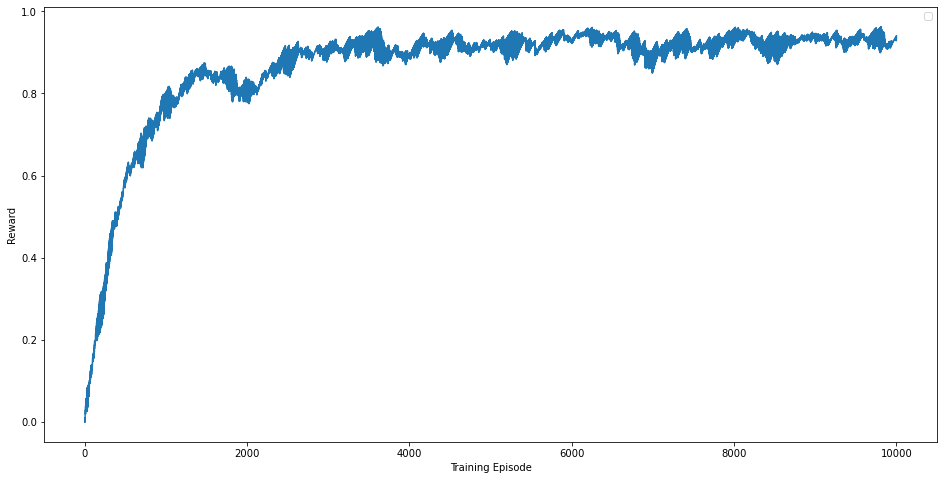

In [50]:
def exponential_moving_average(x, smoothing_parameter=0.99):
    initial_value = 0
    x_ema = [x[0]]
    
    for i in range(len(x)):
        x_ema.append(x_ema[i-1]*(smoothing_parameter) + x[i]*(1-smoothing_parameter))
                        
    return x_ema[1:]




R_save_copy = R_save.copy()
R_list = list(R_save_copy.flatten())
R_list_ema = exponential_moving_average(R_list)

plt.figure(figsize=(16,8))
plt.plot(R_list_ema)
plt.xlabel("Training Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()




In [28]:
def plot_exponential_moving_avg(result_array, ylabel = 'Reward', title = 'Exponential Moving Average of Reward Per Game'):
    result_array_copy = result_array.copy()
    
    R_list = list(result_array_copy.flatten())
    R_list_ema = exponential_moving_average(R_list)
    

    plt.figure(figsize=(16,8))
    plt.plot(R_list_ema)
    plt.xlabel("Training Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


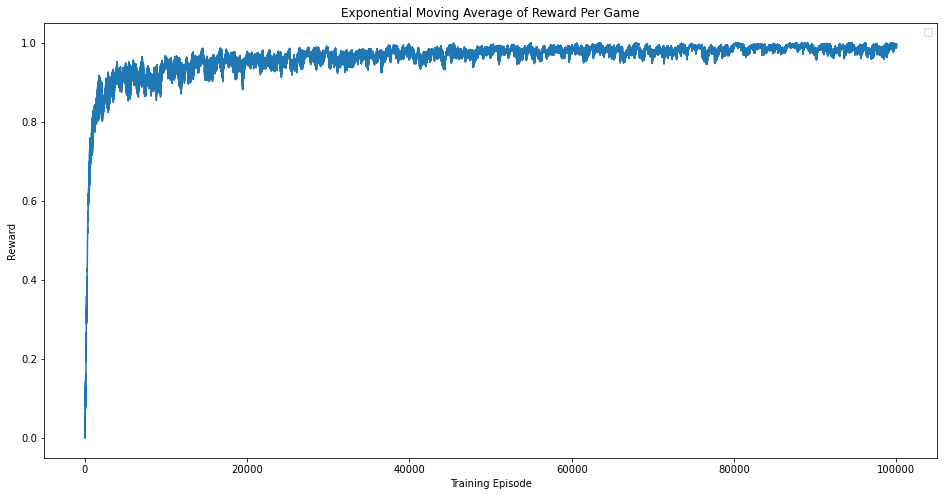

In [69]:
R_save_copy = R_save_adam.copy()

plot_exponential_moving_avg(R_save_copy)

In [81]:
0.85 ** 6

0.37714951562499993

No handles with labels found to put in legend.


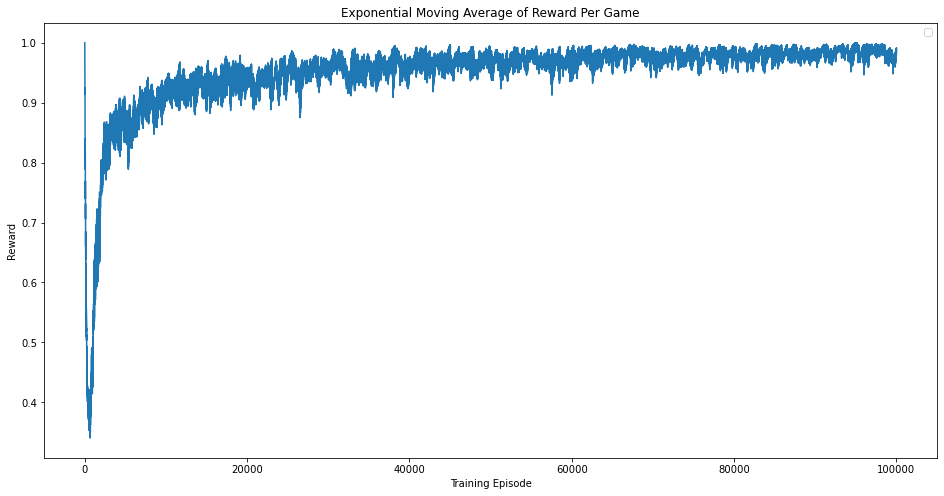

In [70]:
R_rms_copy = R_save_rms.copy()

plot_exponential_moving_avg(R_rms_copy)

No handles with labels found to put in legend.


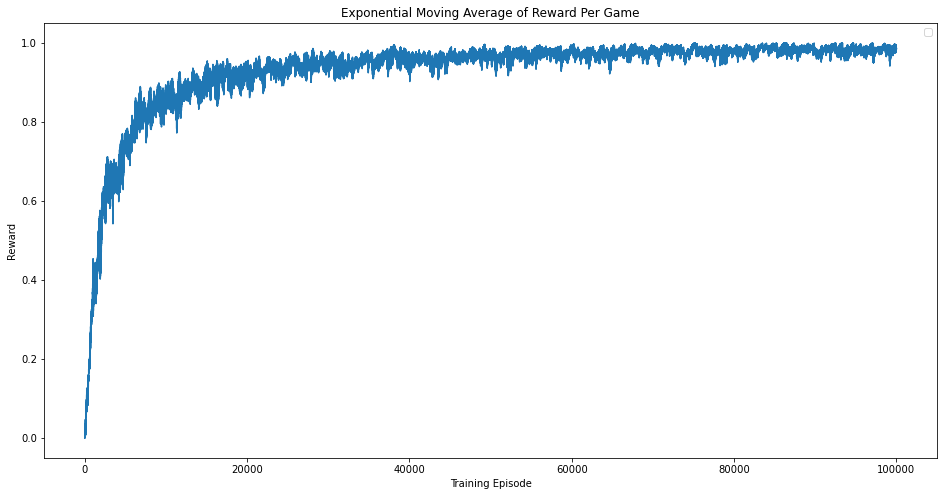

In [71]:
R_GD_copy = R_save_GD.copy()

plot_exponential_moving_avg(R_GD_copy)

No handles with labels found to put in legend.


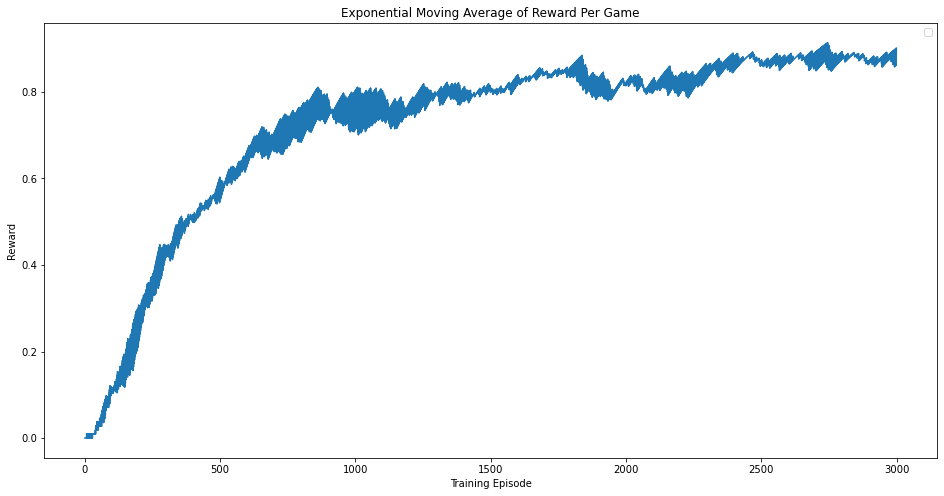

In [78]:
R_save_custom_R_copy = R_save_custom_R.copy()
plot_exponential_moving_avg(R_save_custom_R_copy)


No handles with labels found to put in legend.


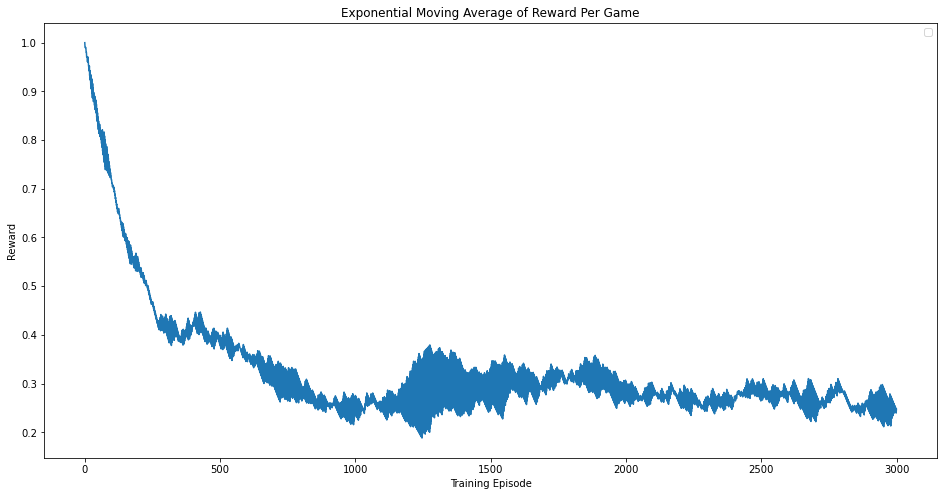

In [80]:
R_save_custom_R_copy = R_save_custom_R.copy()
plot_exponential_moving_avg(R_save_custom_R_copy)

In [ ]:
N_moves_save_copy = N_moves_save.copy()
N_moves_list = list(N_moves_save_copy.flatten())
N_moves_list_ema = exponential_moving_average(N_moves_list)

plt.figure(figsize=(16,8))
plt.plot(N_moves_list_ema)
plt.xlabel("Training Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

### Implementing Double Q learning (Hasselt, 2010)

In [ ]:
def DoubleQlearning(N_episodes = 100000, number_of_layers = 1,number_of_neurons_per_layer = [200],size_board = 4, epsilon_0 = 0.2, beta = 0.00005, gamma = 0.85, eta = 0.0035):
    
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

    env=Chess_Env(size_board)
    rng = np.random.default_rng()
    
    R_save = np.zeros([N_episodes, 1])
    N_moves_save = np.zeros([N_episodes, 1])
    
    
    S,X,allowed_a=env.Initialise_game()  
    number_possible_actions=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
    input_size=np.shape(X)[0]  + number_possible_actions  ## INPUT SIZE: the feature vector + a 1-hot encoding of the 32 actions

    # initialize both Networks
    Q_nn_A = NeuralNetwork(input_size= input_size, number_of_layers= number_of_layers, number_of_neurons_per_layer= number_of_neurons_per_layer, output_size= 1, init_type= 'He')
    Q_nn_B = NeuralNetwork(input_size= input_size, number_of_layers= number_of_layers, number_of_neurons_per_layer= number_of_neurons_per_layer, output_size= 1, init_type= 'He')
    
    for n in range(N_episodes):

        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

        S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
        print(f'Episode number: {n}')            ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING.  - Glad to hear.

        while Done==0:                           ## START THE EPISODE

            random_number = rng.random()
            
            ######
            # calculate QhatA, QhatB for all possible actions
            q_hat_predictions_A = []
            q_hat_predictions_B = []
            for k in range(number_possible_actions):
                action_vector = [0 for j in range(number_possible_actions)]
                action_vector[k] = 1
                
                nn_input = np.append(X, action_vector)
                q_hat_action_A, _  = Q_nn_A._forward(nn_input)
                q_hat_action_B, _  = Q_nn_B._forward(nn_input)
                
                q_hat_predictions_A.append(q_hat_action_A)       # at current state S, use both networks to estimate the Q(S, \cdot) function
                q_hat_predictions_B.append(q_hat_action_B)
                
            
            q_hat_predictions_A = np.array(q_hat_predictions_A)
            q_hat_predictions_B = np.array(q_hat_predictions_B)
            
            q_hat_predictions_sum = q_hat_predictions_A + q_hat_predictions_B
            
            
            # Choose A from S using policy derived from Q 
            selected_action = EpsilonGreedy_Policy(Qvalues = q_hat_predictions_sum, allowed_a = allowed_a, epsilon = epsilon_f)
            
            action_vector = [0 for j in range(number_possible_actions)]
            action_vector[selected_action] = 1
            X_train = [np.append(X, action_vector)]
            X_train = np.array(X_train)
            
            # Take the selected action 
            S_next,X_next,allowed_a_next,R,Done=env.OneStep(selected_action)
            
            
            if not Done:
                # calculate max_a Qhat(S', a)
                q_hat_predictions_A = []
                q_hat_predictions_B = [] 
                for k in range(number_possible_actions):
                    action_vector = [0 for j in range(number_possible_actions)]
                    action_vector[k] = 1

                    nn_input = np.append(X_next, action_vector)
#                     print(f'Shape of nn_input at line 67: {nn_input.shape}')
#                     print(f'Are we done: {Done}')
                    q_hat_action_A, _  = Q_nn_A._forward(nn_input)
                    q_hat_action_B, _  = Q_nn_B._forward(nn_input)

                    q_hat_predictions_A.append(q_hat_action_A)  
                    q_hat_predictions_B.append(q_hat_action_A)  

#                 print('---- REACHED LINE 70 ---- ')
                q_hat_predictions_A = np.array(q_hat_predictions_A)
                q_hat_predictions_B = np.array(q_hat_predictions_B)

                
                
                if (random_number < 0.5):
                    Q_star_next = q_hat_predictions_B[EpsilonGreedy_Policy(q_hat_predictions_A, allowed_a= allowed_a_next, epsilon = 0)]  # Double Q learning: With 1/2 probability, use Q^A to pick optimal action at S', and Q^B to predict its Q value
                else: 
                    Q_star_next = q_hat_predictions_A[EpsilonGreedy_Policy(q_hat_predictions_B, allowed_a= allowed_a_next, epsilon = 0)]  # Double Q learning: With 1/2 probability, use Q^B to pick optimal action at S', and Q^A to predict its Q value
            
            if Done == 1: 
                label = R 
            else:
                label = R + gamma * Q_star_next
            
            # update the parameters of ONE of the 2 networks (the one we used to pick the action)
            y_train = np.array([label])
            
            if (random_number < 0.5):
                Q_nn_A.train(x_train = X_train, y_train = y_train, lr = eta, epochs = 1, batch_size = 1, print_frequency = 100, optimization_alg = 'Adam', adam_beta = 0.9, shuffle_indexes = False)
                
            else: 
                Q_nn_B.train(x_train = X_train, y_train = y_train, lr = eta, epochs = 1, batch_size = 1, print_frequency = 100, optimization_alg = 'Adam', adam_beta = 0.9, shuffle_indexes = False)

            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done==1:
                R_save[n] = R
                N_moves_save[n] = i
    
                break

            # IF THE EPISODE IS NOT OVER...
            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
    return R_save, N_moves_save, Q_nn_A, Q_nn_B



In [ ]:
R_save2, N_moves_save2, Q_nn_A, Q_nn_B = DoubleQlearning(N_episodes= 10000)

In [ ]:
# r_save2_copy = R_save2.copy()

plot_exponential_moving_avg(R_save2)

In [ ]:
rng.random()